In [1]:
from imutils import paths
from tqdm import tqdm
import numpy as np
import cv2
import gc
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
# Load the TensorBoard notebook extension
from keras.callbacks import TensorBoard
%load_ext tensorboard
import tensorflow as tf
import datetime, os
from keras.callbacks import EarlyStopping
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
from keras.callbacks import ReduceLROnPlateau
# Load the TensorBoard notebook extension
from keras.callbacks import TensorBoard
%load_ext tensorboard
import tensorflow as tf
import datetime, os
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard("logs", histogram_freq=1)
from keras.callbacks import EarlyStopping

from keras.callbacks import ReduceLROnPlateau
earlyStopping = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='min')
mcp_save = ModelCheckpoint('/tmp', save_best_only=True, monitor='accuracy', mode='max')

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [2]:
!nvidia-smi

Mon Jul 18 16:28:05 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.73.08    Driver Version: 510.73.08    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A40          On   | 00000000:01:01.0 Off |                    0 |
|  0%   27C    P8    27W / 300W |      4MiB / 46068MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
%pip install -r /root/Downloads/DRDOCV-main/requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
from imutils import paths
from tqdm import tqdm


import cv2
from keras.utils.np_utils import to_categorical
import numpy as np
colors = np.array([
    [0,1,0,0,0,0,0,0],      # Drivable
    [0,0,1,0,0,0,0,0],     # Non Drivable
    [0,0,0,1,0,0,0,0],      # Living Things
    [0,0,0,0,1,0,0,0],        # Vehicles
    [0,0,0,0,0,1,0,0],     # Road Side Objects
    [0,0,0,0,0,0,1,0],       # Far Objects
    [0,0,0,0,0,0,0,1],     # Sky
    [1,0,0,0,0,0,0,0]           # Misc
], dtype=np.int32)

In [3]:
labels_path = paths.list_images("/root/Downloads/idd20kII/vallabel/")
labels_path = sorted(labels_path)
image_y_cv = []
for name in tqdm(labels_path):
  image = cv2.imread(name)
  image = cv2.resize(image, (320,320))
  r,g,b =cv2.split(image)
  color_image = np.zeros(
        (r.shape[0], r.shape[1], 8), dtype=np.int32)
  for i in range(8):
    color_image[r == i] = colors[i]
  image_y_cv.append(color_image)

from imutils import paths
x_path = paths.list_images("/root/Downloads/idd20kII/leftImg8bit/val")
x_path = sorted(x_path)

import cv2
image_cv = []
for name in tqdm(x_path):
  image = cv2.imread(name)
  image_cv.append(cv2.resize(image, (320, 320))/255)

import numpy as np
image_cv = np.array(image_cv)
image_y_cv = np.array(image_y_cv)
image_y_cv.shape,image_cv.shape



100%|███████████████████████████████████████| 1055/1055 [00:27<00:00, 38.15it/s]


((1055, 320, 320, 8), (1055, 320, 320, 3))

In [5]:
!nvidia-smi

Mon Jul 18 08:56:12 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.73.08    Driver Version: 510.73.08    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A40          On   | 00000000:01:01.0 Off |                    0 |
|  0%   27C    P8    27W / 300W |      4MiB / 46068MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
from imutils import paths
x_path = paths.list_images("/root/Downloads/idd20kII/leftImg8bit/train")
x_path = sorted(x_path)
x_path[:5]
from imutils import paths
labels_path = paths.list_images("/root/Downloads/idd20kII/trainlabel")
labels_path = sorted(labels_path)
labels_path[:5],x_path[:5]

(['/root/Downloads/idd20kII/trainlabel/201_frame0029_gtFine_polygons.png',
  '/root/Downloads/idd20kII/trainlabel/201_frame0299_gtFine_polygons.png',
  '/root/Downloads/idd20kII/trainlabel/201_frame0779_gtFine_polygons.png',
  '/root/Downloads/idd20kII/trainlabel/201_frame1019_gtFine_polygons.png',
  '/root/Downloads/idd20kII/trainlabel/201_frame1469_gtFine_polygons.png'],
 ['/root/Downloads/idd20kII/leftImg8bit/train/201/frame0029_leftImg8bit.jpg',
  '/root/Downloads/idd20kII/leftImg8bit/train/201/frame0299_leftImg8bit.jpg',
  '/root/Downloads/idd20kII/leftImg8bit/train/201/frame0779_leftImg8bit.jpg',
  '/root/Downloads/idd20kII/leftImg8bit/train/201/frame1019_leftImg8bit.jpg',
  '/root/Downloads/idd20kII/leftImg8bit/train/201/frame1469_leftImg8bit.jpg'])

In [5]:
len(labels_path),len(x_path)

(7034, 7034)

In [6]:

import cv2
import gc
import numpy as np
from tqdm import tqdm
colors = np.array([
    [0,1,0,0,0,0,0,0],      
    [0,0,1,0,0,0,0,0],     
    [0,0,0,1,0,0,0,0],      
    [0,0,0,0,1,0,0,0],        
    [0,0,0,0,0,1,0,0],    
    [0,0,0,0,0,0,1,0],      
    [0,0,0,0,0,0,0,1],     
    [1,0,0,0,0,0,0,0]           
], dtype=np.int32)
#global block
block = 0
# def train_label():
#   global block
#   image_y = []
#   if block + 200 <= 7034:
#     for name in tqdm(labels_path[block:block + 200]):
#       image = cv2.imread(name)
#       image = cv2.resize(image, (256, 256))
#       r,g,b =cv2.split(image)
#       color_image = np.zeros(
#         (r.shape[0], r.shape[1], 8), dtype=np.int)
#       for i in range(8):
#         color_image[r == i] = colors[i]

#       image_y.append(color_image)
#     block = block + 200
#   elif block < 7034:
#       for name in labels_path[block:]:
#         image = cv2.imread(name)
#         image = cv2.resize(image, (256, 256))
#         r,g,b =cv2.split(image)
#         color_image = np.zeros((r.shape[0], r.shape[1], 8), dtype=np.int)
#         for i in range(8):
#           color_image[r == i] = colors[i]
#         image_y.append(color_image)
#       block = 0
#   else:
#     block = 0
#     for name in tqdm(labels_path[block:block + 200]):
#       image = cv2.imread(name)
#       image = cv2.resize(image, (256, 256))
#       r,g,b =cv2.split(image)
#       color_image = np.zeros((r.shape[0], r.shape[1], 8), dtype=np.int)
#       for i in range(8):
#         color_image[r == i] = colors[i]
#       image_y.append(color_image)
#     block = block + 200
#   image_y = np.array(image_y)
#   collected = gc.collect()  
#   print("Garbage collector: collected", 
#           "%d objects." % collected)
#   return image_y
image_y = []
for name in tqdm(labels_path[0:4000]):
  image = cv2.imread(name)
  image = cv2.resize(image, (320,320))
  r,g,b =cv2.split(image)
  color_image = np.zeros(
    (r.shape[0], r.shape[1], 8), dtype=np.int32)
  for i in range(8):
    color_image[r == i] = colors[i]

  image_y.append(color_image)

100%|███████████████████████████████████████| 4000/4000 [01:20<00:00, 49.53it/s]


In [11]:
import cv2
block_1 = 0
image_tr = []
for name in tqdm(x_path[0:4000]):
  image = cv2.imread(name)
  img = cv2.resize(image, (320, 320))
  img = np.float32(img)  / 255 
  image_tr.append(img)
# def train():
#   collected = gc.collect()
#   print("Garbage collector: collected","%d objects." % collected) 
#   global block_1
#   image_tr = []
#   if block_1 + 200 <= 7034:
#     for name in tqdm(x_path[block_1:block_1 + 200]):
#       image = cv2.imread(name)
#       img = cv2.resize(image, (256, 256))
#       img = np.float32(img)  / 255 
#       image_tr.append(img)
#     block_1 = block_1 + 200
#   elif block_1 < 7034:
#     for name in tqdm(x_path[block_1:]):
#       image = cv2.imread(name)
#       img = cv2.resize(image, (256, 256))
#       img = np.float32(img)  / 255 
#       image_tr.append(img)
#     block_1 = 0
#   else:
#     block_1 = 0
#     for name in tqdm(x_path[block_1:block_1 + 200]):
#       image = cv2.imread(name)
#       img = cv2.resize(image, (256, 256))
#       img = np.float32(img)  / 255
#       image_tr.append(img)
#     block_1 = block_1 + 200
#   image_tr = np.array(image_tr)
#   return image_tr 

100%|███████████████████████████████████████| 4000/4000 [01:52<00:00, 35.64it/s]


In [ ]:
# labels_path[:5]
# image_tr

In [8]:
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
def get_small_unet(n_filters = 16, bn = True, dilation_rate = 1):
    '''Validation Image data generator
        Inputs: 
            n_filters - base convolution filters
            bn - flag to set batch normalization
            dilation_rate - convolution dilation rate
        Output: Unet keras Model
    '''
    #Define input batch shape
    batch_shape=(320,320,3)
    inputs = Input((320,320,3))
    print(inputs)
    
    conv1 = Conv2D(n_filters * 1, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate,kernel_initializer='he_normal')(inputs)
    if bn:
        conv1 = BatchNormalization()(conv1)
        
    conv1 = Conv2D(n_filters * 1, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate,kernel_initializer='he_uniform')(conv1)
    if bn:
        conv1 = BatchNormalization()(conv1)
    
    pool1 = MaxPooling2D(pool_size=(2, 2), data_format='channels_last')(conv1)

    conv2 = Conv2D(n_filters * 2, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate,kernel_initializer='he_uniform')(pool1)
    if bn:
        conv2 = BatchNormalization()(conv2)
        
    conv2 = Conv2D(n_filters * 2, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate,kernel_initializer='he_uniform')(conv2)
    if bn:
        conv2 = BatchNormalization()(conv2)
    
    pool2 = MaxPooling2D(pool_size=(2, 2), data_format='channels_last')(conv2)

    conv3 = Conv2D(n_filters * 4, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate,kernel_initializer='he_uniform')(pool2)
    if bn:
        conv3 = BatchNormalization()(conv3)
        
    conv3 = Conv2D(n_filters * 4, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate,kernel_initializer='he_uniform')(conv3)
    if bn:
        conv3 = BatchNormalization()(conv3)
        
    pool3 = MaxPooling2D(pool_size=(2, 2), data_format='channels_last')(conv3)

    conv4 = Conv2D(n_filters * 8, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate,kernel_initializer='he_uniform')(pool3)
    if bn:
        conv4 = BatchNormalization()(conv4)
        
    conv4 = Conv2D(n_filters * 8, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate,kernel_initializer='he_uniform')(conv4)
    if bn:
        conv4 = BatchNormalization()(conv4)
        
    pool4 = MaxPooling2D(pool_size=(2, 2), data_format='channels_last')(conv4)

    conv5 = Conv2D(n_filters * 16, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate,kernel_initializer='he_uniform')(pool4)
    if bn:
        conv5 = BatchNormalization()(conv5)
        
    conv5 = Conv2D(n_filters * 16, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate,kernel_initializer='he_uniform')(conv5)
    if bn:
        conv5 = BatchNormalization()(conv5)
    
    # pool5 = MaxPooling2D(pool_size=(2, 2), data_format='channels_last')(conv5)  

    # conv_6 = Conv2D(n_filters * 32, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(pool5)
    # if bn:
    #     conv_6 = BatchNormalization()(conv_6)
        
    # conv_6 = Conv2D(n_filters * 32, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(conv_6)
    # if bn:
    #     conv_6 = BatchNormalization()(conv_6)

    # up_6 = concatenate([UpSampling2D(size=(2, 2))(conv_6), conv5], axis=3) 
    
    # conv_7 = Conv2D(n_filters * 16, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(up_6)
    # if bn:
    #     conv_7 = BatchNormalization()(conv_7)
        
    # conv_7 = Conv2D(n_filters * 16, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(conv_7)
    # if bn:
    #     conv_7 = BatchNormalization()(conv_7)
        
    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=3)
    
    conv6 = Conv2D(n_filters * 8, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate,kernel_initializer='he_uniform')(up6)
    if bn:
        conv6 = BatchNormalization()(conv6)
        
    conv6 = Conv2D(n_filters * 8, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate,kernel_initializer='he_uniform')(conv6)
    if bn:
        conv6 = BatchNormalization()(conv6)
        
    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=3)
    
    conv7 = Conv2D(n_filters * 4, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate,kernel_initializer='he_uniform')(up7)
    if bn:
        conv7 = BatchNormalization()(conv7)
        
    conv7 = Conv2D(n_filters * 4, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate,kernel_initializer='he_uniform')(conv7)
    if bn:
        conv7 = BatchNormalization()(conv7)
        
    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=3)
    
    conv8 = Conv2D(n_filters * 2, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate,kernel_initializer='he_uniform')(up8)
    if bn:
        conv8 = BatchNormalization()(conv8)
        
    conv8 = Conv2D(n_filters * 2, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate,kernel_initializer='he_uniform')(conv8)
    if bn:
        conv8 = BatchNormalization()(conv8)
        
    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=3)
    
    conv9 = Conv2D(n_filters * 1, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate,kernel_initializer='he_uniform')(up9)
    if bn:
        conv9 = BatchNormalization()(conv9)
        
    conv9 = Conv2D(n_filters * 1, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate,kernel_initializer='he_uniform')(conv9)
    if bn:
        conv9 = BatchNormalization()(conv9)
        
    conv10 = Conv2D(8, (1, 1), activation='softmax', padding = 'same', dilation_rate = dilation_rate,kernel_initializer='he_uniform')(conv9)

    model = Model(inputs=inputs, outputs=conv10)

    
    return model


In [7]:
def IoU(y_val, y_pred):
    class_iou = []
    n_classes = 8
    
    y_predi = np.argmax(y_pred, axis=3)
    y_truei = np.argmax(y_val, axis=3)
    
    for c in range(n_classes):
        TP = np.sum((y_truei == c) & (y_predi == c))
        FP = np.sum((y_truei != c) & (y_predi == c))
        FN = np.sum((y_truei == c) & (y_predi != c)) 
        IoU = TP / float(TP + FP + FN)
        if(float(TP + FP + FN) == 0):
          IoU=TP/0.001
        class_iou.append(IoU)
    MIoU=sum(class_iou)/n_classes
    return MIoU
def miou( y_true, y_pred ) :
    score = tf.py_function( lambda y_true, y_pred : IoU( y_true, y_pred).astype('float32'),
                        [y_true, y_pred],
                        'float32')
    return score

In [10]:
model = get_small_unet(n_filters = 32)
model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['accuracy',miou])
model.summary()

KerasTensor(type_spec=TensorSpec(shape=(None, 320, 320, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


2022-07-18 09:32:54.028364: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-18 09:32:54.152547: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-18 09:32:54.152893: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-18 09:32:54.155131: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 320, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 320, 320, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 320, 320, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

                                                                                                  
 up_sampling2d_1 (UpSampling2D)  (None, 80, 80, 256)  0          ['batch_normalization_11[0][0]'] 
                                                                                                  
 concatenate_1 (Concatenate)    (None, 80, 80, 384)  0           ['up_sampling2d_1[0][0]',        
                                                                  'batch_normalization_5[0][0]']  
                                                                                                  
 conv2d_12 (Conv2D)             (None, 80, 80, 128)  442496      ['concatenate_1[0][0]']          
                                                                                                  
 batch_normalization_12 (BatchN  (None, 80, 80, 128)  512        ['conv2d_12[0][0]']              
 ormalization)                                                                                    
          

In [11]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [11]:
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [13]:
%%time
image_tr = np.array(image_tr)
image_y = np.array(image_y)
history = model.fit(image_tr,image_y,batch_size=24,epochs = 100 ,callbacks=[ mcp_save,tensorboard_callback],validation_data=(image_cv,image_y_cv))
# block

2022-07-18 09:39:04.347724: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 13107200000 exceeds 10% of free system memory.


Epoch 1/100
  5/167 [..............................] - ETA: 1:18 - loss: 0.3929 - accuracy: 0.8548 - miou: 0.4497

/tmp/ipykernel_282005/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


167/167 [==============================] - ETA: 0s - loss: 0.4141 - accuracy: 0.8492 - miou: 0.4586

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


167/167 [==============================] - 111s 665ms/step - loss: 0.4141 - accuracy: 0.8492 - miou: 0.4586 - val_loss: 0.5633 - val_accuracy: 0.7978 - val_miou: 0.3971
Epoch 2/100
  1/167 [..............................] - ETA: 1:22 - loss: 0.3873 - accuracy: 0.8636 - miou: 0.4819

/tmp/ipykernel_282005/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


167/167 [==============================] - ETA: 0s - loss: 0.3694 - accuracy: 0.8650 - miou: 0.4966

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


167/167 [==============================] - 109s 651ms/step - loss: 0.3694 - accuracy: 0.8650 - miou: 0.4966 - val_loss: 0.4787 - val_accuracy: 0.8248 - val_miou: 0.4563
Epoch 3/100
  1/167 [..............................] - ETA: 1:19 - loss: 0.3135 - accuracy: 0.8858 - miou: 0.4908

/tmp/ipykernel_282005/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


167/167 [==============================] - ETA: 0s - loss: 0.3552 - accuracy: 0.8702 - miou: 0.5106

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


167/167 [==============================] - 105s 632ms/step - loss: 0.3552 - accuracy: 0.8702 - miou: 0.5106 - val_loss: 0.4214 - val_accuracy: 0.8451 - val_miou: 0.4803
Epoch 4/100
  2/167 [..............................] - ETA: 1:22 - loss: 0.3241 - accuracy: 0.8772 - miou: 0.5233

/tmp/ipykernel_282005/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


167/167 [==============================] - ETA: 0s - loss: 0.3338 - accuracy: 0.8783 - miou: 0.5282

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


167/167 [==============================] - 104s 624ms/step - loss: 0.3338 - accuracy: 0.8783 - miou: 0.5282 - val_loss: 0.4204 - val_accuracy: 0.8435 - val_miou: 0.4842
Epoch 5/100
  1/167 [..............................] - ETA: 1:21 - loss: 0.3087 - accuracy: 0.8858 - miou: 0.5505

/tmp/ipykernel_282005/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


167/167 [==============================] - ETA: 0s - loss: 0.3281 - accuracy: 0.8809 - miou: 0.5357

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


167/167 [==============================] - 104s 626ms/step - loss: 0.3281 - accuracy: 0.8809 - miou: 0.5357 - val_loss: 0.4064 - val_accuracy: 0.8508 - val_miou: 0.5043
Epoch 6/100
  2/167 [..............................] - ETA: 1:19 - loss: 0.2840 - accuracy: 0.8958 - miou: 0.5687

/tmp/ipykernel_282005/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


167/167 [==============================] - ETA: 0s - loss: 0.3108 - accuracy: 0.8871 - miou: 0.5499

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


167/167 [==============================] - 105s 632ms/step - loss: 0.3108 - accuracy: 0.8871 - miou: 0.5499 - val_loss: 0.3782 - val_accuracy: 0.8613 - val_miou: 0.5097
Epoch 7/100
  1/167 [..............................] - ETA: 1:20 - loss: 0.2764 - accuracy: 0.9010 - miou: 0.6005

/tmp/ipykernel_282005/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


167/167 [==============================] - ETA: 0s - loss: 0.3012 - accuracy: 0.8909 - miou: 0.5591

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


167/167 [==============================] - 106s 634ms/step - loss: 0.3012 - accuracy: 0.8909 - miou: 0.5591 - val_loss: 0.3951 - val_accuracy: 0.8561 - val_miou: 0.4973
Epoch 8/100
  1/167 [..............................] - ETA: 1:20 - loss: 0.2918 - accuracy: 0.8863 - miou: 0.5602

/tmp/ipykernel_282005/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


167/167 [==============================] - ETA: 0s - loss: 0.2926 - accuracy: 0.8942 - miou: 0.5665

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


167/167 [==============================] - 106s 634ms/step - loss: 0.2926 - accuracy: 0.8942 - miou: 0.5665 - val_loss: 0.3829 - val_accuracy: 0.8576 - val_miou: 0.5200
Epoch 9/100
  2/167 [..............................] - ETA: 1:24 - loss: 0.2810 - accuracy: 0.8949 - miou: 0.5767

/tmp/ipykernel_282005/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


167/167 [==============================] - ETA: 0s - loss: 0.2810 - accuracy: 0.8985 - miou: 0.5762

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


167/167 [==============================] - 107s 639ms/step - loss: 0.2810 - accuracy: 0.8985 - miou: 0.5762 - val_loss: 0.3654 - val_accuracy: 0.8656 - val_miou: 0.5289
Epoch 10/100
  1/167 [..............................] - ETA: 1:21 - loss: 0.2463 - accuracy: 0.9098 - miou: 0.5800

/tmp/ipykernel_282005/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


167/167 [==============================] - ETA: 0s - loss: 0.2746 - accuracy: 0.9009 - miou: 0.5815

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


167/167 [==============================] - 105s 627ms/step - loss: 0.2746 - accuracy: 0.9009 - miou: 0.5815 - val_loss: 0.3690 - val_accuracy: 0.8694 - val_miou: 0.5261
Epoch 11/100
  1/167 [..............................] - ETA: 1:22 - loss: 0.2032 - accuracy: 0.9273 - miou: 0.5964

/tmp/ipykernel_282005/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


167/167 [==============================] - ETA: 0s - loss: 0.2628 - accuracy: 0.9058 - miou: 0.5928

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


167/167 [==============================] - 106s 633ms/step - loss: 0.2628 - accuracy: 0.9058 - miou: 0.5928 - val_loss: 0.3600 - val_accuracy: 0.8681 - val_miou: 0.5283
Epoch 12/100
  2/167 [..............................] - ETA: 1:30 - loss: 0.2492 - accuracy: 0.9108 - miou: 0.5922

/tmp/ipykernel_282005/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


167/167 [==============================] - ETA: 0s - loss: 0.2567 - accuracy: 0.9082 - miou: 0.5995

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


167/167 [==============================] - 106s 637ms/step - loss: 0.2567 - accuracy: 0.9082 - miou: 0.5995 - val_loss: 0.3471 - val_accuracy: 0.8721 - val_miou: 0.5450
Epoch 13/100
  1/167 [..............................] - ETA: 1:23 - loss: 0.2794 - accuracy: 0.9154 - miou: 0.6143

/tmp/ipykernel_282005/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


167/167 [==============================] - ETA: 0s - loss: 0.2453 - accuracy: 0.9129 - miou: 0.6086

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


167/167 [==============================] - 106s 637ms/step - loss: 0.2453 - accuracy: 0.9129 - miou: 0.6086 - val_loss: 0.3539 - val_accuracy: 0.8702 - val_miou: 0.5415
Epoch 14/100
  1/167 [..............................] - ETA: 1:24 - loss: 0.2070 - accuracy: 0.9294 - miou: 0.6418

/tmp/ipykernel_282005/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


167/167 [==============================] - ETA: 0s - loss: 0.2366 - accuracy: 0.9162 - miou: 0.6180

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


167/167 [==============================] - 106s 636ms/step - loss: 0.2366 - accuracy: 0.9162 - miou: 0.6180 - val_loss: 0.3363 - val_accuracy: 0.8786 - val_miou: 0.5549
Epoch 15/100
  4/167 [..............................] - ETA: 1:22 - loss: 0.2256 - accuracy: 0.9215 - miou: 0.6312

/tmp/ipykernel_282005/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


167/167 [==============================] - ETA: 0s - loss: 0.2287 - accuracy: 0.9196 - miou: 0.6246

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


167/167 [==============================] - 105s 627ms/step - loss: 0.2287 - accuracy: 0.9196 - miou: 0.6246 - val_loss: 0.3495 - val_accuracy: 0.8786 - val_miou: 0.5486
Epoch 16/100
  2/167 [..............................] - ETA: 1:22 - loss: 0.2622 - accuracy: 0.9134 - miou: 0.6283

/tmp/ipykernel_282005/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


167/167 [==============================] - ETA: 0s - loss: 0.2188 - accuracy: 0.9235 - miou: 0.6336

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


167/167 [==============================] - 106s 638ms/step - loss: 0.2188 - accuracy: 0.9235 - miou: 0.6336 - val_loss: 0.3846 - val_accuracy: 0.8673 - val_miou: 0.5353
Epoch 17/100
  2/167 [..............................] - ETA: 1:21 - loss: 0.2060 - accuracy: 0.9265 - miou: 0.6363

/tmp/ipykernel_282005/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


167/167 [==============================] - ETA: 0s - loss: 0.2078 - accuracy: 0.9277 - miou: 0.6436

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


167/167 [==============================] - 106s 638ms/step - loss: 0.2078 - accuracy: 0.9277 - miou: 0.6436 - val_loss: 0.3525 - val_accuracy: 0.8799 - val_miou: 0.5577
Epoch 18/100
  1/167 [..............................] - ETA: 1:21 - loss: 0.2099 - accuracy: 0.9315 - miou: 0.6827

/tmp/ipykernel_282005/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


167/167 [==============================] - 101s 603ms/step - loss: 0.2085 - accuracy: 0.9275 - miou: 0.6441 - val_loss: 0.3513 - val_accuracy: 0.8792 - val_miou: 0.5573
Epoch 19/100
167/167 [==============================] - ETA: 0s - loss: 0.1958 - accuracy: 0.9323 - miou: 0.6551

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


167/167 [==============================] - 107s 639ms/step - loss: 0.1958 - accuracy: 0.9323 - miou: 0.6551 - val_loss: 0.3637 - val_accuracy: 0.8787 - val_miou: 0.5543
Epoch 20/100
  1/167 [..............................] - ETA: 1:30 - loss: 0.1508 - accuracy: 0.9484 - miou: 0.6514

/tmp/ipykernel_282005/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


167/167 [==============================] - ETA: 0s - loss: 0.1862 - accuracy: 0.9358 - miou: 0.6647

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


167/167 [==============================] - 107s 641ms/step - loss: 0.1862 - accuracy: 0.9358 - miou: 0.6647 - val_loss: 0.3723 - val_accuracy: 0.8781 - val_miou: 0.5502
Epoch 21/100
  1/167 [..............................] - ETA: 1:26 - loss: 0.1476 - accuracy: 0.9499 - miou: 0.7002

/tmp/ipykernel_282005/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


167/167 [==============================] - ETA: 0s - loss: 0.1831 - accuracy: 0.9369 - miou: 0.6685

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


167/167 [==============================] - 107s 640ms/step - loss: 0.1831 - accuracy: 0.9369 - miou: 0.6685 - val_loss: 0.3665 - val_accuracy: 0.8791 - val_miou: 0.5619
Epoch 22/100
  1/167 [..............................] - ETA: 1:21 - loss: 0.2210 - accuracy: 0.9334 - miou: 0.6885

/tmp/ipykernel_282005/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


167/167 [==============================] - ETA: 0s - loss: 0.1774 - accuracy: 0.9391 - miou: 0.6730

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


167/167 [==============================] - 107s 644ms/step - loss: 0.1774 - accuracy: 0.9391 - miou: 0.6730 - val_loss: 0.3731 - val_accuracy: 0.8812 - val_miou: 0.5610
Epoch 23/100
  2/167 [..............................] - ETA: 1:29 - loss: 0.1509 - accuracy: 0.9476 - miou: 0.6997

/tmp/ipykernel_282005/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


167/167 [==============================] - ETA: 0s - loss: 0.1656 - accuracy: 0.9434 - miou: 0.6839

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


167/167 [==============================] - 106s 634ms/step - loss: 0.1656 - accuracy: 0.9434 - miou: 0.6839 - val_loss: 0.4192 - val_accuracy: 0.8733 - val_miou: 0.5407
Epoch 24/100
  1/167 [..............................] - ETA: 1:21 - loss: 0.1521 - accuracy: 0.9471 - miou: 0.6767

/tmp/ipykernel_282005/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


167/167 [==============================] - 103s 615ms/step - loss: 0.1705 - accuracy: 0.9416 - miou: 0.6805 - val_loss: 0.3800 - val_accuracy: 0.8805 - val_miou: 0.5594
Epoch 25/100
167/167 [==============================] - ETA: 0s - loss: 0.1594 - accuracy: 0.9453 - miou: 0.6907

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


167/167 [==============================] - 108s 646ms/step - loss: 0.1594 - accuracy: 0.9453 - miou: 0.6907 - val_loss: 0.3842 - val_accuracy: 0.8824 - val_miou: 0.5614
Epoch 26/100
  1/167 [..............................] - ETA: 1:21 - loss: 0.1356 - accuracy: 0.9530 - miou: 0.7046

/tmp/ipykernel_282005/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


167/167 [==============================] - ETA: 0s - loss: 0.1480 - accuracy: 0.9494 - miou: 0.7012

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


167/167 [==============================] - 111s 665ms/step - loss: 0.1480 - accuracy: 0.9494 - miou: 0.7012 - val_loss: 0.3765 - val_accuracy: 0.8822 - val_miou: 0.5591
Epoch 27/100
  2/167 [..............................] - ETA: 1:21 - loss: 0.1377 - accuracy: 0.9528 - miou: 0.7128

/tmp/ipykernel_282005/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


167/167 [==============================] - ETA: 0s - loss: 0.1418 - accuracy: 0.9516 - miou: 0.7071

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


167/167 [==============================] - 107s 641ms/step - loss: 0.1418 - accuracy: 0.9516 - miou: 0.7071 - val_loss: 0.4177 - val_accuracy: 0.8780 - val_miou: 0.5479
Epoch 28/100
  1/167 [..............................] - ETA: 1:24 - loss: 0.1295 - accuracy: 0.9555 - miou: 0.6939

/tmp/ipykernel_282005/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


167/167 [==============================] - 99s 595ms/step - loss: 0.1424 - accuracy: 0.9514 - miou: 0.7062 - val_loss: 0.3978 - val_accuracy: 0.8800 - val_miou: 0.5578
Epoch 29/100
167/167 [==============================] - ETA: 0s - loss: 0.1375 - accuracy: 0.9531 - miou: 0.7099

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


167/167 [==============================] - 106s 638ms/step - loss: 0.1375 - accuracy: 0.9531 - miou: 0.7099 - val_loss: 0.4131 - val_accuracy: 0.8819 - val_miou: 0.5617
Epoch 30/100
  1/167 [..............................] - ETA: 1:25 - loss: 0.1178 - accuracy: 0.9600 - miou: 0.7277

/tmp/ipykernel_282005/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


167/167 [==============================] - ETA: 0s - loss: 0.1287 - accuracy: 0.9562 - miou: 0.7205

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


167/167 [==============================] - 107s 641ms/step - loss: 0.1287 - accuracy: 0.9562 - miou: 0.7205 - val_loss: 0.4033 - val_accuracy: 0.8853 - val_miou: 0.5640
Epoch 31/100
  5/167 [..............................] - ETA: 1:26 - loss: 0.1164 - accuracy: 0.9601 - miou: 0.7268

/tmp/ipykernel_282005/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


167/167 [==============================] - ETA: 0s - loss: 0.1223 - accuracy: 0.9584 - miou: 0.7271

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


167/167 [==============================] - 106s 638ms/step - loss: 0.1223 - accuracy: 0.9584 - miou: 0.7271 - val_loss: 0.4068 - val_accuracy: 0.8841 - val_miou: 0.5682
Epoch 32/100
  1/167 [..............................] - ETA: 1:21 - loss: 0.1164 - accuracy: 0.9607 - miou: 0.7238

/tmp/ipykernel_282005/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


167/167 [==============================] - ETA: 0s - loss: 0.1198 - accuracy: 0.9593 - miou: 0.7300

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


167/167 [==============================] - 110s 661ms/step - loss: 0.1198 - accuracy: 0.9593 - miou: 0.7300 - val_loss: 0.4190 - val_accuracy: 0.8831 - val_miou: 0.5658
Epoch 33/100
  2/167 [..............................] - ETA: 1:22 - loss: 0.1190 - accuracy: 0.9597 - miou: 0.7311

/tmp/ipykernel_282005/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


167/167 [==============================] - 105s 627ms/step - loss: 0.1235 - accuracy: 0.9581 - miou: 0.7262 - val_loss: 0.4489 - val_accuracy: 0.8770 - val_miou: 0.5525
Epoch 34/100
167/167 [==============================] - 101s 608ms/step - loss: 0.1266 - accuracy: 0.9569 - miou: 0.7242 - val_loss: 0.4200 - val_accuracy: 0.8762 - val_miou: 0.5551
Epoch 35/100
167/167 [==============================] - 100s 602ms/step - loss: 0.1373 - accuracy: 0.9530 - miou: 0.7114 - val_loss: 0.4443 - val_accuracy: 0.8748 - val_miou: 0.5517
Epoch 36/100
167/167 [==============================] - 101s 603ms/step - loss: 0.1251 - accuracy: 0.9574 - miou: 0.7235 - val_loss: 0.4072 - val_accuracy: 0.8837 - val_miou: 0.5657
Epoch 37/100
167/167 [==============================] - ETA: 0s - loss: 0.1132 - accuracy: 0.9616 - miou: 0.7369

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


167/167 [==============================] - 107s 639ms/step - loss: 0.1132 - accuracy: 0.9616 - miou: 0.7369 - val_loss: 0.4362 - val_accuracy: 0.8850 - val_miou: 0.5673
Epoch 38/100
  1/167 [..............................] - ETA: 1:21 - loss: 0.1138 - accuracy: 0.9613 - miou: 0.7515

/tmp/ipykernel_282005/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


167/167 [==============================] - ETA: 0s - loss: 0.1068 - accuracy: 0.9638 - miou: 0.7437

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


167/167 [==============================] - 107s 639ms/step - loss: 0.1068 - accuracy: 0.9638 - miou: 0.7437 - val_loss: 0.4401 - val_accuracy: 0.8864 - val_miou: 0.5688
Epoch 39/100
  2/167 [..............................] - ETA: 1:20 - loss: 0.1070 - accuracy: 0.9638 - miou: 0.7455

/tmp/ipykernel_282005/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


167/167 [==============================] - ETA: 0s - loss: 0.1038 - accuracy: 0.9648 - miou: 0.7465

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


167/167 [==============================] - 107s 640ms/step - loss: 0.1038 - accuracy: 0.9648 - miou: 0.7465 - val_loss: 0.4384 - val_accuracy: 0.8856 - val_miou: 0.5685
Epoch 40/100
  1/167 [..............................] - ETA: 1:22 - loss: 0.1097 - accuracy: 0.9627 - miou: 0.7555

/tmp/ipykernel_282005/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


167/167 [==============================] - ETA: 0s - loss: 0.1017 - accuracy: 0.9656 - miou: 0.7490

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


167/167 [==============================] - 107s 642ms/step - loss: 0.1017 - accuracy: 0.9656 - miou: 0.7490 - val_loss: 0.4757 - val_accuracy: 0.8855 - val_miou: 0.5630
Epoch 41/100
  1/167 [..............................] - ETA: 1:22 - loss: 0.1040 - accuracy: 0.9642 - miou: 0.7512

/tmp/ipykernel_282005/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


167/167 [==============================] - ETA: 0s - loss: 0.0994 - accuracy: 0.9664 - miou: 0.7518

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


167/167 [==============================] - 107s 642ms/step - loss: 0.0994 - accuracy: 0.9664 - miou: 0.7518 - val_loss: 0.4576 - val_accuracy: 0.8855 - val_miou: 0.5650
Epoch 42/100
  1/167 [..............................] - ETA: 1:25 - loss: 0.0906 - accuracy: 0.9694 - miou: 0.7554

/tmp/ipykernel_282005/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


167/167 [==============================] - ETA: 0s - loss: 0.0976 - accuracy: 0.9669 - miou: 0.7531

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


167/167 [==============================] - 108s 648ms/step - loss: 0.0976 - accuracy: 0.9669 - miou: 0.7531 - val_loss: 0.4568 - val_accuracy: 0.8845 - val_miou: 0.5682
Epoch 43/100
  1/167 [..............................] - ETA: 1:23 - loss: 0.1075 - accuracy: 0.9633 - miou: 0.7620

/tmp/ipykernel_282005/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


167/167 [==============================] - ETA: 0s - loss: 0.0963 - accuracy: 0.9674 - miou: 0.7544

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


167/167 [==============================] - 108s 647ms/step - loss: 0.0963 - accuracy: 0.9674 - miou: 0.7544 - val_loss: 0.4728 - val_accuracy: 0.8844 - val_miou: 0.5669
Epoch 44/100
  2/167 [..............................] - ETA: 1:24 - loss: 0.0973 - accuracy: 0.9671 - miou: 0.7675

/tmp/ipykernel_282005/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


167/167 [==============================] - ETA: 0s - loss: 0.0952 - accuracy: 0.9677 - miou: 0.7554

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


167/167 [==============================] - 107s 643ms/step - loss: 0.0952 - accuracy: 0.9677 - miou: 0.7554 - val_loss: 0.4687 - val_accuracy: 0.8850 - val_miou: 0.5682
Epoch 45/100
  1/167 [..............................] - ETA: 1:20 - loss: 0.0911 - accuracy: 0.9690 - miou: 0.7692

/tmp/ipykernel_282005/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


167/167 [==============================] - ETA: 0s - loss: 0.0948 - accuracy: 0.9679 - miou: 0.7563

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


167/167 [==============================] - 108s 645ms/step - loss: 0.0948 - accuracy: 0.9679 - miou: 0.7563 - val_loss: 0.4914 - val_accuracy: 0.8844 - val_miou: 0.5659
Epoch 46/100
  3/167 [..............................] - ETA: 1:26 - loss: 0.0880 - accuracy: 0.9701 - miou: 0.7426

/tmp/ipykernel_282005/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


167/167 [==============================] - 101s 607ms/step - loss: 0.0975 - accuracy: 0.9669 - miou: 0.7533 - val_loss: 0.4849 - val_accuracy: 0.8807 - val_miou: 0.5624
Epoch 47/100
167/167 [==============================] - 102s 610ms/step - loss: 0.1546 - accuracy: 0.9477 - miou: 0.7006 - val_loss: 0.5667 - val_accuracy: 0.8596 - val_miou: 0.5224
Epoch 48/100
167/167 [==============================] - 102s 613ms/step - loss: 0.1298 - accuracy: 0.9556 - miou: 0.7211 - val_loss: 0.4118 - val_accuracy: 0.8808 - val_miou: 0.5618
Epoch 49/100
167/167 [==============================] - 102s 611ms/step - loss: 0.1047 - accuracy: 0.9645 - miou: 0.7464 - val_loss: 0.4467 - val_accuracy: 0.8866 - val_miou: 0.5691
Epoch 50/100
167/167 [==============================] - ETA: 0s - loss: 0.0938 - accuracy: 0.9684 - miou: 0.7579

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


167/167 [==============================] - 107s 642ms/step - loss: 0.0938 - accuracy: 0.9684 - miou: 0.7579 - val_loss: 0.4625 - val_accuracy: 0.8856 - val_miou: 0.5705
Epoch 51/100
  2/167 [..............................] - ETA: 1:23 - loss: 0.0881 - accuracy: 0.9702 - miou: 0.7487

/tmp/ipykernel_282005/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


167/167 [==============================] - ETA: 0s - loss: 0.0894 - accuracy: 0.9699 - miou: 0.7629

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


167/167 [==============================] - 107s 641ms/step - loss: 0.0894 - accuracy: 0.9699 - miou: 0.7629 - val_loss: 0.4746 - val_accuracy: 0.8857 - val_miou: 0.5712
Epoch 52/100
  2/167 [..............................] - ETA: 1:23 - loss: 0.0906 - accuracy: 0.9695 - miou: 0.7736

/tmp/ipykernel_282005/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


167/167 [==============================] - ETA: 0s - loss: 0.0873 - accuracy: 0.9706 - miou: 0.7651

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


167/167 [==============================] - 108s 645ms/step - loss: 0.0873 - accuracy: 0.9706 - miou: 0.7651 - val_loss: 0.4980 - val_accuracy: 0.8854 - val_miou: 0.5706
Epoch 53/100
  1/167 [..............................] - ETA: 1:24 - loss: 0.0852 - accuracy: 0.9713 - miou: 0.7411

/tmp/ipykernel_282005/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


167/167 [==============================] - ETA: 0s - loss: 0.0856 - accuracy: 0.9711 - miou: 0.7667

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


167/167 [==============================] - 109s 652ms/step - loss: 0.0856 - accuracy: 0.9711 - miou: 0.7667 - val_loss: 0.5118 - val_accuracy: 0.8796 - val_miou: 0.5593
Epoch 54/100
  1/167 [..............................] - ETA: 1:23 - loss: 0.0895 - accuracy: 0.9697 - miou: 0.7733

/tmp/ipykernel_282005/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


167/167 [==============================] - 100s 601ms/step - loss: 0.0941 - accuracy: 0.9681 - miou: 0.7577 - val_loss: 0.4785 - val_accuracy: 0.8848 - val_miou: 0.5668
Epoch 55/100
167/167 [==============================] - 100s 601ms/step - loss: 0.0858 - accuracy: 0.9710 - miou: 0.7664 - val_loss: 0.4891 - val_accuracy: 0.8857 - val_miou: 0.5684
Epoch 56/100
167/167 [==============================] - ETA: 0s - loss: 0.0827 - accuracy: 0.9721 - miou: 0.7702

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


167/167 [==============================] - 107s 644ms/step - loss: 0.0827 - accuracy: 0.9721 - miou: 0.7702 - val_loss: 0.5027 - val_accuracy: 0.8849 - val_miou: 0.5677
Epoch 57/100
  4/167 [..............................] - ETA: 1:23 - loss: 0.0815 - accuracy: 0.9727 - miou: 0.7642

/tmp/ipykernel_282005/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


167/167 [==============================] - ETA: 0s - loss: 0.0814 - accuracy: 0.9726 - miou: 0.7711

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


167/167 [==============================] - 106s 636ms/step - loss: 0.0814 - accuracy: 0.9726 - miou: 0.7711 - val_loss: 0.5134 - val_accuracy: 0.8856 - val_miou: 0.5692
Epoch 58/100
  1/167 [..............................] - ETA: 1:22 - loss: 0.0740 - accuracy: 0.9752 - miou: 0.7667

/tmp/ipykernel_282005/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


167/167 [==============================] - ETA: 0s - loss: 0.0803 - accuracy: 0.9729 - miou: 0.7731

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


167/167 [==============================] - 107s 644ms/step - loss: 0.0803 - accuracy: 0.9729 - miou: 0.7731 - val_loss: 0.5031 - val_accuracy: 0.8850 - val_miou: 0.5684
Epoch 59/100
  4/167 [..............................] - ETA: 1:20 - loss: 0.0802 - accuracy: 0.9728 - miou: 0.7697

/tmp/ipykernel_282005/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


167/167 [==============================] - ETA: 0s - loss: 0.0800 - accuracy: 0.9730 - miou: 0.7737

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


167/167 [==============================] - 108s 649ms/step - loss: 0.0800 - accuracy: 0.9730 - miou: 0.7737 - val_loss: 0.5114 - val_accuracy: 0.8856 - val_miou: 0.5690
Epoch 60/100
  1/167 [..............................] - ETA: 1:26 - loss: 0.0769 - accuracy: 0.9739 - miou: 0.7667

/tmp/ipykernel_282005/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


167/167 [==============================] - ETA: 0s - loss: 0.0789 - accuracy: 0.9734 - miou: 0.7749

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


167/167 [==============================] - 106s 636ms/step - loss: 0.0789 - accuracy: 0.9734 - miou: 0.7749 - val_loss: 0.5402 - val_accuracy: 0.8852 - val_miou: 0.5641
Epoch 61/100
  2/167 [..............................] - ETA: 1:24 - loss: 0.0802 - accuracy: 0.9731 - miou: 0.7764

/tmp/ipykernel_282005/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


167/167 [==============================] - 101s 604ms/step - loss: 0.0796 - accuracy: 0.9731 - miou: 0.7737 - val_loss: 0.5184 - val_accuracy: 0.8859 - val_miou: 0.5691
Epoch 62/100
167/167 [==============================] - ETA: 0s - loss: 0.0779 - accuracy: 0.9737 - miou: 0.7756

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


167/167 [==============================] - 107s 639ms/step - loss: 0.0779 - accuracy: 0.9737 - miou: 0.7756 - val_loss: 0.5410 - val_accuracy: 0.8848 - val_miou: 0.5668
Epoch 63/100
  1/167 [..............................] - ETA: 1:25 - loss: 0.0717 - accuracy: 0.9756 - miou: 0.7765

/tmp/ipykernel_282005/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


167/167 [==============================] - ETA: 0s - loss: 0.0771 - accuracy: 0.9740 - miou: 0.7770

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


167/167 [==============================] - 107s 643ms/step - loss: 0.0771 - accuracy: 0.9740 - miou: 0.7770 - val_loss: 0.5429 - val_accuracy: 0.8853 - val_miou: 0.5658
Epoch 64/100
  1/167 [..............................] - ETA: 1:25 - loss: 0.0734 - accuracy: 0.9751 - miou: 0.7890

/tmp/ipykernel_282005/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


167/167 [==============================] - ETA: 0s - loss: 0.0763 - accuracy: 0.9743 - miou: 0.7773

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


167/167 [==============================] - 108s 645ms/step - loss: 0.0763 - accuracy: 0.9743 - miou: 0.7773 - val_loss: 0.5500 - val_accuracy: 0.8850 - val_miou: 0.5681
Epoch 65/100
  1/167 [..............................] - ETA: 1:27 - loss: 0.0710 - accuracy: 0.9761 - miou: 0.7896

/tmp/ipykernel_282005/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


167/167 [==============================] - 101s 605ms/step - loss: 0.0764 - accuracy: 0.9742 - miou: 0.7777 - val_loss: 0.5513 - val_accuracy: 0.8861 - val_miou: 0.5662
Epoch 66/100
167/167 [==============================] - ETA: 0s - loss: 0.0757 - accuracy: 0.9745 - miou: 0.7789

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


167/167 [==============================] - 108s 645ms/step - loss: 0.0757 - accuracy: 0.9745 - miou: 0.7789 - val_loss: 0.5422 - val_accuracy: 0.8842 - val_miou: 0.5670
Epoch 67/100
  3/167 [..............................] - ETA: 1:22 - loss: 0.0811 - accuracy: 0.9725 - miou: 0.7758

/tmp/ipykernel_282005/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


167/167 [==============================] - ETA: 0s - loss: 0.0750 - accuracy: 0.9747 - miou: 0.7794

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


167/167 [==============================] - 108s 650ms/step - loss: 0.0750 - accuracy: 0.9747 - miou: 0.7794 - val_loss: 0.5572 - val_accuracy: 0.8841 - val_miou: 0.5649
Epoch 68/100
  1/167 [..............................] - ETA: 1:21 - loss: 0.0836 - accuracy: 0.9715 - miou: 0.7749

/tmp/ipykernel_282005/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


167/167 [==============================] - 101s 608ms/step - loss: 0.1154 - accuracy: 0.9613 - miou: 0.7393 - val_loss: 0.5381 - val_accuracy: 0.8672 - val_miou: 0.5293
Epoch 69/100
167/167 [==============================] - 101s 604ms/step - loss: 0.1235 - accuracy: 0.9580 - miou: 0.7272 - val_loss: 0.4620 - val_accuracy: 0.8822 - val_miou: 0.5570
Epoch 70/100
167/167 [==============================] - 101s 608ms/step - loss: 0.0905 - accuracy: 0.9694 - miou: 0.7616 - val_loss: 0.4670 - val_accuracy: 0.8851 - val_miou: 0.5678
Epoch 71/100
167/167 [==============================] - 106s 638ms/step - loss: 0.0792 - accuracy: 0.9733 - miou: 0.7754 - val_loss: 0.5026 - val_accuracy: 0.8861 - val_miou: 0.5699
Epoch 72/100
167/167 [==============================] - ETA: 0s - loss: 0.0744 - accuracy: 0.9750 - miou: 0.7805

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


167/167 [==============================] - 107s 641ms/step - loss: 0.0744 - accuracy: 0.9750 - miou: 0.7805 - val_loss: 0.5443 - val_accuracy: 0.8861 - val_miou: 0.5680
Epoch 73/100
  1/167 [..............................] - ETA: 1:21 - loss: 0.0758 - accuracy: 0.9742 - miou: 0.7754

/tmp/ipykernel_282005/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


167/167 [==============================] - ETA: 0s - loss: 0.0723 - accuracy: 0.9757 - miou: 0.7830

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


167/167 [==============================] - 107s 643ms/step - loss: 0.0723 - accuracy: 0.9757 - miou: 0.7830 - val_loss: 0.5493 - val_accuracy: 0.8852 - val_miou: 0.5685
Epoch 74/100
  1/167 [..............................] - ETA: 1:23 - loss: 0.0732 - accuracy: 0.9751 - miou: 0.7870

/tmp/ipykernel_282005/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


167/167 [==============================] - ETA: 0s - loss: 0.0705 - accuracy: 0.9762 - miou: 0.7847

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


167/167 [==============================] - 109s 653ms/step - loss: 0.0705 - accuracy: 0.9762 - miou: 0.7847 - val_loss: 0.5561 - val_accuracy: 0.8858 - val_miou: 0.5677
Epoch 75/100
  2/167 [..............................] - ETA: 1:21 - loss: 0.0680 - accuracy: 0.9770 - miou: 0.7930

/tmp/ipykernel_282005/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


167/167 [==============================] - ETA: 0s - loss: 0.0695 - accuracy: 0.9766 - miou: 0.7859

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


167/167 [==============================] - 108s 648ms/step - loss: 0.0695 - accuracy: 0.9766 - miou: 0.7859 - val_loss: 0.5515 - val_accuracy: 0.8856 - val_miou: 0.5691
Epoch 76/100
  1/167 [..............................] - ETA: 1:22 - loss: 0.0761 - accuracy: 0.9744 - miou: 0.7805

/tmp/ipykernel_282005/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


167/167 [==============================] - ETA: 0s - loss: 0.0688 - accuracy: 0.9768 - miou: 0.7867

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


167/167 [==============================] - 107s 643ms/step - loss: 0.0688 - accuracy: 0.9768 - miou: 0.7867 - val_loss: 0.5603 - val_accuracy: 0.8857 - val_miou: 0.5687
Epoch 77/100
  1/167 [..............................] - ETA: 1:20 - loss: 0.0611 - accuracy: 0.9795 - miou: 0.7849

/tmp/ipykernel_282005/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


167/167 [==============================] - ETA: 0s - loss: 0.0684 - accuracy: 0.9770 - miou: 0.7869

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


167/167 [==============================] - 107s 641ms/step - loss: 0.0684 - accuracy: 0.9770 - miou: 0.7869 - val_loss: 0.5732 - val_accuracy: 0.8852 - val_miou: 0.5677
Epoch 78/100
  3/167 [..............................] - ETA: 1:20 - loss: 0.0673 - accuracy: 0.9773 - miou: 0.7781

/tmp/ipykernel_282005/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


167/167 [==============================] - ETA: 0s - loss: 0.0679 - accuracy: 0.9771 - miou: 0.7873

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


167/167 [==============================] - 109s 652ms/step - loss: 0.0679 - accuracy: 0.9771 - miou: 0.7873 - val_loss: 0.5832 - val_accuracy: 0.8860 - val_miou: 0.5668
Epoch 79/100
  2/167 [..............................] - ETA: 1:19 - loss: 0.0684 - accuracy: 0.9770 - miou: 0.7760

/tmp/ipykernel_282005/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


167/167 [==============================] - 102s 613ms/step - loss: 0.0681 - accuracy: 0.9770 - miou: 0.7866 - val_loss: 0.5901 - val_accuracy: 0.8850 - val_miou: 0.5674
Epoch 80/100
167/167 [==============================] - 103s 615ms/step - loss: 0.0684 - accuracy: 0.9769 - miou: 0.7857 - val_loss: 0.5840 - val_accuracy: 0.8854 - val_miou: 0.5664
Epoch 81/100
167/167 [==============================] - ETA: 0s - loss: 0.0675 - accuracy: 0.9772 - miou: 0.7879

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


167/167 [==============================] - 108s 649ms/step - loss: 0.0675 - accuracy: 0.9772 - miou: 0.7879 - val_loss: 0.5918 - val_accuracy: 0.8856 - val_miou: 0.5672
Epoch 82/100
  1/167 [..............................] - ETA: 1:25 - loss: 0.0692 - accuracy: 0.9767 - miou: 0.7777

/tmp/ipykernel_282005/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


167/167 [==============================] - ETA: 0s - loss: 0.0672 - accuracy: 0.9773 - miou: 0.7876

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


167/167 [==============================] - 108s 649ms/step - loss: 0.0672 - accuracy: 0.9773 - miou: 0.7876 - val_loss: 0.5803 - val_accuracy: 0.8855 - val_miou: 0.5674
Epoch 83/100
  1/167 [..............................] - ETA: 1:25 - loss: 0.0673 - accuracy: 0.9772 - miou: 0.7820

/tmp/ipykernel_282005/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


167/167 [==============================] - ETA: 0s - loss: 0.0668 - accuracy: 0.9775 - miou: 0.7883

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


167/167 [==============================] - 108s 650ms/step - loss: 0.0668 - accuracy: 0.9775 - miou: 0.7883 - val_loss: 0.5897 - val_accuracy: 0.8855 - val_miou: 0.5673
Epoch 84/100
  2/167 [..............................] - ETA: 1:25 - loss: 0.0648 - accuracy: 0.9781 - miou: 0.7929

/tmp/ipykernel_282005/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


167/167 [==============================] - ETA: 0s - loss: 0.0664 - accuracy: 0.9776 - miou: 0.7888

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


167/167 [==============================] - 107s 640ms/step - loss: 0.0664 - accuracy: 0.9776 - miou: 0.7888 - val_loss: 0.5944 - val_accuracy: 0.8851 - val_miou: 0.5678
Epoch 85/100
  1/167 [..............................] - ETA: 1:22 - loss: 0.0662 - accuracy: 0.9778 - miou: 0.7920

/tmp/ipykernel_282005/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


167/167 [==============================] - 105s 631ms/step - loss: 0.0670 - accuracy: 0.9774 - miou: 0.7880 - val_loss: 0.6096 - val_accuracy: 0.8848 - val_miou: 0.5660
Epoch 86/100
167/167 [==============================] - 102s 611ms/step - loss: 0.1283 - accuracy: 0.9567 - miou: 0.7259 - val_loss: 0.4852 - val_accuracy: 0.8739 - val_miou: 0.5454
Epoch 87/100
167/167 [==============================] - 101s 605ms/step - loss: 0.0983 - accuracy: 0.9668 - miou: 0.7536 - val_loss: 0.4675 - val_accuracy: 0.8836 - val_miou: 0.5643
Epoch 88/100
167/167 [==============================] - 102s 614ms/step - loss: 0.0776 - accuracy: 0.9738 - miou: 0.7762 - val_loss: 0.5131 - val_accuracy: 0.8869 - val_miou: 0.5692
Epoch 89/100
167/167 [==============================] - 102s 614ms/step - loss: 0.0697 - accuracy: 0.9765 - miou: 0.7854 - val_loss: 0.5481 - val_accuracy: 0.8858 - val_miou: 0.5679
Epoch 90/100
167/167 [==============================] - ETA: 0s - loss: 0.0659 - accuracy: 0.9778 - mio

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


167/167 [==============================] - 112s 672ms/step - loss: 0.0659 - accuracy: 0.9778 - miou: 0.7895 - val_loss: 0.5821 - val_accuracy: 0.8859 - val_miou: 0.5687
Epoch 91/100
  1/167 [..............................] - ETA: 1:36 - loss: 0.0620 - accuracy: 0.9790 - miou: 0.7798

/tmp/ipykernel_282005/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


167/167 [==============================] - ETA: 0s - loss: 0.0642 - accuracy: 0.9784 - miou: 0.7915

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


167/167 [==============================] - 108s 646ms/step - loss: 0.0642 - accuracy: 0.9784 - miou: 0.7915 - val_loss: 0.5882 - val_accuracy: 0.8852 - val_miou: 0.5685
Epoch 92/100
  1/167 [..............................] - ETA: 1:21 - loss: 0.0679 - accuracy: 0.9769 - miou: 0.7964

/tmp/ipykernel_282005/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


167/167 [==============================] - ETA: 0s - loss: 0.0633 - accuracy: 0.9787 - miou: 0.7929

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


167/167 [==============================] - 108s 645ms/step - loss: 0.0633 - accuracy: 0.9787 - miou: 0.7929 - val_loss: 0.5951 - val_accuracy: 0.8855 - val_miou: 0.5672
Epoch 93/100
  1/167 [..............................] - ETA: 1:22 - loss: 0.0603 - accuracy: 0.9798 - miou: 0.7963

/tmp/ipykernel_282005/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


167/167 [==============================] - ETA: 0s - loss: 0.0628 - accuracy: 0.9788 - miou: 0.7932

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


167/167 [==============================] - 107s 642ms/step - loss: 0.0628 - accuracy: 0.9788 - miou: 0.7932 - val_loss: 0.6061 - val_accuracy: 0.8852 - val_miou: 0.5663
Epoch 94/100
  1/167 [..............................] - ETA: 1:23 - loss: 0.0574 - accuracy: 0.9805 - miou: 0.7834

/tmp/ipykernel_282005/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


167/167 [==============================] - ETA: 0s - loss: 0.0627 - accuracy: 0.9789 - miou: 0.7936

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


167/167 [==============================] - 107s 643ms/step - loss: 0.0627 - accuracy: 0.9789 - miou: 0.7936 - val_loss: 0.6163 - val_accuracy: 0.8858 - val_miou: 0.5659
Epoch 95/100
  1/167 [..............................] - ETA: 1:20 - loss: 0.0709 - accuracy: 0.9758 - miou: 0.7769

/tmp/ipykernel_282005/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


167/167 [==============================] - ETA: 0s - loss: 0.0621 - accuracy: 0.9791 - miou: 0.7941

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


167/167 [==============================] - 109s 652ms/step - loss: 0.0621 - accuracy: 0.9791 - miou: 0.7941 - val_loss: 0.6154 - val_accuracy: 0.8854 - val_miou: 0.5673
Epoch 96/100
  2/167 [..............................] - ETA: 1:31 - loss: 0.0591 - accuracy: 0.9801 - miou: 0.7896

/tmp/ipykernel_282005/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


167/167 [==============================] - ETA: 0s - loss: 0.0616 - accuracy: 0.9792 - miou: 0.7951

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


167/167 [==============================] - 108s 646ms/step - loss: 0.0616 - accuracy: 0.9792 - miou: 0.7951 - val_loss: 0.6095 - val_accuracy: 0.8843 - val_miou: 0.5667
Epoch 97/100
  2/167 [..............................] - ETA: 1:21 - loss: 0.0585 - accuracy: 0.9801 - miou: 0.7854

/tmp/ipykernel_282005/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


167/167 [==============================] - 103s 616ms/step - loss: 0.0617 - accuracy: 0.9792 - miou: 0.7944 - val_loss: 0.6208 - val_accuracy: 0.8851 - val_miou: 0.5671
Epoch 98/100
167/167 [==============================] - ETA: 0s - loss: 0.0613 - accuracy: 0.9793 - miou: 0.7949

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


167/167 [==============================] - 108s 645ms/step - loss: 0.0613 - accuracy: 0.9793 - miou: 0.7949 - val_loss: 0.6272 - val_accuracy: 0.8856 - val_miou: 0.5658
Epoch 99/100
  1/167 [..............................] - ETA: 1:31 - loss: 0.0638 - accuracy: 0.9787 - miou: 0.7862

/tmp/ipykernel_282005/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


167/167 [==============================] - 101s 607ms/step - loss: 0.0616 - accuracy: 0.9792 - miou: 0.7945 - val_loss: 0.6032 - val_accuracy: 0.8845 - val_miou: 0.5669
Epoch 100/100
167/167 [==============================] - ETA: 0s - loss: 0.0612 - accuracy: 0.9793 - miou: 0.7950

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


167/167 [==============================] - 109s 653ms/step - loss: 0.0612 - accuracy: 0.9793 - miou: 0.7950 - val_loss: 0.6376 - val_accuracy: 0.8849 - val_miou: 0.5662
CPU times: user 2h 44min 53s, sys: 46min 25s, total: 3h 31min 19s
Wall time: 2h 56min 22s


In [15]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

2022-07-14 07:30:58.195405: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-14 07:30:58.195680: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-14 07:30:58.195823: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-14 07:30:58.196036: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-14 07:30:58.196185: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from S

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 790939784902349794
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 45786595328
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 14360864091305954798
 physical_device_desc: "device: 0, name: NVIDIA A40, pci bus id: 0000:01:01.0, compute capability: 8.6"
 xla_global_id: 416903419]

In [ ]:
flag = 1
history_1 = []
while(flag):
  x  = train()  
  y = train_label()
  history = model.fit(image_tr,image_y,batch_size=16,epochs = 10 ,callbacks=[earlyStopping, mcp_save,tensorboard_callback],validation_data=(image_cv,image_y_cv))
  history_1.append(history)
  # flag = int(input ("Enter 0 if you want to stop training" ))
  # if flag == 0:
    # break

In [14]:

model.save('unet_batch_norm_v3.hdf5')

In [ ]:
val_loss = []
for i in range(len(history_1)):
  val_loss.append(history_1[i].history['val_loss'])

flat_val_loss = []
for sublist in val_loss:
    for item in sublist:
        flat_val_loss.append(item)
loss = []
for i in range(len(history_1)):
  loss.append(history_1[i].history['loss'])

flat_loss = []
for sublist in loss:
    for item in sublist:
        flat_loss.append(item)

import matplotlib.pyplot as plt


plt.plot(flat_loss, 'r')
plt.plot(flat_val_loss, 'b')
plt.legend({'Train Loss': 'r', 'Test Loss':'b'})
plt.show()

In [ ]:
val_loss = []
for i in range(len(history_1)):
  val_loss.append(history_1[i].history['val_miou'])

flat_val_loss = []
for sublist in val_loss:
    for item in sublist:
        flat_val_loss.append(item)

loss = []
for i in range(len(history_1)):
  loss.append(history_1[i].history['miou'])

flat_loss = []
for sublist in loss:
    for item in sublist:
        flat_loss.append(item)

In [ ]:
import matplotlib.pyplot as plt


plt.plot(flat_loss, 'r')
plt.plot(flat_val_loss, 'b')
plt.legend({'Train miou': 'r', 'Test miou':'b'})
plt.show()

In [ ]:
val_loss = []
for i in range(len(history_1)):
  val_loss.append(history_1[i].history['val_accuracy'])

flat_val_loss = []
for sublist in val_loss:
    for item in sublist:
        flat_val_loss.append(item)

loss = []
for i in range(len(history_1)):
  loss.append(history_1[i].history['accuracy'])

flat_loss = []
for sublist in loss:
    for item in sublist:
        flat_loss.append(item)

In [ ]:
import matplotlib.pyplot as plt


plt.plot(flat_loss, 'r')
plt.plot(flat_val_loss, 'b')
plt.legend({'Train accuracy': 'r', 'Test accuracy':'b'})
plt.show()

In [17]:
t_path = paths.list_images("/root/Downloads/idd20kII/leftImg8bit/test")
t_path = sorted(t_path)
t_path[:5]

['/root/Downloads/idd20kII/leftImg8bit/test/200/frame0199_leftImg8bit.jpg',
 '/root/Downloads/idd20kII/leftImg8bit/test/200/frame0252_leftImg8bit.jpg',
 '/root/Downloads/idd20kII/leftImg8bit/test/200/frame1090_leftImg8bit.jpg',
 '/root/Downloads/idd20kII/leftImg8bit/test/200/frame1250_leftImg8bit.jpg',
 '/root/Downloads/idd20kII/leftImg8bit/test/200/frame1457_leftImg8bit.jpg']

In [18]:
image_y[0]
result = np.argmax(image_y[0], axis=2)
colors_t = np.array([
    [203,192,255],      
    [122,160,255],     
    [180,105,255],      
    [92,92,205],        
    [0,165,255],    
    [0,255,255],      
    [42,42,165],     
    [0,0,255]           
], dtype=np.int32)
colors = np.array([
    [255, 192 ,203],      
    [255, 160, 122],     
    [255, 105, 180],      
    [205,  92,  92],        
    [255, 165,   0],    
    [255, 255,   0],      
    [165,  42,  42],     
    [0,   0, 255]           
], dtype=np.int32)
orig_mask = np.zeros(
        (result.shape[0], result.shape[1], 3), dtype=np.int32)
for i in range(8):
  orig_mask[result == i] = colors_t[i]
orig_mask



array([[[ 92,  92, 205],
        [ 92,  92, 205],
        [ 92,  92, 205],
        ...,
        [ 92,  92, 205],
        [ 92,  92, 205],
        [ 92,  92, 205]],

       [[ 92,  92, 205],
        [ 92,  92, 205],
        [ 92,  92, 205],
        ...,
        [ 92,  92, 205],
        [ 92,  92, 205],
        [ 92,  92, 205]],

       [[ 92,  92, 205],
        [ 92,  92, 205],
        [ 92,  92, 205],
        ...,
        [ 92,  92, 205],
        [ 92,  92, 205],
        [ 92,  92, 205]],

       ...,

       [[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [  0, 165, 255],
        [  0, 165, 255],
        [  0, 165, 255]],

       [[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [  0, 165, 255],
        [  0, 165, 255],
        [  0, 165, 255]],

       [[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [  0, 165, 255],
        [  0, 165, 255],
        [  0,   0, 255]]

In [19]:
orig_mask.shape

orig_mask = orig_mask.astype('float32') 
im1 = cv2.resize(orig_mask,(512,512))
from matplotlib import image
from matplotlib import pyplot
cv2.imwrite('image2.png',im1)



True

1/1 [==============================] - 2s 2s/step


/tmp/ipykernel_433763/1319847555.py:25: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ], dtype=np.int)


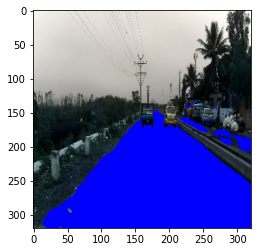

In [20]:

from matplotlib import image
from matplotlib import pyplot
import numpy as np
import cv2
model_new = tf.keras.models.load_model('/root/Downloads/unet_resnet50_v1.hdf5',custom_objects={"miou": miou})
image_te = []
image = cv2.imread(t_path[0])
img = cv2.resize(image, (320, 320))
origimg = cv2.resize(image, (320, 320))
img = np.float32(img)  / 255 
image_te.append(img)

image_te = np.array(image_te)
result = model_new.predict(image_te)
result = np.argmax(result, axis=3)
colors = np.array([
    [255, 192 ,203],      
    [255, 160, 122],     
    [255, 105, 180],      
    [205,  92,  92],        
    [255, 165,   0],    
    [255, 255,   0],      
    [165,  42,  42],     
    [0,   0, 255]           
], dtype=np.int)
image_y_te = []

color_image = np.zeros(
        (result.shape[1], result.shape[2], 3), dtype=np.int32)

origimg[result[0] == 7] = [0,0,0]
color_image[result[0] == 7] = colors[7]
final_image =  origimg + color_image
# for i in range(8):
  # color_image[result[0] == i] = colors[i]
# image_y_te.append(color_image)
# image_y_te = np.array(image_y_te)

# pyplot.imshow(img)
# pyplot.show()

# cv2.resize(img, (w, h))
# img = cv2.resize(color_image, (512, 512))
pyplot.imshow(final_image)
pyplot.show()
# # result

In [21]:
# pyplot.imshow(color_image)
# pyplot.show()

image = cv2.imread(x_path[0])
img = cv2.resize(image, (256, 256))
# color_image[result[0] != 6] = img
# pyplot.imshow(img)
# pyplot.show()
image = cv2.imread(x_path[0])
img = cv2.resize(image, (256, 256))
img[result[0] == 6] = [0,0,0]
img

IndexError: boolean index did not match indexed array along dimension 0; dimension is 256 but corresponding boolean dimension is 320

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
result

In [ ]:
pyplot.imshow(img)

In [ ]:

# # result
# # color_image = np.zeros(
# #         (result.shape[1], result.shape[2], 3), dtype=np.int)
# # color_image
# result[0] == 3
# color_image[result[0] == 3] = colors[3]
# color_image

In [ ]:
# colors = np.array([
#     [255, 192 ,203	],      
#     [255, 160, 122],     
#     [255, 105, 180],      
#     [205,  92,  92],        
#     [255, 165,   0],    
#     [255, 255,   0],      
#     [165,  42,  42],     
#     [0,   0, 255]           
# ], dtype=np.int)
# image_y_te = []

# color_image = np.zeros(
#         (result.shape[1], result.shape[2], 3), dtype=np.int)
# for i in range(8):
#   color_image[result[0] == i] = colors[i]
# image_y_te.append(color_image)
# image_y_te = np.array(image_y_te)

In [ ]:
# from matplotlib import image
# from matplotlib import pyplot

# pyplot.imshow(color_image)
# pyplot.show()

In [ ]:
# image_y_te

In [22]:
%cd /root/Downloads/Output3

/root/Downloads/Output2


1/1 [==============================] - 0s 40ms/step


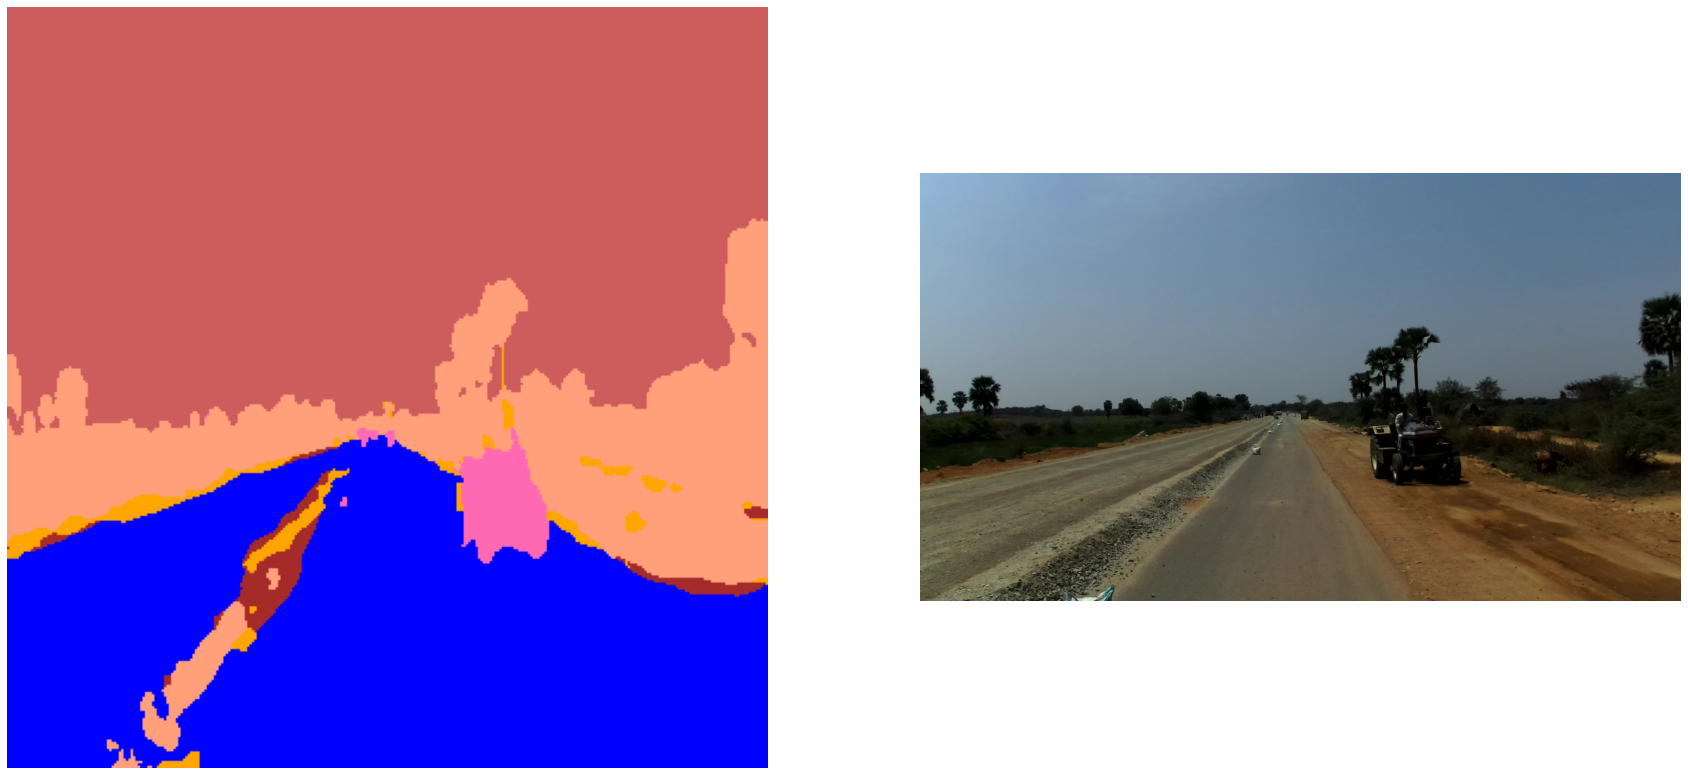

100%|█████████████████████████████████████████| 500/500 [08:53<00:00,  1.07s/it]

Write to:frame5661_leftImg8bit.jpg


In [22]:
from PIL import Image
from IPython.display import clear_output
for test_img in tqdm(range(len(t_path))[0:500]):
    clear_output(wait=True)
    image = cv2.imread(t_path[test_img])
    img = cv2.resize(image, (320, 320))
    img = np.float32(img)  / 255 

    image = np.array(img)
    result = model.predict(np.expand_dims(image,axis = 0))
    result = np.argmax(result, axis=3)
    colors = np.array([
    [255, 192 ,203],      
    [255, 160, 122],     
    [255, 105, 180],      
    [205,  92,  92],        
    [255, 165,   0],    
    [255, 255,   0],      
    [165,  42,  42],     
    [0,   0, 255]           
  ], dtype=np.int32)
    color_image = np.zeros(
          (result.shape[1], result.shape[2], 3), dtype=np.int32)
    for i in range(8):
        color_image[result[0] == i] = colors[i]
    from matplotlib import image
    from matplotlib import pyplot
    #pyplot.figure(figsize=(30, 30))
    fig, (ax0, ax1) = pyplot.subplots(ncols=2,figsize=(30,30))
    
    #ax0.figure(figsize=(10, 10))
    ax0.axis('off')
    ax0.imshow(color_image)
    import matplotlib.image as mpimg
    #ax1.figure(figsize=(10, 10))
    ax1.axis('off')
    ax1.imshow(mpimg.imread(t_path[test_img]))
    pyplot.savefig(t_path[test_img].split('/')[-1])
    pyplot.show()
    print("Write to:"+t_path[test_img].split('/')[-1])

In [22]:
! nvidia-smi

Mon Jul 18 16:15:57 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.73.08    Driver Version: 510.73.08    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A40          On   | 00000000:01:01.0 Off |                    0 |
|  0%   26C    P8    27W / 300W |  45144MiB / 46068MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [27]:
! pip install -U segmentation-models

     |████████████████████████████████| 50 kB 18.3 MB/s eta 0:00:01


In [8]:
from segmentation_models import Unet
from segmentation_models.utils import set_trainable

Segmentation Models: using `keras` framework.


In [15]:
model = Unet(backbone_name='resnet34', encoder_weights='imagenet', encoder_freeze=True,classes=8)
model.compile('Adam', loss="categorical_crossentropy", metrics=['accuracy',miou])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d_34 (ZeroPadding  (None, None, None,   0          ['bn_data[0][0]']                
 2D)                            3)                                                          

                                                                                                  
 stage1_unit3_bn1 (BatchNormali  (None, None, None,   256        ['add_17[0][0]']                 
 zation)                        64)                                                               
                                                                                                  
 stage1_unit3_relu1 (Activation  (None, None, None,   0          ['stage1_unit3_bn1[0][0]']       
 )                              64)                                                               
                                                                                                  
 zero_padding2d_40 (ZeroPadding  (None, None, None,   0          ['stage1_unit3_relu1[0][0]']     
 2D)                            64)                                                               
                                                                                                  
 stage1_un

                                128)                              'add_19[0][0]']                 
                                                                                                  
 stage2_unit3_bn1 (BatchNormali  (None, None, None,   512        ['add_20[0][0]']                 
 zation)                        128)                                                              
                                                                                                  
 stage2_unit3_relu1 (Activation  (None, None, None,   0          ['stage2_unit3_bn1[0][0]']       
 )                              128)                                                              
                                                                                                  
 zero_padding2d_46 (ZeroPadding  (None, None, None,   0          ['stage2_unit3_relu1[0][0]']     
 2D)                            128)                                                              
          

 add_23 (Add)                   (None, None, None,   0           ['stage3_unit1_conv2[0][0]',     
                                256)                              'stage3_unit1_sc[0][0]']        
                                                                                                  
 stage3_unit2_bn1 (BatchNormali  (None, None, None,   1024       ['add_23[0][0]']                 
 zation)                        256)                                                              
                                                                                                  
 stage3_unit2_relu1 (Activation  (None, None, None,   0          ['stage3_unit2_bn1[0][0]']       
 )                              256)                                                              
                                                                                                  
 zero_padding2d_52 (ZeroPadding  (None, None, None,   0          ['stage3_unit2_relu1[0][0]']     
 2D)      

                                                                                                  
 stage3_unit5_bn1 (BatchNormali  (None, None, None,   1024       ['add_26[0][0]']                 
 zation)                        256)                                                              
                                                                                                  
 stage3_unit5_relu1 (Activation  (None, None, None,   0          ['stage3_unit5_bn1[0][0]']       
 )                              256)                                                              
                                                                                                  
 zero_padding2d_58 (ZeroPadding  (None, None, None,   0          ['stage3_unit5_relu1[0][0]']     
 2D)                            256)                                                              
                                                                                                  
 stage3_un

                                512)                              'stage4_unit1_sc[0][0]']        
                                                                                                  
 stage4_unit2_bn1 (BatchNormali  (None, None, None,   2048       ['add_29[0][0]']                 
 zation)                        512)                                                              
                                                                                                  
 stage4_unit2_relu1 (Activation  (None, None, None,   0          ['stage4_unit2_bn1[0][0]']       
 )                              512)                                                              
                                                                                                  
 zero_padding2d_64 (ZeroPadding  (None, None, None,   0          ['stage4_unit2_relu1[0][0]']     
 2D)                            512)                                                              
          

                                                                                                  
 decoder_stage0b_relu (Activati  (None, None, None,   0          ['decoder_stage0b_bn[0][0]']     
 on)                            256)                                                              
                                                                                                  
 decoder_stage1_upsampling (UpS  (None, None, None,   0          ['decoder_stage0b_relu[0][0]']   
 ampling2D)                     256)                                                              
                                                                                                  
 decoder_stage1_concat (Concate  (None, None, None,   0          ['decoder_stage1_upsampling[0][0]
 nate)                          384)                             ',                               
                                                                  'stage3_unit1_relu1[0][0]']     
          

                                16)                              ']                               
                                                                                                  
 decoder_stage4a_bn (BatchNorma  (None, None, None,   64         ['decoder_stage4a_conv[0][0]']   
 lization)                      16)                                                               
                                                                                                  
 decoder_stage4a_relu (Activati  (None, None, None,   0          ['decoder_stage4a_bn[0][0]']     
 on)                            16)                                                               
                                                                                                  
 decoder_stage4b_conv (Conv2D)  (None, None, None,   2304        ['decoder_stage4a_relu[0][0]']   
                                16)                                                               
          

In [16]:
%%time
image_tr = np.array(image_tr)
image_y = np.array(image_y)
history = model.fit(image_tr,image_y,batch_size=16,epochs = 200 ,callbacks=[ mcp_save,tensorboard_callback],validation_data=(image_cv,image_y_cv))
  

2022-07-18 17:15:02.170627: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 13107200000 exceeds 10% of free system memory.


Epoch 1/200


2022-07-18 17:15:13.769520: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401


 37/250 [===>..........................] - ETA: 1:03 - loss: 1.0021 - accuracy: 0.7052 - miou: 0.3052

/tmp/ipykernel_330085/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.5149 - accuracy: 0.8284 - miou: 0.4159

2022-07-18 17:16:31.698729: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 6914048000 exceeds 10% of free system memory.
2022-07-18 17:16:34.520521: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 6914048000 exceeds 10% of free system memory.


INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 123s 453ms/step - loss: 0.5149 - accuracy: 0.8284 - miou: 0.4159 - val_loss: 2.8994 - val_accuracy: 0.3364 - val_miou: 0.0742
Epoch 2/200
  1/250 [..............................] - ETA: 1:12 - loss: 0.3871 - accuracy: 0.8651 - miou: 0.4647

/tmp/ipykernel_330085/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.3394 - accuracy: 0.8777 - miou: 0.5097

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 107s 430ms/step - loss: 0.3394 - accuracy: 0.8777 - miou: 0.5097 - val_loss: 2.6258 - val_accuracy: 0.3978 - val_miou: 0.1219
Epoch 3/200
  1/250 [..............................] - ETA: 1:16 - loss: 0.2891 - accuracy: 0.8931 - miou: 0.5668

/tmp/ipykernel_330085/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.3049 - accuracy: 0.8906 - miou: 0.5527

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 108s 434ms/step - loss: 0.3049 - accuracy: 0.8906 - miou: 0.5527 - val_loss: 1.9305 - val_accuracy: 0.5725 - val_miou: 0.2301
Epoch 4/200
  1/250 [..............................] - ETA: 1:11 - loss: 0.2620 - accuracy: 0.9078 - miou: 0.5679

/tmp/ipykernel_330085/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.2853 - accuracy: 0.8984 - miou: 0.5702

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 113s 454ms/step - loss: 0.2853 - accuracy: 0.8984 - miou: 0.5702 - val_loss: 0.5754 - val_accuracy: 0.8140 - val_miou: 0.4416
Epoch 5/200
  1/250 [..............................] - ETA: 1:21 - loss: 0.2991 - accuracy: 0.8923 - miou: 0.5610

/tmp/ipykernel_330085/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.2751 - accuracy: 0.9017 - miou: 0.5794

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 108s 433ms/step - loss: 0.2751 - accuracy: 0.9017 - miou: 0.5794 - val_loss: 0.3610 - val_accuracy: 0.8708 - val_miou: 0.5273
Epoch 6/200
  1/250 [..............................] - ETA: 1:15 - loss: 0.4135 - accuracy: 0.8911 - miou: 0.5609

/tmp/ipykernel_330085/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.2626 - accuracy: 0.9066 - miou: 0.5913

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 110s 439ms/step - loss: 0.2626 - accuracy: 0.9066 - miou: 0.5913 - val_loss: 0.3569 - val_accuracy: 0.8716 - val_miou: 0.5218
Epoch 7/200
  1/250 [..............................] - ETA: 1:15 - loss: 0.2673 - accuracy: 0.8991 - miou: 0.6101

/tmp/ipykernel_330085/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.2515 - accuracy: 0.9107 - miou: 0.5989

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 110s 439ms/step - loss: 0.2515 - accuracy: 0.9107 - miou: 0.5989 - val_loss: 0.3254 - val_accuracy: 0.8824 - val_miou: 0.5459
Epoch 8/200
  1/250 [..............................] - ETA: 1:19 - loss: 0.2435 - accuracy: 0.9149 - miou: 0.5902

/tmp/ipykernel_330085/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.2443 - accuracy: 0.9137 - miou: 0.6060

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 111s 443ms/step - loss: 0.2443 - accuracy: 0.9137 - miou: 0.6060 - val_loss: 0.3439 - val_accuracy: 0.8754 - val_miou: 0.5358
Epoch 9/200
  1/250 [..............................] - ETA: 1:20 - loss: 0.2184 - accuracy: 0.9213 - miou: 0.6219

/tmp/ipykernel_330085/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.2386 - accuracy: 0.9153 - miou: 0.6110

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 111s 443ms/step - loss: 0.2386 - accuracy: 0.9153 - miou: 0.6110 - val_loss: 0.3309 - val_accuracy: 0.8824 - val_miou: 0.5483
Epoch 10/200
  2/250 [..............................] - ETA: 1:11 - loss: 0.2350 - accuracy: 0.9137 - miou: 0.6079

/tmp/ipykernel_330085/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.2298 - accuracy: 0.9188 - miou: 0.6196

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 111s 443ms/step - loss: 0.2298 - accuracy: 0.9188 - miou: 0.6196 - val_loss: 0.3222 - val_accuracy: 0.8851 - val_miou: 0.5430
Epoch 11/200
  1/250 [..............................] - ETA: 1:10 - loss: 0.2305 - accuracy: 0.9204 - miou: 0.6519

/tmp/ipykernel_330085/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.2258 - accuracy: 0.9202 - miou: 0.6222

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 110s 440ms/step - loss: 0.2258 - accuracy: 0.9202 - miou: 0.6222 - val_loss: 0.3235 - val_accuracy: 0.8863 - val_miou: 0.5510
Epoch 12/200
  1/250 [..............................] - ETA: 1:11 - loss: 0.2195 - accuracy: 0.9285 - miou: 0.6658

/tmp/ipykernel_330085/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.2177 - accuracy: 0.9235 - miou: 0.6311

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 111s 445ms/step - loss: 0.2177 - accuracy: 0.9235 - miou: 0.6311 - val_loss: 0.3286 - val_accuracy: 0.8856 - val_miou: 0.5533
Epoch 13/200
  1/250 [..............................] - ETA: 1:16 - loss: 0.2117 - accuracy: 0.9229 - miou: 0.6362

/tmp/ipykernel_330085/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.2122 - accuracy: 0.9254 - miou: 0.6346

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 112s 449ms/step - loss: 0.2122 - accuracy: 0.9254 - miou: 0.6346 - val_loss: 0.3433 - val_accuracy: 0.8839 - val_miou: 0.5488
Epoch 14/200
  1/250 [..............................] - ETA: 1:18 - loss: 0.2005 - accuracy: 0.9268 - miou: 0.6219

/tmp/ipykernel_330085/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.2070 - accuracy: 0.9273 - miou: 0.6393

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 110s 442ms/step - loss: 0.2070 - accuracy: 0.9273 - miou: 0.6393 - val_loss: 0.3487 - val_accuracy: 0.8829 - val_miou: 0.5465
Epoch 15/200
  1/250 [..............................] - ETA: 1:20 - loss: 0.2653 - accuracy: 0.9025 - miou: 0.5983

/tmp/ipykernel_330085/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.2037 - accuracy: 0.9284 - miou: 0.6416

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 114s 455ms/step - loss: 0.2037 - accuracy: 0.9284 - miou: 0.6416 - val_loss: 0.3321 - val_accuracy: 0.8873 - val_miou: 0.5574
Epoch 16/200
  2/250 [..............................] - ETA: 1:34 - loss: 0.1686 - accuracy: 0.9412 - miou: 0.6388

/tmp/ipykernel_330085/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.1969 - accuracy: 0.9308 - miou: 0.6476

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 111s 443ms/step - loss: 0.1969 - accuracy: 0.9308 - miou: 0.6476 - val_loss: 0.3391 - val_accuracy: 0.8870 - val_miou: 0.5540
Epoch 17/200
  4/250 [..............................] - ETA: 1:18 - loss: 0.2360 - accuracy: 0.9163 - miou: 0.6373

/tmp/ipykernel_330085/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.1945 - accuracy: 0.9317 - miou: 0.6508

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 112s 447ms/step - loss: 0.1945 - accuracy: 0.9317 - miou: 0.6508 - val_loss: 0.3337 - val_accuracy: 0.8866 - val_miou: 0.5581
Epoch 18/200
  7/250 [..............................] - ETA: 1:13 - loss: 0.1850 - accuracy: 0.9334 - miou: 0.6440

/tmp/ipykernel_330085/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.1881 - accuracy: 0.9341 - miou: 0.6563

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 109s 436ms/step - loss: 0.1881 - accuracy: 0.9341 - miou: 0.6563 - val_loss: 0.3499 - val_accuracy: 0.8864 - val_miou: 0.5508
Epoch 19/200
  1/250 [..............................] - ETA: 1:26 - loss: 0.2057 - accuracy: 0.9266 - miou: 0.6789

/tmp/ipykernel_330085/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.1848 - accuracy: 0.9353 - miou: 0.6586

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 110s 439ms/step - loss: 0.1848 - accuracy: 0.9353 - miou: 0.6586 - val_loss: 0.3308 - val_accuracy: 0.8891 - val_miou: 0.5580
Epoch 20/200
  1/250 [..............................] - ETA: 1:16 - loss: 0.1947 - accuracy: 0.9306 - miou: 0.6585

/tmp/ipykernel_330085/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.1786 - accuracy: 0.9374 - miou: 0.6650

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 110s 439ms/step - loss: 0.1786 - accuracy: 0.9374 - miou: 0.6650 - val_loss: 0.3448 - val_accuracy: 0.8896 - val_miou: 0.5603
Epoch 21/200
  1/250 [..............................] - ETA: 1:14 - loss: 0.1619 - accuracy: 0.9437 - miou: 0.6850

/tmp/ipykernel_330085/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.1774 - accuracy: 0.9379 - miou: 0.6658

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 111s 445ms/step - loss: 0.1774 - accuracy: 0.9379 - miou: 0.6658 - val_loss: 0.3425 - val_accuracy: 0.8870 - val_miou: 0.5545
Epoch 22/200
  2/250 [..............................] - ETA: 1:07 - loss: 0.1661 - accuracy: 0.9424 - miou: 0.6493

/tmp/ipykernel_330085/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.1762 - accuracy: 0.9383 - miou: 0.6671

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 109s 436ms/step - loss: 0.1762 - accuracy: 0.9383 - miou: 0.6671 - val_loss: 0.3403 - val_accuracy: 0.8886 - val_miou: 0.5592
Epoch 23/200
  2/250 [..............................] - ETA: 1:21 - loss: 0.1643 - accuracy: 0.9434 - miou: 0.6724

/tmp/ipykernel_330085/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - 95s 381ms/step - loss: 0.1786 - accuracy: 0.9377 - miou: 0.6662 - val_loss: 0.3866 - val_accuracy: 0.8850 - val_miou: 0.5523
Epoch 24/200
250/250 [==============================] - ETA: 0s - loss: 0.1717 - accuracy: 0.9401 - miou: 0.6711

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 110s 440ms/step - loss: 0.1717 - accuracy: 0.9401 - miou: 0.6711 - val_loss: 0.3923 - val_accuracy: 0.8850 - val_miou: 0.5436
Epoch 25/200
  1/250 [..............................] - ETA: 1:11 - loss: 0.1779 - accuracy: 0.9365 - miou: 0.6546

/tmp/ipykernel_330085/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.1675 - accuracy: 0.9415 - miou: 0.6765

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 112s 447ms/step - loss: 0.1675 - accuracy: 0.9415 - miou: 0.6765 - val_loss: 0.3390 - val_accuracy: 0.8896 - val_miou: 0.5641
Epoch 26/200
  3/250 [..............................] - ETA: 1:13 - loss: 0.1656 - accuracy: 0.9429 - miou: 0.6699

/tmp/ipykernel_330085/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.1633 - accuracy: 0.9432 - miou: 0.6796

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 110s 439ms/step - loss: 0.1633 - accuracy: 0.9432 - miou: 0.6796 - val_loss: 0.3506 - val_accuracy: 0.8886 - val_miou: 0.5566
Epoch 27/200
  3/250 [..............................] - ETA: 1:20 - loss: 0.1570 - accuracy: 0.9455 - miou: 0.6890

/tmp/ipykernel_330085/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.1589 - accuracy: 0.9448 - miou: 0.6845

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 110s 442ms/step - loss: 0.1589 - accuracy: 0.9448 - miou: 0.6845 - val_loss: 0.3574 - val_accuracy: 0.8890 - val_miou: 0.5609
Epoch 28/200
  1/250 [..............................] - ETA: 1:25 - loss: 0.1416 - accuracy: 0.9501 - miou: 0.6779

/tmp/ipykernel_330085/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.1582 - accuracy: 0.9450 - miou: 0.6837

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 109s 437ms/step - loss: 0.1582 - accuracy: 0.9450 - miou: 0.6837 - val_loss: 0.3609 - val_accuracy: 0.8894 - val_miou: 0.5597
Epoch 29/200
  1/250 [..............................] - ETA: 1:12 - loss: 0.1413 - accuracy: 0.9521 - miou: 0.6771

/tmp/ipykernel_330085/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - 95s 378ms/step - loss: 0.1585 - accuracy: 0.9449 - miou: 0.6847 - val_loss: 0.3760 - val_accuracy: 0.8852 - val_miou: 0.5479
Epoch 30/200
250/250 [==============================] - ETA: 0s - loss: 0.1573 - accuracy: 0.9452 - miou: 0.6856

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 111s 445ms/step - loss: 0.1573 - accuracy: 0.9452 - miou: 0.6856 - val_loss: 0.4001 - val_accuracy: 0.8852 - val_miou: 0.5518
Epoch 31/200
  2/250 [..............................] - ETA: 1:15 - loss: 0.1526 - accuracy: 0.9477 - miou: 0.6722

/tmp/ipykernel_330085/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.1552 - accuracy: 0.9461 - miou: 0.6877

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 110s 441ms/step - loss: 0.1552 - accuracy: 0.9461 - miou: 0.6877 - val_loss: 0.3597 - val_accuracy: 0.8888 - val_miou: 0.5616
Epoch 32/200
  1/250 [..............................] - ETA: 1:10 - loss: 0.1388 - accuracy: 0.9527 - miou: 0.6986

/tmp/ipykernel_330085/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.1550 - accuracy: 0.9463 - miou: 0.6898

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 111s 446ms/step - loss: 0.1550 - accuracy: 0.9463 - miou: 0.6898 - val_loss: 0.3557 - val_accuracy: 0.8879 - val_miou: 0.5622
Epoch 33/200
  1/250 [..............................] - ETA: 1:04 - loss: 0.1404 - accuracy: 0.9508 - miou: 0.6697

/tmp/ipykernel_330085/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.1492 - accuracy: 0.9483 - miou: 0.6948

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 111s 445ms/step - loss: 0.1492 - accuracy: 0.9483 - miou: 0.6948 - val_loss: 0.3549 - val_accuracy: 0.8898 - val_miou: 0.5668
Epoch 34/200
  1/250 [..............................] - ETA: 1:31 - loss: 0.1397 - accuracy: 0.9515 - miou: 0.7185

/tmp/ipykernel_330085/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.1455 - accuracy: 0.9496 - miou: 0.6982

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 111s 446ms/step - loss: 0.1455 - accuracy: 0.9496 - miou: 0.6982 - val_loss: 0.3711 - val_accuracy: 0.8902 - val_miou: 0.5620
Epoch 35/200
  1/250 [..............................] - ETA: 1:21 - loss: 0.1488 - accuracy: 0.9484 - miou: 0.6844

/tmp/ipykernel_330085/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.1442 - accuracy: 0.9500 - miou: 0.6995

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 111s 446ms/step - loss: 0.1442 - accuracy: 0.9500 - miou: 0.6995 - val_loss: 0.3734 - val_accuracy: 0.8887 - val_miou: 0.5588
Epoch 36/200
  1/250 [..............................] - ETA: 1:15 - loss: 0.1282 - accuracy: 0.9554 - miou: 0.7027

/tmp/ipykernel_330085/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.1429 - accuracy: 0.9506 - miou: 0.7005

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 115s 459ms/step - loss: 0.1429 - accuracy: 0.9506 - miou: 0.7005 - val_loss: 0.3815 - val_accuracy: 0.8893 - val_miou: 0.5606
Epoch 37/200
  2/250 [..............................] - ETA: 1:12 - loss: 0.1367 - accuracy: 0.9528 - miou: 0.7168

/tmp/ipykernel_330085/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.1418 - accuracy: 0.9510 - miou: 0.7025

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 111s 444ms/step - loss: 0.1418 - accuracy: 0.9510 - miou: 0.7025 - val_loss: 0.3738 - val_accuracy: 0.8900 - val_miou: 0.5630
Epoch 38/200
  2/250 [..............................] - ETA: 1:31 - loss: 0.1454 - accuracy: 0.9496 - miou: 0.6859

/tmp/ipykernel_330085/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.1392 - accuracy: 0.9520 - miou: 0.7053

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 110s 442ms/step - loss: 0.1392 - accuracy: 0.9520 - miou: 0.7053 - val_loss: 0.4089 - val_accuracy: 0.8859 - val_miou: 0.5536
Epoch 39/200
  1/250 [..............................] - ETA: 1:19 - loss: 0.1727 - accuracy: 0.9410 - miou: 0.6975

/tmp/ipykernel_330085/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - 97s 388ms/step - loss: 0.1401 - accuracy: 0.9515 - miou: 0.7032 - val_loss: 0.3689 - val_accuracy: 0.8908 - val_miou: 0.5637
Epoch 40/200
250/250 [==============================] - 96s 385ms/step - loss: 0.1401 - accuracy: 0.9515 - miou: 0.7034 - val_loss: 0.3888 - val_accuracy: 0.8887 - val_miou: 0.5585
Epoch 41/200
250/250 [==============================] - 96s 386ms/step - loss: 0.1407 - accuracy: 0.9514 - miou: 0.7028 - val_loss: 0.3875 - val_accuracy: 0.8870 - val_miou: 0.5531
Epoch 42/200
250/250 [==============================] - ETA: 0s - loss: 0.1383 - accuracy: 0.9523 - miou: 0.7042

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 112s 447ms/step - loss: 0.1383 - accuracy: 0.9523 - miou: 0.7042 - val_loss: 0.3714 - val_accuracy: 0.8904 - val_miou: 0.5660
Epoch 43/200
  3/250 [..............................] - ETA: 1:11 - loss: 0.1398 - accuracy: 0.9504 - miou: 0.6981

/tmp/ipykernel_330085/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.1331 - accuracy: 0.9541 - miou: 0.7106

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 110s 440ms/step - loss: 0.1331 - accuracy: 0.9541 - miou: 0.7106 - val_loss: 0.3979 - val_accuracy: 0.8867 - val_miou: 0.5656
Epoch 44/200
  1/250 [..............................] - ETA: 1:11 - loss: 0.1191 - accuracy: 0.9588 - miou: 0.7155

/tmp/ipykernel_330085/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.1321 - accuracy: 0.9546 - miou: 0.7121

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 110s 440ms/step - loss: 0.1321 - accuracy: 0.9546 - miou: 0.7121 - val_loss: 0.3797 - val_accuracy: 0.8902 - val_miou: 0.5650
Epoch 45/200
  1/250 [..............................] - ETA: 1:20 - loss: 0.1375 - accuracy: 0.9530 - miou: 0.7129

/tmp/ipykernel_330085/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.1306 - accuracy: 0.9550 - miou: 0.7134

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 110s 442ms/step - loss: 0.1306 - accuracy: 0.9550 - miou: 0.7134 - val_loss: 0.4014 - val_accuracy: 0.8890 - val_miou: 0.5651
Epoch 46/200
  2/250 [..............................] - ETA: 1:17 - loss: 0.1262 - accuracy: 0.9566 - miou: 0.7326

/tmp/ipykernel_330085/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.1300 - accuracy: 0.9552 - miou: 0.7146

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 111s 445ms/step - loss: 0.1300 - accuracy: 0.9552 - miou: 0.7146 - val_loss: 0.3866 - val_accuracy: 0.8902 - val_miou: 0.5654
Epoch 47/200
  2/250 [..............................] - ETA: 1:22 - loss: 0.1267 - accuracy: 0.9560 - miou: 0.7153

/tmp/ipykernel_330085/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.1282 - accuracy: 0.9559 - miou: 0.7163

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 112s 448ms/step - loss: 0.1282 - accuracy: 0.9559 - miou: 0.7163 - val_loss: 0.3950 - val_accuracy: 0.8900 - val_miou: 0.5667
Epoch 48/200
  1/250 [..............................] - ETA: 1:22 - loss: 0.1113 - accuracy: 0.9622 - miou: 0.7229

/tmp/ipykernel_330085/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - 96s 386ms/step - loss: 0.1334 - accuracy: 0.9540 - miou: 0.7117 - val_loss: 0.4204 - val_accuracy: 0.8859 - val_miou: 0.5580
Epoch 49/200
250/250 [==============================] - 100s 398ms/step - loss: 0.1292 - accuracy: 0.9555 - miou: 0.7162 - val_loss: 0.4007 - val_accuracy: 0.8900 - val_miou: 0.5612
Epoch 50/200
250/250 [==============================] - ETA: 0s - loss: 0.1262 - accuracy: 0.9565 - miou: 0.7189

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 110s 441ms/step - loss: 0.1262 - accuracy: 0.9565 - miou: 0.7189 - val_loss: 0.3874 - val_accuracy: 0.8910 - val_miou: 0.5688
Epoch 51/200
  1/250 [..............................] - ETA: 1:11 - loss: 0.1159 - accuracy: 0.9597 - miou: 0.7592

/tmp/ipykernel_330085/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.1239 - accuracy: 0.9574 - miou: 0.7206

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 110s 439ms/step - loss: 0.1239 - accuracy: 0.9574 - miou: 0.7206 - val_loss: 0.3965 - val_accuracy: 0.8913 - val_miou: 0.5671
Epoch 52/200
  3/250 [..............................] - ETA: 1:10 - loss: 0.1324 - accuracy: 0.9548 - miou: 0.7346

/tmp/ipykernel_330085/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - 97s 387ms/step - loss: 0.1250 - accuracy: 0.9571 - miou: 0.7209 - val_loss: 0.4247 - val_accuracy: 0.8875 - val_miou: 0.5603
Epoch 53/200
250/250 [==============================] - 96s 386ms/step - loss: 0.1318 - accuracy: 0.9547 - miou: 0.7124 - val_loss: 0.3976 - val_accuracy: 0.8874 - val_miou: 0.5613
Epoch 54/200
250/250 [==============================] - 95s 381ms/step - loss: 0.1248 - accuracy: 0.9570 - miou: 0.7203 - val_loss: 0.3926 - val_accuracy: 0.8904 - val_miou: 0.5648
Epoch 55/200
250/250 [==============================] - ETA: 0s - loss: 0.1204 - accuracy: 0.9586 - miou: 0.7248

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 111s 443ms/step - loss: 0.1204 - accuracy: 0.9586 - miou: 0.7248 - val_loss: 0.3934 - val_accuracy: 0.8900 - val_miou: 0.5679
Epoch 56/200
  1/250 [..............................] - ETA: 1:20 - loss: 0.1301 - accuracy: 0.9553 - miou: 0.7334

/tmp/ipykernel_330085/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.1201 - accuracy: 0.9588 - miou: 0.7259

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 112s 448ms/step - loss: 0.1201 - accuracy: 0.9588 - miou: 0.7259 - val_loss: 0.4052 - val_accuracy: 0.8901 - val_miou: 0.5650
Epoch 57/200
  1/250 [..............................] - ETA: 1:09 - loss: 0.1302 - accuracy: 0.9559 - miou: 0.7565

/tmp/ipykernel_330085/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.1197 - accuracy: 0.9589 - miou: 0.7256

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 109s 437ms/step - loss: 0.1197 - accuracy: 0.9589 - miou: 0.7256 - val_loss: 0.4061 - val_accuracy: 0.8898 - val_miou: 0.5657
Epoch 58/200
  1/250 [..............................] - ETA: 1:11 - loss: 0.1132 - accuracy: 0.9612 - miou: 0.7136

/tmp/ipykernel_330085/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.1182 - accuracy: 0.9594 - miou: 0.7271

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 112s 447ms/step - loss: 0.1182 - accuracy: 0.9594 - miou: 0.7271 - val_loss: 0.4078 - val_accuracy: 0.8914 - val_miou: 0.5665
Epoch 59/200
  1/250 [..............................] - ETA: 1:14 - loss: 0.1263 - accuracy: 0.9565 - miou: 0.7313

/tmp/ipykernel_330085/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.1176 - accuracy: 0.9596 - miou: 0.7274

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 108s 433ms/step - loss: 0.1176 - accuracy: 0.9596 - miou: 0.7274 - val_loss: 0.4261 - val_accuracy: 0.8900 - val_miou: 0.5648
Epoch 60/200
  1/250 [..............................] - ETA: 1:10 - loss: 0.1225 - accuracy: 0.9590 - miou: 0.7364

/tmp/ipykernel_330085/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.1171 - accuracy: 0.9599 - miou: 0.7289

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 111s 445ms/step - loss: 0.1171 - accuracy: 0.9599 - miou: 0.7289 - val_loss: 0.4104 - val_accuracy: 0.8909 - val_miou: 0.5640
Epoch 61/200
  1/250 [..............................] - ETA: 1:10 - loss: 0.1119 - accuracy: 0.9614 - miou: 0.7257

/tmp/ipykernel_330085/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - 96s 384ms/step - loss: 0.1178 - accuracy: 0.9596 - miou: 0.7281 - val_loss: 0.4325 - val_accuracy: 0.8856 - val_miou: 0.5601
Epoch 62/200
250/250 [==============================] - 95s 380ms/step - loss: 0.1257 - accuracy: 0.9570 - miou: 0.7209 - val_loss: 0.4704 - val_accuracy: 0.8804 - val_miou: 0.5467
Epoch 63/200
250/250 [==============================] - 95s 381ms/step - loss: 0.1266 - accuracy: 0.9565 - miou: 0.7187 - val_loss: 0.3938 - val_accuracy: 0.8880 - val_miou: 0.5649
Epoch 64/200
250/250 [==============================] - ETA: 0s - loss: 0.1158 - accuracy: 0.9603 - miou: 0.7305

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 110s 442ms/step - loss: 0.1158 - accuracy: 0.9603 - miou: 0.7305 - val_loss: 0.4137 - val_accuracy: 0.8901 - val_miou: 0.5625
Epoch 65/200
  1/250 [..............................] - ETA: 1:20 - loss: 0.1140 - accuracy: 0.9609 - miou: 0.7120

/tmp/ipykernel_330085/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.1133 - accuracy: 0.9612 - miou: 0.7324

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 110s 442ms/step - loss: 0.1133 - accuracy: 0.9612 - miou: 0.7324 - val_loss: 0.4187 - val_accuracy: 0.8892 - val_miou: 0.5671
Epoch 66/200
  1/250 [..............................] - ETA: 1:16 - loss: 0.1189 - accuracy: 0.9597 - miou: 0.7405

/tmp/ipykernel_330085/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.1120 - accuracy: 0.9616 - miou: 0.7339

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 111s 445ms/step - loss: 0.1120 - accuracy: 0.9616 - miou: 0.7339 - val_loss: 0.4169 - val_accuracy: 0.8908 - val_miou: 0.5674
Epoch 67/200
  1/250 [..............................] - ETA: 1:13 - loss: 0.1073 - accuracy: 0.9640 - miou: 0.7527

/tmp/ipykernel_330085/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.1114 - accuracy: 0.9619 - miou: 0.7357

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 111s 444ms/step - loss: 0.1114 - accuracy: 0.9619 - miou: 0.7357 - val_loss: 0.4325 - val_accuracy: 0.8886 - val_miou: 0.5585
Epoch 68/200
  5/250 [..............................] - ETA: 1:16 - loss: 0.1108 - accuracy: 0.9624 - miou: 0.7363

/tmp/ipykernel_330085/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - 95s 380ms/step - loss: 0.1126 - accuracy: 0.9614 - miou: 0.7334 - val_loss: 0.4165 - val_accuracy: 0.8897 - val_miou: 0.5648
Epoch 69/200
250/250 [==============================] - 95s 380ms/step - loss: 0.1150 - accuracy: 0.9605 - miou: 0.7314 - val_loss: 0.4145 - val_accuracy: 0.8889 - val_miou: 0.5655
Epoch 70/200
250/250 [==============================] - 98s 392ms/step - loss: 0.1119 - accuracy: 0.9617 - miou: 0.7349 - val_loss: 0.4196 - val_accuracy: 0.8905 - val_miou: 0.5668
Epoch 71/200
250/250 [==============================] - ETA: 0s - loss: 0.1101 - accuracy: 0.9623 - miou: 0.7364

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 111s 445ms/step - loss: 0.1101 - accuracy: 0.9623 - miou: 0.7364 - val_loss: 0.4279 - val_accuracy: 0.8910 - val_miou: 0.5669
Epoch 72/200
  1/250 [..............................] - ETA: 1:12 - loss: 0.1108 - accuracy: 0.9620 - miou: 0.7193

/tmp/ipykernel_330085/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.1090 - accuracy: 0.9627 - miou: 0.7376

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 110s 440ms/step - loss: 0.1090 - accuracy: 0.9627 - miou: 0.7376 - val_loss: 0.4222 - val_accuracy: 0.8896 - val_miou: 0.5636
Epoch 73/200
  1/250 [..............................] - ETA: 1:10 - loss: 0.1025 - accuracy: 0.9651 - miou: 0.7279

/tmp/ipykernel_330085/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.1087 - accuracy: 0.9628 - miou: 0.7381

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 116s 463ms/step - loss: 0.1087 - accuracy: 0.9628 - miou: 0.7381 - val_loss: 0.4396 - val_accuracy: 0.8875 - val_miou: 0.5668
Epoch 74/200
  1/250 [..............................] - ETA: 1:29 - loss: 0.1125 - accuracy: 0.9623 - miou: 0.7381

/tmp/ipykernel_330085/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - 97s 387ms/step - loss: 0.1090 - accuracy: 0.9627 - miou: 0.7382 - val_loss: 0.4369 - val_accuracy: 0.8901 - val_miou: 0.5629
Epoch 75/200
250/250 [==============================] - 97s 389ms/step - loss: 0.1091 - accuracy: 0.9627 - miou: 0.7376 - val_loss: 0.4244 - val_accuracy: 0.8901 - val_miou: 0.5682
Epoch 76/200
250/250 [==============================] - ETA: 0s - loss: 0.1082 - accuracy: 0.9630 - miou: 0.7393

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 110s 439ms/step - loss: 0.1082 - accuracy: 0.9630 - miou: 0.7393 - val_loss: 0.4486 - val_accuracy: 0.8873 - val_miou: 0.5632
Epoch 77/200
  2/250 [..............................] - ETA: 1:22 - loss: 0.1063 - accuracy: 0.9637 - miou: 0.7377

/tmp/ipykernel_330085/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.1082 - accuracy: 0.9630 - miou: 0.7388

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 111s 444ms/step - loss: 0.1082 - accuracy: 0.9630 - miou: 0.7388 - val_loss: 0.4390 - val_accuracy: 0.8902 - val_miou: 0.5637
Epoch 78/200
  2/250 [..............................] - ETA: 1:23 - loss: 0.1182 - accuracy: 0.9588 - miou: 0.7200

/tmp/ipykernel_330085/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - 97s 386ms/step - loss: 0.1183 - accuracy: 0.9595 - miou: 0.7293 - val_loss: 0.4213 - val_accuracy: 0.8865 - val_miou: 0.5597
Epoch 79/200
250/250 [==============================] - 96s 385ms/step - loss: 0.1150 - accuracy: 0.9609 - miou: 0.7321 - val_loss: 0.4384 - val_accuracy: 0.8873 - val_miou: 0.5599
Epoch 80/200
250/250 [==============================] - 94s 376ms/step - loss: 0.1099 - accuracy: 0.9625 - miou: 0.7369 - val_loss: 0.4306 - val_accuracy: 0.8900 - val_miou: 0.5660
Epoch 81/200
250/250 [==============================] - ETA: 0s - loss: 0.1066 - accuracy: 0.9637 - miou: 0.7415

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 111s 444ms/step - loss: 0.1066 - accuracy: 0.9637 - miou: 0.7415 - val_loss: 0.4587 - val_accuracy: 0.8907 - val_miou: 0.5654
Epoch 82/200
  4/250 [..............................] - ETA: 1:12 - loss: 0.1022 - accuracy: 0.9655 - miou: 0.7512

/tmp/ipykernel_330085/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.1042 - accuracy: 0.9645 - miou: 0.7436

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 111s 445ms/step - loss: 0.1042 - accuracy: 0.9645 - miou: 0.7436 - val_loss: 0.4374 - val_accuracy: 0.8891 - val_miou: 0.5663
Epoch 83/200
  1/250 [..............................] - ETA: 1:10 - loss: 0.1075 - accuracy: 0.9631 - miou: 0.7432

/tmp/ipykernel_330085/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.1035 - accuracy: 0.9647 - miou: 0.7432

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 111s 444ms/step - loss: 0.1035 - accuracy: 0.9647 - miou: 0.7432 - val_loss: 0.4420 - val_accuracy: 0.8898 - val_miou: 0.5656
Epoch 84/200
  1/250 [..............................] - ETA: 1:15 - loss: 0.0964 - accuracy: 0.9670 - miou: 0.7567

/tmp/ipykernel_330085/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.1034 - accuracy: 0.9647 - miou: 0.7438

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 111s 446ms/step - loss: 0.1034 - accuracy: 0.9647 - miou: 0.7438 - val_loss: 0.4520 - val_accuracy: 0.8888 - val_miou: 0.5649
Epoch 85/200
  2/250 [..............................] - ETA: 1:28 - loss: 0.1044 - accuracy: 0.9646 - miou: 0.7416

/tmp/ipykernel_330085/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.1026 - accuracy: 0.9650 - miou: 0.7447

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 111s 444ms/step - loss: 0.1026 - accuracy: 0.9650 - miou: 0.7447 - val_loss: 0.4553 - val_accuracy: 0.8892 - val_miou: 0.5672
Epoch 86/200
  1/250 [..............................] - ETA: 1:17 - loss: 0.0902 - accuracy: 0.9695 - miou: 0.7308

/tmp/ipykernel_330085/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - 99s 397ms/step - loss: 0.1029 - accuracy: 0.9649 - miou: 0.7456 - val_loss: 0.4429 - val_accuracy: 0.8899 - val_miou: 0.5652
Epoch 87/200
250/250 [==============================] - ETA: 0s - loss: 0.1024 - accuracy: 0.9651 - miou: 0.7448

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 111s 446ms/step - loss: 0.1024 - accuracy: 0.9651 - miou: 0.7448 - val_loss: 0.4657 - val_accuracy: 0.8883 - val_miou: 0.5628
Epoch 88/200
  3/250 [..............................] - ETA: 1:11 - loss: 0.1017 - accuracy: 0.9656 - miou: 0.7581

/tmp/ipykernel_330085/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - 97s 389ms/step - loss: 0.1037 - accuracy: 0.9646 - miou: 0.7440 - val_loss: 0.4555 - val_accuracy: 0.8902 - val_miou: 0.5644
Epoch 89/200
250/250 [==============================] - ETA: 0s - loss: 0.1021 - accuracy: 0.9651 - miou: 0.7453

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 112s 448ms/step - loss: 0.1021 - accuracy: 0.9651 - miou: 0.7453 - val_loss: 0.4579 - val_accuracy: 0.8900 - val_miou: 0.5655
Epoch 90/200
  1/250 [..............................] - ETA: 1:27 - loss: 0.0913 - accuracy: 0.9692 - miou: 0.7657

/tmp/ipykernel_330085/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - 95s 382ms/step - loss: 0.1023 - accuracy: 0.9650 - miou: 0.7448 - val_loss: 0.4372 - val_accuracy: 0.8880 - val_miou: 0.5648
Epoch 91/200
250/250 [==============================] - 96s 386ms/step - loss: 0.1030 - accuracy: 0.9649 - miou: 0.7448 - val_loss: 0.4575 - val_accuracy: 0.8890 - val_miou: 0.5648
Epoch 92/200
250/250 [==============================] - ETA: 0s - loss: 0.1013 - accuracy: 0.9656 - miou: 0.7469

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 112s 448ms/step - loss: 0.1013 - accuracy: 0.9656 - miou: 0.7469 - val_loss: 0.4450 - val_accuracy: 0.8898 - val_miou: 0.5662
Epoch 93/200
  1/250 [..............................] - ETA: 1:12 - loss: 0.1036 - accuracy: 0.9649 - miou: 0.7654

/tmp/ipykernel_330085/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.1006 - accuracy: 0.9658 - miou: 0.7475

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 111s 444ms/step - loss: 0.1006 - accuracy: 0.9658 - miou: 0.7475 - val_loss: 0.4691 - val_accuracy: 0.8893 - val_miou: 0.5658
Epoch 94/200
  4/250 [..............................] - ETA: 1:14 - loss: 0.1079 - accuracy: 0.9630 - miou: 0.7696

/tmp/ipykernel_330085/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.1000 - accuracy: 0.9659 - miou: 0.7484

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 116s 463ms/step - loss: 0.1000 - accuracy: 0.9659 - miou: 0.7484 - val_loss: 0.4575 - val_accuracy: 0.8894 - val_miou: 0.5663
Epoch 95/200
  1/250 [..............................] - ETA: 1:12 - loss: 0.0967 - accuracy: 0.9671 - miou: 0.7444

/tmp/ipykernel_330085/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - 96s 382ms/step - loss: 0.1009 - accuracy: 0.9656 - miou: 0.7469 - val_loss: 0.4634 - val_accuracy: 0.8888 - val_miou: 0.5595
Epoch 96/200
250/250 [==============================] - 97s 387ms/step - loss: 0.1002 - accuracy: 0.9658 - miou: 0.7477 - val_loss: 0.4635 - val_accuracy: 0.8875 - val_miou: 0.5632
Epoch 97/200
250/250 [==============================] - 97s 389ms/step - loss: 0.1004 - accuracy: 0.9658 - miou: 0.7480 - val_loss: 0.4523 - val_accuracy: 0.8900 - val_miou: 0.5653
Epoch 98/200
250/250 [==============================] - ETA: 0s - loss: 0.0985 - accuracy: 0.9664 - miou: 0.7490

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 110s 440ms/step - loss: 0.0985 - accuracy: 0.9664 - miou: 0.7490 - val_loss: 0.4692 - val_accuracy: 0.8892 - val_miou: 0.5625
Epoch 99/200
  1/250 [..............................] - ETA: 1:18 - loss: 0.0946 - accuracy: 0.9676 - miou: 0.7377

/tmp/ipykernel_330085/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.0975 - accuracy: 0.9668 - miou: 0.7509

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 113s 452ms/step - loss: 0.0975 - accuracy: 0.9668 - miou: 0.7509 - val_loss: 0.4616 - val_accuracy: 0.8882 - val_miou: 0.5633
Epoch 100/200
  1/250 [..............................] - ETA: 1:23 - loss: 0.0991 - accuracy: 0.9661 - miou: 0.7581

/tmp/ipykernel_330085/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - 96s 386ms/step - loss: 0.0976 - accuracy: 0.9667 - miou: 0.7497 - val_loss: 0.4681 - val_accuracy: 0.8887 - val_miou: 0.5617
Epoch 101/200
250/250 [==============================] - 96s 385ms/step - loss: 0.0978 - accuracy: 0.9667 - miou: 0.7507 - val_loss: 0.4924 - val_accuracy: 0.8861 - val_miou: 0.5607
Epoch 102/200
250/250 [==============================] - 96s 383ms/step - loss: 0.1059 - accuracy: 0.9639 - miou: 0.7417 - val_loss: 0.4652 - val_accuracy: 0.8846 - val_miou: 0.5575
Epoch 103/200
250/250 [==============================] - 96s 382ms/step - loss: 0.1099 - accuracy: 0.9625 - miou: 0.7400 - val_loss: 0.4313 - val_accuracy: 0.8855 - val_miou: 0.5581
Epoch 104/200
250/250 [==============================] - 99s 396ms/step - loss: 0.1009 - accuracy: 0.9657 - miou: 0.7475 - val_loss: 0.4502 - val_accuracy: 0.8896 - val_miou: 0.5639
Epoch 105/200
250/250 [==============================] - ETA: 0s - loss: 0.0959 - accuracy: 0.9673 - mio

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 111s 444ms/step - loss: 0.0959 - accuracy: 0.9673 - miou: 0.7529 - val_loss: 0.4607 - val_accuracy: 0.8895 - val_miou: 0.5653
Epoch 106/200
  1/250 [..............................] - ETA: 1:23 - loss: 0.0969 - accuracy: 0.9673 - miou: 0.7629

/tmp/ipykernel_330085/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.0945 - accuracy: 0.9679 - miou: 0.7545

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 112s 449ms/step - loss: 0.0945 - accuracy: 0.9679 - miou: 0.7545 - val_loss: 0.4615 - val_accuracy: 0.8895 - val_miou: 0.5644
Epoch 107/200
  1/250 [..............................] - ETA: 1:28 - loss: 0.0909 - accuracy: 0.9690 - miou: 0.7624

/tmp/ipykernel_330085/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.0938 - accuracy: 0.9681 - miou: 0.7553

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 112s 447ms/step - loss: 0.0938 - accuracy: 0.9681 - miou: 0.7553 - val_loss: 0.4710 - val_accuracy: 0.8896 - val_miou: 0.5639
Epoch 108/200
  3/250 [..............................] - ETA: 1:22 - loss: 0.1000 - accuracy: 0.9661 - miou: 0.7541

/tmp/ipykernel_330085/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.0937 - accuracy: 0.9681 - miou: 0.7555

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 112s 448ms/step - loss: 0.0937 - accuracy: 0.9681 - miou: 0.7555 - val_loss: 0.4848 - val_accuracy: 0.8890 - val_miou: 0.5641
Epoch 109/200
  1/250 [..............................] - ETA: 1:33 - loss: 0.0842 - accuracy: 0.9714 - miou: 0.7437

/tmp/ipykernel_330085/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.0935 - accuracy: 0.9682 - miou: 0.7552

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 113s 452ms/step - loss: 0.0935 - accuracy: 0.9682 - miou: 0.7552 - val_loss: 0.4684 - val_accuracy: 0.8896 - val_miou: 0.5646
Epoch 110/200
  1/250 [..............................] - ETA: 1:20 - loss: 0.1039 - accuracy: 0.9643 - miou: 0.7688

/tmp/ipykernel_330085/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - 98s 392ms/step - loss: 0.0940 - accuracy: 0.9680 - miou: 0.7545 - val_loss: 0.4772 - val_accuracy: 0.8899 - val_miou: 0.5637
Epoch 111/200
250/250 [==============================] - 96s 382ms/step - loss: 0.0941 - accuracy: 0.9680 - miou: 0.7553 - val_loss: 0.4688 - val_accuracy: 0.8889 - val_miou: 0.5645
Epoch 112/200
250/250 [==============================] - 98s 392ms/step - loss: 0.0935 - accuracy: 0.9682 - miou: 0.7551 - val_loss: 0.4772 - val_accuracy: 0.8888 - val_miou: 0.5651
Epoch 113/200
250/250 [==============================] - 96s 385ms/step - loss: 0.0947 - accuracy: 0.9678 - miou: 0.7539 - val_loss: 0.4846 - val_accuracy: 0.8890 - val_miou: 0.5636
Epoch 114/200
250/250 [==============================] - 98s 393ms/step - loss: 0.0949 - accuracy: 0.9677 - miou: 0.7546 - val_loss: 0.4729 - val_accuracy: 0.8891 - val_miou: 0.5641
Epoch 115/200
250/250 [==============================] - 96s 386ms/step - loss: 0.0938 - accuracy: 0.968

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 111s 445ms/step - loss: 0.0914 - accuracy: 0.9689 - miou: 0.7579 - val_loss: 0.4757 - val_accuracy: 0.8889 - val_miou: 0.5641
Epoch 122/200
  1/250 [..............................] - ETA: 1:14 - loss: 0.0897 - accuracy: 0.9693 - miou: 0.7513

/tmp/ipykernel_330085/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.0905 - accuracy: 0.9692 - miou: 0.7595

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 112s 447ms/step - loss: 0.0905 - accuracy: 0.9692 - miou: 0.7595 - val_loss: 0.4848 - val_accuracy: 0.8901 - val_miou: 0.5647
Epoch 123/200
  1/250 [..............................] - ETA: 1:18 - loss: 0.0890 - accuracy: 0.9696 - miou: 0.7465

/tmp/ipykernel_330085/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.0903 - accuracy: 0.9693 - miou: 0.7591

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 116s 463ms/step - loss: 0.0903 - accuracy: 0.9693 - miou: 0.7591 - val_loss: 0.4803 - val_accuracy: 0.8886 - val_miou: 0.5653
Epoch 124/200
  2/250 [..............................] - ETA: 1:13 - loss: 0.0892 - accuracy: 0.9698 - miou: 0.7659

/tmp/ipykernel_330085/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - 96s 386ms/step - loss: 0.0912 - accuracy: 0.9691 - miou: 0.7587 - val_loss: 0.4863 - val_accuracy: 0.8889 - val_miou: 0.5643
Epoch 125/200
250/250 [==============================] - 96s 386ms/step - loss: 0.0913 - accuracy: 0.9690 - miou: 0.7588 - val_loss: 0.4862 - val_accuracy: 0.8890 - val_miou: 0.5626
Epoch 126/200
250/250 [==============================] - 96s 385ms/step - loss: 0.0910 - accuracy: 0.9691 - miou: 0.7589 - val_loss: 0.4864 - val_accuracy: 0.8886 - val_miou: 0.5636
Epoch 127/200
250/250 [==============================] - 97s 388ms/step - loss: 0.0908 - accuracy: 0.9691 - miou: 0.7588 - val_loss: 0.4860 - val_accuracy: 0.8888 - val_miou: 0.5637
Epoch 128/200
250/250 [==============================] - 96s 385ms/step - loss: 0.0908 - accuracy: 0.9691 - miou: 0.7581 - val_loss: 0.4787 - val_accuracy: 0.8892 - val_miou: 0.5635
Epoch 129/200
250/250 [==============================] - ETA: 0s - loss: 0.0895 - accuracy: 0.9696 - mio

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 114s 458ms/step - loss: 0.0895 - accuracy: 0.9696 - miou: 0.7604 - val_loss: 0.5044 - val_accuracy: 0.8889 - val_miou: 0.5601
Epoch 130/200
  2/250 [..............................] - ETA: 1:17 - loss: 0.0898 - accuracy: 0.9693 - miou: 0.7454

/tmp/ipykernel_330085/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - 96s 386ms/step - loss: 0.0902 - accuracy: 0.9694 - miou: 0.7595 - val_loss: 0.4822 - val_accuracy: 0.8878 - val_miou: 0.5636
Epoch 131/200
250/250 [==============================] - 97s 387ms/step - loss: 0.0923 - accuracy: 0.9687 - miou: 0.7574 - val_loss: 0.5001 - val_accuracy: 0.8866 - val_miou: 0.5607
Epoch 132/200
250/250 [==============================] - 95s 381ms/step - loss: 0.0984 - accuracy: 0.9666 - miou: 0.7507 - val_loss: 0.4596 - val_accuracy: 0.8854 - val_miou: 0.5607
Epoch 133/200
250/250 [==============================] - 96s 382ms/step - loss: 0.0931 - accuracy: 0.9685 - miou: 0.7559 - val_loss: 0.4860 - val_accuracy: 0.8876 - val_miou: 0.5631
Epoch 134/200
250/250 [==============================] - 95s 382ms/step - loss: 0.0937 - accuracy: 0.9682 - miou: 0.7571 - val_loss: 0.4670 - val_accuracy: 0.8881 - val_miou: 0.5638
Epoch 135/200
250/250 [==============================] - ETA: 0s - loss: 0.0891 - accuracy: 0.9697 - mio

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 111s 446ms/step - loss: 0.0891 - accuracy: 0.9697 - miou: 0.7607 - val_loss: 0.4971 - val_accuracy: 0.8881 - val_miou: 0.5629
Epoch 136/200
  1/250 [..............................] - ETA: 1:10 - loss: 0.0757 - accuracy: 0.9746 - miou: 0.7837

/tmp/ipykernel_330085/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.0880 - accuracy: 0.9702 - miou: 0.7631

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 114s 458ms/step - loss: 0.0880 - accuracy: 0.9702 - miou: 0.7631 - val_loss: 0.4891 - val_accuracy: 0.8894 - val_miou: 0.5637
Epoch 137/200
  2/250 [..............................] - ETA: 1:23 - loss: 0.0839 - accuracy: 0.9713 - miou: 0.7780

/tmp/ipykernel_330085/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.0874 - accuracy: 0.9703 - miou: 0.7630

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 111s 444ms/step - loss: 0.0874 - accuracy: 0.9703 - miou: 0.7630 - val_loss: 0.4953 - val_accuracy: 0.8884 - val_miou: 0.5656
Epoch 138/200
  1/250 [..............................] - ETA: 1:14 - loss: 0.0862 - accuracy: 0.9708 - miou: 0.7506

/tmp/ipykernel_330085/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.0866 - accuracy: 0.9706 - miou: 0.7639

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 113s 453ms/step - loss: 0.0866 - accuracy: 0.9706 - miou: 0.7639 - val_loss: 0.5084 - val_accuracy: 0.8889 - val_miou: 0.5643
Epoch 139/200
  2/250 [..............................] - ETA: 1:17 - loss: 0.0914 - accuracy: 0.9694 - miou: 0.7615

/tmp/ipykernel_330085/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - 96s 384ms/step - loss: 0.0866 - accuracy: 0.9706 - miou: 0.7637 - val_loss: 0.4876 - val_accuracy: 0.8883 - val_miou: 0.5651
Epoch 140/200
250/250 [==============================] - ETA: 0s - loss: 0.0865 - accuracy: 0.9707 - miou: 0.7642

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 112s 449ms/step - loss: 0.0865 - accuracy: 0.9707 - miou: 0.7642 - val_loss: 0.5139 - val_accuracy: 0.8886 - val_miou: 0.5627
Epoch 141/200
  1/250 [..............................] - ETA: 1:18 - loss: 0.0793 - accuracy: 0.9732 - miou: 0.7513

/tmp/ipykernel_330085/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.0865 - accuracy: 0.9707 - miou: 0.7640

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 113s 451ms/step - loss: 0.0865 - accuracy: 0.9707 - miou: 0.7640 - val_loss: 0.5130 - val_accuracy: 0.8890 - val_miou: 0.5641
Epoch 142/200
  1/250 [..............................] - ETA: 1:13 - loss: 0.0916 - accuracy: 0.9691 - miou: 0.7544

/tmp/ipykernel_330085/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - 97s 389ms/step - loss: 0.0870 - accuracy: 0.9704 - miou: 0.7638 - val_loss: 0.4961 - val_accuracy: 0.8883 - val_miou: 0.5643
Epoch 143/200
250/250 [==============================] - 96s 385ms/step - loss: 0.0867 - accuracy: 0.9706 - miou: 0.7640 - val_loss: 0.4991 - val_accuracy: 0.8879 - val_miou: 0.5630
Epoch 144/200
250/250 [==============================] - 99s 396ms/step - loss: 0.0904 - accuracy: 0.9693 - miou: 0.7582 - val_loss: 0.5014 - val_accuracy: 0.8879 - val_miou: 0.5636
Epoch 145/200
250/250 [==============================] - 95s 381ms/step - loss: 0.0888 - accuracy: 0.9699 - miou: 0.7604 - val_loss: 0.4766 - val_accuracy: 0.8887 - val_miou: 0.5632
Epoch 146/200
250/250 [==============================] - ETA: 0s - loss: 0.0862 - accuracy: 0.9707 - miou: 0.7643

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 112s 447ms/step - loss: 0.0862 - accuracy: 0.9707 - miou: 0.7643 - val_loss: 0.5015 - val_accuracy: 0.8890 - val_miou: 0.5657
Epoch 147/200
  1/250 [..............................] - ETA: 1:18 - loss: 0.0864 - accuracy: 0.9709 - miou: 0.7829

/tmp/ipykernel_330085/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.0856 - accuracy: 0.9710 - miou: 0.7654

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 112s 449ms/step - loss: 0.0856 - accuracy: 0.9710 - miou: 0.7654 - val_loss: 0.5048 - val_accuracy: 0.8889 - val_miou: 0.5627
Epoch 148/200
  1/250 [..............................] - ETA: 1:11 - loss: 0.0969 - accuracy: 0.9672 - miou: 0.7754

/tmp/ipykernel_330085/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - 95s 381ms/step - loss: 0.0857 - accuracy: 0.9709 - miou: 0.7642 - val_loss: 0.5212 - val_accuracy: 0.8882 - val_miou: 0.5636
Epoch 149/200
250/250 [==============================] - ETA: 0s - loss: 0.0851 - accuracy: 0.9711 - miou: 0.7658

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 111s 443ms/step - loss: 0.0851 - accuracy: 0.9711 - miou: 0.7658 - val_loss: 0.5097 - val_accuracy: 0.8882 - val_miou: 0.5632
Epoch 150/200
  1/250 [..............................] - ETA: 1:14 - loss: 0.0875 - accuracy: 0.9705 - miou: 0.7631

/tmp/ipykernel_330085/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - 96s 386ms/step - loss: 0.0857 - accuracy: 0.9709 - miou: 0.7646 - val_loss: 0.5166 - val_accuracy: 0.8885 - val_miou: 0.5642
Epoch 151/200
250/250 [==============================] - 95s 382ms/step - loss: 0.0855 - accuracy: 0.9710 - miou: 0.7651 - val_loss: 0.5082 - val_accuracy: 0.8880 - val_miou: 0.5595
Epoch 152/200
250/250 [==============================] - 97s 388ms/step - loss: 0.0860 - accuracy: 0.9708 - miou: 0.7645 - val_loss: 0.5067 - val_accuracy: 0.8887 - val_miou: 0.5649
Epoch 153/200
250/250 [==============================] - ETA: 0s - loss: 0.0850 - accuracy: 0.9712 - miou: 0.7657

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 111s 446ms/step - loss: 0.0850 - accuracy: 0.9712 - miou: 0.7657 - val_loss: 0.5139 - val_accuracy: 0.8892 - val_miou: 0.5626
Epoch 154/200
  1/250 [..............................] - ETA: 1:12 - loss: 0.0924 - accuracy: 0.9687 - miou: 0.7683

/tmp/ipykernel_330085/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.0845 - accuracy: 0.9714 - miou: 0.7666

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 112s 450ms/step - loss: 0.0845 - accuracy: 0.9714 - miou: 0.7666 - val_loss: 0.5088 - val_accuracy: 0.8886 - val_miou: 0.5639
Epoch 155/200
  2/250 [..............................] - ETA: 1:09 - loss: 0.0845 - accuracy: 0.9716 - miou: 0.7568

/tmp/ipykernel_330085/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - 96s 385ms/step - loss: 0.0846 - accuracy: 0.9713 - miou: 0.7658 - val_loss: 0.5229 - val_accuracy: 0.8881 - val_miou: 0.5622
Epoch 156/200
250/250 [==============================] - 97s 389ms/step - loss: 0.0847 - accuracy: 0.9713 - miou: 0.7662 - val_loss: 0.5077 - val_accuracy: 0.8873 - val_miou: 0.5640
Epoch 157/200
250/250 [==============================] - 96s 382ms/step - loss: 0.0925 - accuracy: 0.9686 - miou: 0.7584 - val_loss: 0.4885 - val_accuracy: 0.8849 - val_miou: 0.5510
Epoch 158/200
250/250 [==============================] - 97s 388ms/step - loss: 0.0896 - accuracy: 0.9696 - miou: 0.7592 - val_loss: 0.4851 - val_accuracy: 0.8883 - val_miou: 0.5629
Epoch 159/200
250/250 [==============================] - ETA: 0s - loss: 0.0843 - accuracy: 0.9714 - miou: 0.7656

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 112s 449ms/step - loss: 0.0843 - accuracy: 0.9714 - miou: 0.7656 - val_loss: 0.4922 - val_accuracy: 0.8890 - val_miou: 0.5645
Epoch 160/200
  3/250 [..............................] - ETA: 1:22 - loss: 0.0881 - accuracy: 0.9702 - miou: 0.7524

/tmp/ipykernel_330085/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.0831 - accuracy: 0.9718 - miou: 0.7679

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 112s 449ms/step - loss: 0.0831 - accuracy: 0.9718 - miou: 0.7679 - val_loss: 0.5226 - val_accuracy: 0.8885 - val_miou: 0.5632
Epoch 161/200
  1/250 [..............................] - ETA: 1:20 - loss: 0.0682 - accuracy: 0.9766 - miou: 0.7926

/tmp/ipykernel_330085/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - 97s 389ms/step - loss: 0.0848 - accuracy: 0.9713 - miou: 0.7653 - val_loss: 0.5255 - val_accuracy: 0.8870 - val_miou: 0.5590
Epoch 162/200
250/250 [==============================] - 95s 380ms/step - loss: 0.0854 - accuracy: 0.9711 - miou: 0.7643 - val_loss: 0.5267 - val_accuracy: 0.8869 - val_miou: 0.5619
Epoch 163/200
250/250 [==============================] - 96s 385ms/step - loss: 0.0839 - accuracy: 0.9715 - miou: 0.7670 - val_loss: 0.5152 - val_accuracy: 0.8878 - val_miou: 0.5627
Epoch 164/200
250/250 [==============================] - ETA: 0s - loss: 0.0825 - accuracy: 0.9721 - miou: 0.7693

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 111s 446ms/step - loss: 0.0825 - accuracy: 0.9721 - miou: 0.7693 - val_loss: 0.5233 - val_accuracy: 0.8880 - val_miou: 0.5614
Epoch 165/200
  1/250 [..............................] - ETA: 1:11 - loss: 0.0850 - accuracy: 0.9710 - miou: 0.7682

/tmp/ipykernel_330085/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.0822 - accuracy: 0.9721 - miou: 0.7688

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 112s 449ms/step - loss: 0.0822 - accuracy: 0.9721 - miou: 0.7688 - val_loss: 0.5373 - val_accuracy: 0.8879 - val_miou: 0.5637
Epoch 166/200
  1/250 [..............................] - ETA: 1:22 - loss: 0.0858 - accuracy: 0.9708 - miou: 0.7736

/tmp/ipykernel_330085/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - 97s 388ms/step - loss: 0.0823 - accuracy: 0.9721 - miou: 0.7681 - val_loss: 0.5232 - val_accuracy: 0.8871 - val_miou: 0.5629
Epoch 167/200
250/250 [==============================] - ETA: 0s - loss: 0.0821 - accuracy: 0.9722 - miou: 0.7685

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 111s 445ms/step - loss: 0.0821 - accuracy: 0.9722 - miou: 0.7685 - val_loss: 0.5302 - val_accuracy: 0.8882 - val_miou: 0.5620
Epoch 168/200
  1/250 [..............................] - ETA: 1:11 - loss: 0.0911 - accuracy: 0.9689 - miou: 0.7765

/tmp/ipykernel_330085/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - 94s 378ms/step - loss: 0.0821 - accuracy: 0.9721 - miou: 0.7686 - val_loss: 0.5360 - val_accuracy: 0.8887 - val_miou: 0.5630
Epoch 169/200
250/250 [==============================] - ETA: 0s - loss: 0.0817 - accuracy: 0.9723 - miou: 0.7694

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 111s 444ms/step - loss: 0.0817 - accuracy: 0.9723 - miou: 0.7694 - val_loss: 0.5308 - val_accuracy: 0.8883 - val_miou: 0.5627
Epoch 170/200
  2/250 [..............................] - ETA: 1:08 - loss: 0.0804 - accuracy: 0.9731 - miou: 0.7735

/tmp/ipykernel_330085/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.0816 - accuracy: 0.9723 - miou: 0.7701

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 111s 446ms/step - loss: 0.0816 - accuracy: 0.9723 - miou: 0.7701 - val_loss: 0.5193 - val_accuracy: 0.8879 - val_miou: 0.5637
Epoch 171/200
  1/250 [..............................] - ETA: 1:06 - loss: 0.0778 - accuracy: 0.9738 - miou: 0.7755

/tmp/ipykernel_330085/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - 95s 382ms/step - loss: 0.0823 - accuracy: 0.9721 - miou: 0.7690 - val_loss: 0.5137 - val_accuracy: 0.8862 - val_miou: 0.5613
Epoch 172/200
250/250 [==============================] - 95s 381ms/step - loss: 0.0866 - accuracy: 0.9706 - miou: 0.7639 - val_loss: 0.5226 - val_accuracy: 0.8841 - val_miou: 0.5584
Epoch 173/200
250/250 [==============================] - 94s 377ms/step - loss: 0.0850 - accuracy: 0.9712 - miou: 0.7659 - val_loss: 0.5124 - val_accuracy: 0.8882 - val_miou: 0.5617
Epoch 174/200
250/250 [==============================] - 96s 384ms/step - loss: 0.0837 - accuracy: 0.9716 - miou: 0.7668 - val_loss: 0.5175 - val_accuracy: 0.8867 - val_miou: 0.5617
Epoch 175/200
250/250 [==============================] - 97s 387ms/step - loss: 0.0830 - accuracy: 0.9719 - miou: 0.7680 - val_loss: 0.5216 - val_accuracy: 0.8892 - val_miou: 0.5630
Epoch 176/200
250/250 [==============================] - ETA: 0s - loss: 0.0815 - accuracy: 0.9724 - mio

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 111s 444ms/step - loss: 0.0815 - accuracy: 0.9724 - miou: 0.7695 - val_loss: 0.5240 - val_accuracy: 0.8880 - val_miou: 0.5638
Epoch 177/200
  2/250 [..............................] - ETA: 1:20 - loss: 0.0708 - accuracy: 0.9762 - miou: 0.7837

/tmp/ipykernel_330085/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.0804 - accuracy: 0.9728 - miou: 0.7712

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 112s 449ms/step - loss: 0.0804 - accuracy: 0.9728 - miou: 0.7712 - val_loss: 0.5386 - val_accuracy: 0.8883 - val_miou: 0.5641
Epoch 178/200
  1/250 [..............................] - ETA: 1:12 - loss: 0.0792 - accuracy: 0.9731 - miou: 0.7650

/tmp/ipykernel_330085/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.0801 - accuracy: 0.9729 - miou: 0.7716

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 111s 445ms/step - loss: 0.0801 - accuracy: 0.9729 - miou: 0.7716 - val_loss: 0.5357 - val_accuracy: 0.8886 - val_miou: 0.5629
Epoch 179/200
  2/250 [..............................] - ETA: 1:19 - loss: 0.0740 - accuracy: 0.9752 - miou: 0.7657

/tmp/ipykernel_330085/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - 96s 384ms/step - loss: 0.0803 - accuracy: 0.9728 - miou: 0.7709 - val_loss: 0.5459 - val_accuracy: 0.8878 - val_miou: 0.5635
Epoch 180/200
250/250 [==============================] - 97s 390ms/step - loss: 0.0802 - accuracy: 0.9728 - miou: 0.7705 - val_loss: 0.5309 - val_accuracy: 0.8884 - val_miou: 0.5635
Epoch 181/200
250/250 [==============================] - 97s 389ms/step - loss: 0.0804 - accuracy: 0.9728 - miou: 0.7708 - val_loss: 0.5442 - val_accuracy: 0.8886 - val_miou: 0.5603
Epoch 182/200
250/250 [==============================] - 99s 396ms/step - loss: 0.0863 - accuracy: 0.9708 - miou: 0.7655 - val_loss: 0.4936 - val_accuracy: 0.8839 - val_miou: 0.5551
Epoch 183/200
250/250 [==============================] - 97s 388ms/step - loss: 0.0855 - accuracy: 0.9710 - miou: 0.7655 - val_loss: 0.5019 - val_accuracy: 0.8877 - val_miou: 0.5600
Epoch 184/200
250/250 [==============================] - 100s 399ms/step - loss: 0.0819 - accuracy: 0.97

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 112s 447ms/step - loss: 0.0799 - accuracy: 0.9729 - miou: 0.7712 - val_loss: 0.5424 - val_accuracy: 0.8885 - val_miou: 0.5624
Epoch 186/200
  1/250 [..............................] - ETA: 1:20 - loss: 0.0739 - accuracy: 0.9749 - miou: 0.7824

/tmp/ipykernel_330085/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - 98s 391ms/step - loss: 0.0803 - accuracy: 0.9728 - miou: 0.7711 - val_loss: 0.5370 - val_accuracy: 0.8881 - val_miou: 0.5630
Epoch 187/200
250/250 [==============================] - ETA: 0s - loss: 0.0793 - accuracy: 0.9731 - miou: 0.7725

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 111s 444ms/step - loss: 0.0793 - accuracy: 0.9731 - miou: 0.7725 - val_loss: 0.5245 - val_accuracy: 0.8861 - val_miou: 0.5621
Epoch 188/200
  2/250 [..............................] - ETA: 1:27 - loss: 0.0933 - accuracy: 0.9684 - miou: 0.7800

/tmp/ipykernel_330085/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.0792 - accuracy: 0.9732 - miou: 0.7721

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 115s 460ms/step - loss: 0.0792 - accuracy: 0.9732 - miou: 0.7721 - val_loss: 0.5338 - val_accuracy: 0.8887 - val_miou: 0.5627
Epoch 189/200
  1/250 [..............................] - ETA: 1:25 - loss: 0.0703 - accuracy: 0.9763 - miou: 0.7927

/tmp/ipykernel_330085/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.0789 - accuracy: 0.9733 - miou: 0.7720

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 112s 447ms/step - loss: 0.0789 - accuracy: 0.9733 - miou: 0.7720 - val_loss: 0.5339 - val_accuracy: 0.8887 - val_miou: 0.5618
Epoch 190/200
  1/250 [..............................] - ETA: 1:13 - loss: 0.0759 - accuracy: 0.9745 - miou: 0.7566

/tmp/ipykernel_330085/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - 96s 383ms/step - loss: 0.0790 - accuracy: 0.9733 - miou: 0.7722 - val_loss: 0.5282 - val_accuracy: 0.8879 - val_miou: 0.5621
Epoch 191/200
250/250 [==============================] - 96s 384ms/step - loss: 0.0793 - accuracy: 0.9731 - miou: 0.7727 - val_loss: 0.5419 - val_accuracy: 0.8885 - val_miou: 0.5640
Epoch 192/200
250/250 [==============================] - 97s 386ms/step - loss: 0.0794 - accuracy: 0.9731 - miou: 0.7722 - val_loss: 0.5477 - val_accuracy: 0.8868 - val_miou: 0.5612
Epoch 193/200
250/250 [==============================] - 97s 388ms/step - loss: 0.0796 - accuracy: 0.9731 - miou: 0.7720 - val_loss: 0.5649 - val_accuracy: 0.8837 - val_miou: 0.5583
Epoch 194/200
250/250 [==============================] - 98s 393ms/step - loss: 0.0887 - accuracy: 0.9700 - miou: 0.7611 - val_loss: 0.5247 - val_accuracy: 0.8850 - val_miou: 0.5586
Epoch 195/200
250/250 [==============================] - 96s 386ms/step - loss: 0.0824 - accuracy: 0.972

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 116s 464ms/step - loss: 0.0785 - accuracy: 0.9734 - miou: 0.7728 - val_loss: 0.5528 - val_accuracy: 0.8880 - val_miou: 0.5615
Epoch 198/200
  2/250 [..............................] - ETA: 1:19 - loss: 0.0742 - accuracy: 0.9751 - miou: 0.7770

/tmp/ipykernel_330085/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.0775 - accuracy: 0.9738 - miou: 0.7741

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 113s 454ms/step - loss: 0.0775 - accuracy: 0.9738 - miou: 0.7741 - val_loss: 0.5449 - val_accuracy: 0.8881 - val_miou: 0.5613
Epoch 199/200
  1/250 [..............................] - ETA: 1:21 - loss: 0.0805 - accuracy: 0.9729 - miou: 0.7837

/tmp/ipykernel_330085/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - 96s 386ms/step - loss: 0.0779 - accuracy: 0.9736 - miou: 0.7733 - val_loss: 0.5446 - val_accuracy: 0.8878 - val_miou: 0.5632
Epoch 200/200
250/250 [==============================] - 97s 389ms/step - loss: 0.0777 - accuracy: 0.9737 - miou: 0.7744 - val_loss: 0.5521 - val_accuracy: 0.8878 - val_miou: 0.5623
CPU times: user 5h 26min 29s, sys: 1h 24min 7s, total: 6h 50min 36s
Wall time: 5h 48min 11s


In [17]:
model.save('unet_resnet_v1.hdf5')

In [9]:
model = Unet(backbone_name='resnet50', encoder_weights='imagenet', encoder_freeze=True,classes=8)
model.compile('Adam', loss="categorical_crossentropy", metrics=['accuracy',miou])
model.summary()

2022-07-20 16:33:19.750512: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-20 16:33:19.798160: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-20 16:33:19.798431: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-20 16:33:19.799621: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

94592056/94592056 [==============================] - 10s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['bn_data[0][0]']                
                          

 stage1_unit2_conv2 (Conv2D)    (None, None, None,   36864       ['zero_padding2d_3[0][0]']       
                                64)                                                               
                                                                                                  
 stage1_unit2_bn3 (BatchNormali  (None, None, None,   256        ['stage1_unit2_conv2[0][0]']     
 zation)                        64)                                                               
                                                                                                  
 stage1_unit2_relu3 (Activation  (None, None, None,   0          ['stage1_unit2_bn3[0][0]']       
 )                              64)                                                               
                                                                                                  
 stage1_unit2_conv3 (Conv2D)    (None, None, None,   16384       ['stage1_unit2_relu3[0][0]']     
          

                                                                                                  
 stage2_unit2_bn1 (BatchNormali  (None, None, None,   2048       ['add_3[0][0]']                  
 zation)                        512)                                                              
                                                                                                  
 stage2_unit2_relu1 (Activation  (None, None, None,   0          ['stage2_unit2_bn1[0][0]']       
 )                              512)                                                              
                                                                                                  
 stage2_unit2_conv1 (Conv2D)    (None, None, None,   65536       ['stage2_unit2_relu1[0][0]']     
                                128)                                                              
                                                                                                  
 stage2_un

 D)                             128)                                                              
                                                                                                  
 stage2_unit4_conv2 (Conv2D)    (None, None, None,   147456      ['zero_padding2d_8[0][0]']       
                                128)                                                              
                                                                                                  
 stage2_unit4_bn3 (BatchNormali  (None, None, None,   512        ['stage2_unit4_conv2[0][0]']     
 zation)                        128)                                                              
                                                                                                  
 stage2_unit4_relu3 (Activation  (None, None, None,   0          ['stage2_unit4_bn3[0][0]']       
 )                              128)                                                              
          

 add_8 (Add)                    (None, None, None,   0           ['stage3_unit2_conv3[0][0]',     
                                1024)                             'add_7[0][0]']                  
                                                                                                  
 stage3_unit3_bn1 (BatchNormali  (None, None, None,   4096       ['add_8[0][0]']                  
 zation)                        1024)                                                             
                                                                                                  
 stage3_unit3_relu1 (Activation  (None, None, None,   0          ['stage3_unit3_bn1[0][0]']       
 )                              1024)                                                             
                                                                                                  
 stage3_unit3_conv1 (Conv2D)    (None, None, None,   262144      ['stage3_unit3_relu1[0][0]']     
          

                                                                                                  
 zero_padding2d_13 (ZeroPadding  (None, None, None,   0          ['stage3_unit5_relu2[0][0]']     
 2D)                            256)                                                              
                                                                                                  
 stage3_unit5_conv2 (Conv2D)    (None, None, None,   589824      ['zero_padding2d_13[0][0]']      
                                256)                                                              
                                                                                                  
 stage3_unit5_bn3 (BatchNormali  (None, None, None,   1024       ['stage3_unit5_conv2[0][0]']     
 zation)                        256)                                                              
                                                                                                  
 stage3_un

                                2048)                                                             
                                                                                                  
 add_13 (Add)                   (None, None, None,   0           ['stage4_unit1_conv3[0][0]',     
                                2048)                             'stage4_unit1_sc[0][0]']        
                                                                                                  
 stage4_unit2_bn1 (BatchNormali  (None, None, None,   8192       ['add_13[0][0]']                 
 zation)                        2048)                                                             
                                                                                                  
 stage4_unit2_relu1 (Activation  (None, None, None,   0          ['stage4_unit2_bn1[0][0]']       
 )                              2048)                                                             
          

                                                                                                  
 decoder_stage0a_conv (Conv2D)  (None, None, None,   7077888     ['decoder_stage0_concat[0][0]']  
                                256)                                                              
                                                                                                  
 decoder_stage0a_bn (BatchNorma  (None, None, None,   1024       ['decoder_stage0a_conv[0][0]']   
 lization)                      256)                                                              
                                                                                                  
 decoder_stage0a_relu (Activati  (None, None, None,   0          ['decoder_stage0a_bn[0][0]']     
 on)                            256)                                                              
                                                                                                  
 decoder_s

 on)                            32)                                                               
                                                                                                  
 decoder_stage3b_conv (Conv2D)  (None, None, None,   9216        ['decoder_stage3a_relu[0][0]']   
                                32)                                                               
                                                                                                  
 decoder_stage3b_bn (BatchNorma  (None, None, None,   128        ['decoder_stage3b_conv[0][0]']   
 lization)                      32)                                                               
                                                                                                  
 decoder_stage3b_relu (Activati  (None, None, None,   0          ['decoder_stage3b_bn[0][0]']     
 on)                            32)                                                               
          

In [12]:
%%time
image_tr = np.array(image_tr)
image_y = np.array(image_y)
model.fit(image_tr,image_y,batch_size=32,epochs = 2 ,callbacks=[ mcp_save,tensorboard_callback],validation_data=(image_cv,image_y_cv))

2022-07-20 16:38:34.198892: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 13107200000 exceeds 10% of free system memory.


Epoch 1/2


2022-07-20 16:38:44.144644: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401


 17/125 [===>..........................] - ETA: 1:09 - loss: 1.2129 - accuracy: 0.6792 - miou: 0.2754

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.5679 - accuracy: 0.8241 - miou: 0.3990

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 128s 947ms/step - loss: 0.5679 - accuracy: 0.8241 - miou: 0.3990 - val_loss: 2.8952 - val_accuracy: 0.2251 - val_miou: 0.0424
Epoch 2/2
  2/125 [..............................] - ETA: 1:16 - loss: 0.3521 - accuracy: 0.8744 - miou: 0.4735

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.3357 - accuracy: 0.8808 - miou: 0.5226

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 116s 933ms/step - loss: 0.3357 - accuracy: 0.8808 - miou: 0.5226 - val_loss: 3.5995 - val_accuracy: 0.2209 - val_miou: 0.0611
CPU times: user 4min 1s, sys: 55.3 s, total: 4min 57s
Wall time: 4min 12s


In [13]:
set_trainable(model)

AttributeError: 'Functional' object has no attribute 'loss_weights'

In [14]:
%%time

history = model.fit(image_tr,image_y,batch_size=32,epochs = 200 ,callbacks=[ mcp_save,tensorboard_callback],validation_data=(image_cv,image_y_cv))

2022-07-20 16:46:11.077064: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 13107200000 exceeds 10% of free system memory.


Epoch 1/200
  3/125 [..............................] - ETA: 1:19 - loss: 0.3240 - accuracy: 0.8906 - miou: 0.5655

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.2993 - accuracy: 0.8938 - miou: 0.5614

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 115s 921ms/step - loss: 0.2993 - accuracy: 0.8938 - miou: 0.5614 - val_loss: 3.0783 - val_accuracy: 0.3217 - val_miou: 0.0841
Epoch 2/200
  1/125 [..............................] - ETA: 1:18 - loss: 0.3011 - accuracy: 0.8959 - miou: 0.5725

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.2762 - accuracy: 0.9023 - miou: 0.5814

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 115s 925ms/step - loss: 0.2762 - accuracy: 0.9023 - miou: 0.5814 - val_loss: 2.3722 - val_accuracy: 0.4807 - val_miou: 0.1600
Epoch 3/200
  1/125 [..............................] - ETA: 1:17 - loss: 0.2247 - accuracy: 0.9239 - miou: 0.5917

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.2601 - accuracy: 0.9081 - miou: 0.5959

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 115s 921ms/step - loss: 0.2601 - accuracy: 0.9081 - miou: 0.5959 - val_loss: 2.1697 - val_accuracy: 0.5261 - val_miou: 0.2044
Epoch 4/200
  1/125 [..............................] - ETA: 1:17 - loss: 0.2339 - accuracy: 0.9135 - miou: 0.5854

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.2496 - accuracy: 0.9119 - miou: 0.6047

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 115s 926ms/step - loss: 0.2496 - accuracy: 0.9119 - miou: 0.6047 - val_loss: 1.9228 - val_accuracy: 0.5832 - val_miou: 0.2160
Epoch 5/200
  1/125 [..............................] - ETA: 1:17 - loss: 0.2420 - accuracy: 0.9133 - miou: 0.6128

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.2393 - accuracy: 0.9158 - miou: 0.6152

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 116s 929ms/step - loss: 0.2393 - accuracy: 0.9158 - miou: 0.6152 - val_loss: 1.2812 - val_accuracy: 0.7087 - val_miou: 0.3431
Epoch 6/200
  1/125 [..............................] - ETA: 1:18 - loss: 0.1967 - accuracy: 0.9307 - miou: 0.6487

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.2322 - accuracy: 0.9185 - miou: 0.6222

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 116s 931ms/step - loss: 0.2322 - accuracy: 0.9185 - miou: 0.6222 - val_loss: 0.7060 - val_accuracy: 0.8038 - val_miou: 0.4248
Epoch 7/200
  3/125 [..............................] - ETA: 1:19 - loss: 0.2138 - accuracy: 0.9241 - miou: 0.6416

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.2210 - accuracy: 0.9226 - miou: 0.6312

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 121s 973ms/step - loss: 0.2210 - accuracy: 0.9226 - miou: 0.6312 - val_loss: 0.5414 - val_accuracy: 0.8365 - val_miou: 0.4845
Epoch 8/200
  1/125 [..............................] - ETA: 1:18 - loss: 0.2027 - accuracy: 0.9257 - miou: 0.6345

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.2148 - accuracy: 0.9249 - miou: 0.6383

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 116s 932ms/step - loss: 0.2148 - accuracy: 0.9249 - miou: 0.6383 - val_loss: 0.5649 - val_accuracy: 0.8259 - val_miou: 0.4907
Epoch 9/200
  1/125 [..............................] - ETA: 1:19 - loss: 0.2247 - accuracy: 0.9190 - miou: 0.6403

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.2089 - accuracy: 0.9270 - miou: 0.6418

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 116s 933ms/step - loss: 0.2089 - accuracy: 0.9270 - miou: 0.6418 - val_loss: 0.4240 - val_accuracy: 0.8628 - val_miou: 0.5220
Epoch 10/200
  1/125 [..............................] - ETA: 1:18 - loss: 0.1721 - accuracy: 0.9409 - miou: 0.6698

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.2027 - accuracy: 0.9291 - miou: 0.6485

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 116s 930ms/step - loss: 0.2027 - accuracy: 0.9291 - miou: 0.6485 - val_loss: 0.4357 - val_accuracy: 0.8622 - val_miou: 0.5178
Epoch 11/200
  1/125 [..............................] - ETA: 1:18 - loss: 0.2120 - accuracy: 0.9229 - miou: 0.6270

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.1950 - accuracy: 0.9322 - miou: 0.6562

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 116s 934ms/step - loss: 0.1950 - accuracy: 0.9322 - miou: 0.6562 - val_loss: 0.3921 - val_accuracy: 0.8769 - val_miou: 0.5458
Epoch 12/200
  1/125 [..............................] - ETA: 1:17 - loss: 0.1838 - accuracy: 0.9354 - miou: 0.6814

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.1868 - accuracy: 0.9351 - miou: 0.6636

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 116s 932ms/step - loss: 0.1868 - accuracy: 0.9351 - miou: 0.6636 - val_loss: 0.3950 - val_accuracy: 0.8807 - val_miou: 0.5449
Epoch 13/200
  2/125 [..............................] - ETA: 1:18 - loss: 0.1867 - accuracy: 0.9357 - miou: 0.6489

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.1861 - accuracy: 0.9353 - miou: 0.6629

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 115s 925ms/step - loss: 0.1861 - accuracy: 0.9353 - miou: 0.6629 - val_loss: 0.3743 - val_accuracy: 0.8836 - val_miou: 0.5566
Epoch 14/200
  1/125 [..............................] - ETA: 1:18 - loss: 0.1839 - accuracy: 0.9362 - miou: 0.6609

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.1846 - accuracy: 0.9357 - miou: 0.6657

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 116s 932ms/step - loss: 0.1846 - accuracy: 0.9357 - miou: 0.6657 - val_loss: 0.3720 - val_accuracy: 0.8811 - val_miou: 0.5541
Epoch 15/200
  2/125 [..............................] - ETA: 1:19 - loss: 0.1704 - accuracy: 0.9400 - miou: 0.6738

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.1771 - accuracy: 0.9385 - miou: 0.6724

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 117s 937ms/step - loss: 0.1771 - accuracy: 0.9385 - miou: 0.6724 - val_loss: 0.3575 - val_accuracy: 0.8898 - val_miou: 0.5608
Epoch 16/200
  4/125 [..............................] - ETA: 1:17 - loss: 0.1638 - accuracy: 0.9427 - miou: 0.6801

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - 98s 784ms/step - loss: 0.1797 - accuracy: 0.9377 - miou: 0.6699 - val_loss: 0.3605 - val_accuracy: 0.8845 - val_miou: 0.5528
Epoch 17/200
125/125 [==============================] - ETA: 0s - loss: 0.1729 - accuracy: 0.9402 - miou: 0.6763

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 117s 940ms/step - loss: 0.1729 - accuracy: 0.9402 - miou: 0.6763 - val_loss: 0.3504 - val_accuracy: 0.8909 - val_miou: 0.5703
Epoch 18/200
  2/125 [..............................] - ETA: 1:18 - loss: 0.1736 - accuracy: 0.9392 - miou: 0.6776

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.1650 - accuracy: 0.9429 - miou: 0.6844

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 118s 943ms/step - loss: 0.1650 - accuracy: 0.9429 - miou: 0.6844 - val_loss: 0.3705 - val_accuracy: 0.8873 - val_miou: 0.5682
Epoch 19/200
  1/125 [..............................] - ETA: 1:23 - loss: 0.1519 - accuracy: 0.9486 - miou: 0.6948

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.1586 - accuracy: 0.9452 - miou: 0.6900

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 118s 946ms/step - loss: 0.1586 - accuracy: 0.9452 - miou: 0.6900 - val_loss: 0.3591 - val_accuracy: 0.8905 - val_miou: 0.5717
Epoch 20/200
  1/125 [..............................] - ETA: 1:19 - loss: 0.1421 - accuracy: 0.9511 - miou: 0.6995

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.1527 - accuracy: 0.9472 - miou: 0.6955

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 122s 977ms/step - loss: 0.1527 - accuracy: 0.9472 - miou: 0.6955 - val_loss: 0.3541 - val_accuracy: 0.8922 - val_miou: 0.5712
Epoch 21/200
  1/125 [..............................] - ETA: 1:19 - loss: 0.1581 - accuracy: 0.9456 - miou: 0.6682

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.1503 - accuracy: 0.9481 - miou: 0.6973

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 117s 935ms/step - loss: 0.1503 - accuracy: 0.9481 - miou: 0.6973 - val_loss: 0.3687 - val_accuracy: 0.8887 - val_miou: 0.5726
Epoch 22/200
  1/125 [..............................] - ETA: 1:18 - loss: 0.1347 - accuracy: 0.9537 - miou: 0.7207

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.1471 - accuracy: 0.9493 - miou: 0.7014

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 117s 939ms/step - loss: 0.1471 - accuracy: 0.9493 - miou: 0.7014 - val_loss: 0.3612 - val_accuracy: 0.8893 - val_miou: 0.5700
Epoch 23/200
  6/125 [>.............................] - ETA: 1:18 - loss: 0.1358 - accuracy: 0.9533 - miou: 0.7117

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - 98s 789ms/step - loss: 0.1501 - accuracy: 0.9483 - miou: 0.6991 - val_loss: 0.3581 - val_accuracy: 0.8911 - val_miou: 0.5729
Epoch 24/200
125/125 [==============================] - 97s 779ms/step - loss: 0.1497 - accuracy: 0.9483 - miou: 0.6982 - val_loss: 0.3813 - val_accuracy: 0.8886 - val_miou: 0.5671
Epoch 25/200
125/125 [==============================] - ETA: 0s - loss: 0.1447 - accuracy: 0.9501 - miou: 0.7035

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 116s 934ms/step - loss: 0.1447 - accuracy: 0.9501 - miou: 0.7035 - val_loss: 0.3726 - val_accuracy: 0.8893 - val_miou: 0.5768
Epoch 26/200
  3/125 [..............................] - ETA: 1:17 - loss: 0.1273 - accuracy: 0.9565 - miou: 0.7158

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.1367 - accuracy: 0.9530 - miou: 0.7122

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 117s 937ms/step - loss: 0.1367 - accuracy: 0.9530 - miou: 0.7122 - val_loss: 0.3758 - val_accuracy: 0.8918 - val_miou: 0.5745
Epoch 27/200
  5/125 [>.............................] - ETA: 1:16 - loss: 0.1281 - accuracy: 0.9557 - miou: 0.7081

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.1334 - accuracy: 0.9542 - miou: 0.7153

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 118s 948ms/step - loss: 0.1334 - accuracy: 0.9542 - miou: 0.7153 - val_loss: 0.3824 - val_accuracy: 0.8925 - val_miou: 0.5737
Epoch 28/200
  1/125 [..............................] - ETA: 1:18 - loss: 0.1368 - accuracy: 0.9530 - miou: 0.7187

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.1308 - accuracy: 0.9551 - miou: 0.7182

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 118s 943ms/step - loss: 0.1308 - accuracy: 0.9551 - miou: 0.7182 - val_loss: 0.3858 - val_accuracy: 0.8892 - val_miou: 0.5722
Epoch 29/200
  2/125 [..............................] - ETA: 1:18 - loss: 0.1241 - accuracy: 0.9586 - miou: 0.7093

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.1311 - accuracy: 0.9551 - miou: 0.7177

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 117s 940ms/step - loss: 0.1311 - accuracy: 0.9551 - miou: 0.7177 - val_loss: 0.3867 - val_accuracy: 0.8910 - val_miou: 0.5729
Epoch 30/200
  1/125 [..............................] - ETA: 1:18 - loss: 0.1245 - accuracy: 0.9577 - miou: 0.7317

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.1288 - accuracy: 0.9558 - miou: 0.7201

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 117s 937ms/step - loss: 0.1288 - accuracy: 0.9558 - miou: 0.7201 - val_loss: 0.3761 - val_accuracy: 0.8928 - val_miou: 0.5788
Epoch 31/200
  1/125 [..............................] - ETA: 1:23 - loss: 0.1212 - accuracy: 0.9586 - miou: 0.7116

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.1255 - accuracy: 0.9569 - miou: 0.7236

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 117s 937ms/step - loss: 0.1255 - accuracy: 0.9569 - miou: 0.7236 - val_loss: 0.3943 - val_accuracy: 0.8901 - val_miou: 0.5747
Epoch 32/200
  1/125 [..............................] - ETA: 1:20 - loss: 0.1292 - accuracy: 0.9562 - miou: 0.7300

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.1254 - accuracy: 0.9570 - miou: 0.7246

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 118s 944ms/step - loss: 0.1254 - accuracy: 0.9570 - miou: 0.7246 - val_loss: 0.3911 - val_accuracy: 0.8915 - val_miou: 0.5758
Epoch 33/200
  1/125 [..............................] - ETA: 1:20 - loss: 0.1121 - accuracy: 0.9615 - miou: 0.7296

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.1247 - accuracy: 0.9573 - miou: 0.7236

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 117s 942ms/step - loss: 0.1247 - accuracy: 0.9573 - miou: 0.7236 - val_loss: 0.3886 - val_accuracy: 0.8915 - val_miou: 0.5746
Epoch 34/200
  1/125 [..............................] - ETA: 1:19 - loss: 0.1231 - accuracy: 0.9579 - miou: 0.7189

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.1219 - accuracy: 0.9583 - miou: 0.7277

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 117s 942ms/step - loss: 0.1219 - accuracy: 0.9583 - miou: 0.7277 - val_loss: 0.3945 - val_accuracy: 0.8902 - val_miou: 0.5741
Epoch 35/200
  1/125 [..............................] - ETA: 1:26 - loss: 0.1157 - accuracy: 0.9605 - miou: 0.7421

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.1198 - accuracy: 0.9590 - miou: 0.7297

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 119s 951ms/step - loss: 0.1198 - accuracy: 0.9590 - miou: 0.7297 - val_loss: 0.4096 - val_accuracy: 0.8913 - val_miou: 0.5755
Epoch 36/200
  1/125 [..............................] - ETA: 1:25 - loss: 0.1203 - accuracy: 0.9589 - miou: 0.7397

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.1174 - accuracy: 0.9598 - miou: 0.7323

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 117s 941ms/step - loss: 0.1174 - accuracy: 0.9598 - miou: 0.7323 - val_loss: 0.3983 - val_accuracy: 0.8920 - val_miou: 0.5774
Epoch 37/200
  2/125 [..............................] - ETA: 1:19 - loss: 0.1169 - accuracy: 0.9601 - miou: 0.7351

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.1162 - accuracy: 0.9602 - miou: 0.7335

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 118s 945ms/step - loss: 0.1162 - accuracy: 0.9602 - miou: 0.7335 - val_loss: 0.4202 - val_accuracy: 0.8918 - val_miou: 0.5732
Epoch 38/200
  2/125 [..............................] - ETA: 1:18 - loss: 0.1033 - accuracy: 0.9648 - miou: 0.7303

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - 99s 791ms/step - loss: 0.1169 - accuracy: 0.9600 - miou: 0.7328 - val_loss: 0.4187 - val_accuracy: 0.8923 - val_miou: 0.5743
Epoch 39/200
125/125 [==============================] - ETA: 0s - loss: 0.1156 - accuracy: 0.9605 - miou: 0.7348

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 118s 946ms/step - loss: 0.1156 - accuracy: 0.9605 - miou: 0.7348 - val_loss: 0.4175 - val_accuracy: 0.8909 - val_miou: 0.5743
Epoch 40/200
  2/125 [..............................] - ETA: 1:19 - loss: 0.1116 - accuracy: 0.9617 - miou: 0.7422

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - 99s 795ms/step - loss: 0.1154 - accuracy: 0.9605 - miou: 0.7344 - val_loss: 0.4140 - val_accuracy: 0.8909 - val_miou: 0.5734
Epoch 41/200
125/125 [==============================] - ETA: 0s - loss: 0.1149 - accuracy: 0.9608 - miou: 0.7351

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 117s 937ms/step - loss: 0.1149 - accuracy: 0.9608 - miou: 0.7351 - val_loss: 0.4569 - val_accuracy: 0.8854 - val_miou: 0.5544
Epoch 42/200
  4/125 [..............................] - ETA: 1:17 - loss: 0.1244 - accuracy: 0.9574 - miou: 0.7286

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - 98s 788ms/step - loss: 0.1476 - accuracy: 0.9498 - miou: 0.7047 - val_loss: 0.4501 - val_accuracy: 0.8757 - val_miou: 0.5466
Epoch 43/200
125/125 [==============================] - 99s 792ms/step - loss: 0.1383 - accuracy: 0.9525 - miou: 0.7115 - val_loss: 0.4123 - val_accuracy: 0.8851 - val_miou: 0.5595
Epoch 44/200
125/125 [==============================] - 99s 794ms/step - loss: 0.1216 - accuracy: 0.9584 - miou: 0.7280 - val_loss: 0.3931 - val_accuracy: 0.8897 - val_miou: 0.5783
Epoch 45/200
125/125 [==============================] - ETA: 0s - loss: 0.1116 - accuracy: 0.9619 - miou: 0.7390

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 116s 932ms/step - loss: 0.1116 - accuracy: 0.9619 - miou: 0.7390 - val_loss: 0.3870 - val_accuracy: 0.8925 - val_miou: 0.5801
Epoch 46/200
  1/125 [..............................] - ETA: 1:19 - loss: 0.1034 - accuracy: 0.9647 - miou: 0.7442

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.1072 - accuracy: 0.9634 - miou: 0.7434

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 117s 941ms/step - loss: 0.1072 - accuracy: 0.9634 - miou: 0.7434 - val_loss: 0.4059 - val_accuracy: 0.8925 - val_miou: 0.5774
Epoch 47/200
  8/125 [>.............................] - ETA: 1:16 - loss: 0.1052 - accuracy: 0.9642 - miou: 0.7422

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.1043 - accuracy: 0.9645 - miou: 0.7467

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 118s 943ms/step - loss: 0.1043 - accuracy: 0.9645 - miou: 0.7467 - val_loss: 0.4178 - val_accuracy: 0.8927 - val_miou: 0.5790
Epoch 48/200
  1/125 [..............................] - ETA: 1:21 - loss: 0.1122 - accuracy: 0.9616 - miou: 0.7464

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.1031 - accuracy: 0.9649 - miou: 0.7480

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 118s 948ms/step - loss: 0.1031 - accuracy: 0.9649 - miou: 0.7480 - val_loss: 0.4230 - val_accuracy: 0.8930 - val_miou: 0.5773
Epoch 49/200
  1/125 [..............................] - ETA: 1:24 - loss: 0.0971 - accuracy: 0.9665 - miou: 0.7562

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.1020 - accuracy: 0.9652 - miou: 0.7495

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 118s 944ms/step - loss: 0.1020 - accuracy: 0.9652 - miou: 0.7495 - val_loss: 0.4284 - val_accuracy: 0.8920 - val_miou: 0.5780
Epoch 50/200
  3/125 [..............................] - ETA: 1:20 - loss: 0.0999 - accuracy: 0.9662 - miou: 0.7461

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.1013 - accuracy: 0.9655 - miou: 0.7503

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 118s 947ms/step - loss: 0.1013 - accuracy: 0.9655 - miou: 0.7503 - val_loss: 0.4487 - val_accuracy: 0.8917 - val_miou: 0.5757
Epoch 51/200
  2/125 [..............................] - ETA: 1:18 - loss: 0.1023 - accuracy: 0.9651 - miou: 0.7465

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.1012 - accuracy: 0.9655 - miou: 0.7496

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 117s 939ms/step - loss: 0.1012 - accuracy: 0.9655 - miou: 0.7496 - val_loss: 0.4411 - val_accuracy: 0.8920 - val_miou: 0.5792
Epoch 52/200
  1/125 [..............................] - ETA: 1:21 - loss: 0.0873 - accuracy: 0.9700 - miou: 0.7545

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.1006 - accuracy: 0.9657 - miou: 0.7509

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 117s 942ms/step - loss: 0.1006 - accuracy: 0.9657 - miou: 0.7509 - val_loss: 0.4423 - val_accuracy: 0.8915 - val_miou: 0.5786
Epoch 53/200
  1/125 [..............................] - ETA: 1:20 - loss: 0.1057 - accuracy: 0.9637 - miou: 0.7660

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.0990 - accuracy: 0.9663 - miou: 0.7524

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 117s 939ms/step - loss: 0.0990 - accuracy: 0.9663 - miou: 0.7524 - val_loss: 0.4412 - val_accuracy: 0.8911 - val_miou: 0.5781
Epoch 54/200
  5/125 [>.............................] - ETA: 1:17 - loss: 0.0983 - accuracy: 0.9666 - miou: 0.7557

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.0984 - accuracy: 0.9665 - miou: 0.7528

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 123s 986ms/step - loss: 0.0984 - accuracy: 0.9665 - miou: 0.7528 - val_loss: 0.4592 - val_accuracy: 0.8886 - val_miou: 0.5744
Epoch 55/200
  4/125 [..............................] - ETA: 1:17 - loss: 0.1063 - accuracy: 0.9633 - miou: 0.7494

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - 99s 796ms/step - loss: 0.1002 - accuracy: 0.9658 - miou: 0.7501 - val_loss: 0.4369 - val_accuracy: 0.8906 - val_miou: 0.5761
Epoch 56/200
125/125 [==============================] - 98s 788ms/step - loss: 0.0990 - accuracy: 0.9663 - miou: 0.7521 - val_loss: 0.4411 - val_accuracy: 0.8919 - val_miou: 0.5779
Epoch 57/200
125/125 [==============================] - ETA: 0s - loss: 0.0979 - accuracy: 0.9667 - miou: 0.7530

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 117s 942ms/step - loss: 0.0979 - accuracy: 0.9667 - miou: 0.7530 - val_loss: 0.4627 - val_accuracy: 0.8899 - val_miou: 0.5715
Epoch 58/200
  1/125 [..............................] - ETA: 1:18 - loss: 0.1076 - accuracy: 0.9631 - miou: 0.7480

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - 99s 797ms/step - loss: 0.1122 - accuracy: 0.9618 - miou: 0.7404 - val_loss: 0.4317 - val_accuracy: 0.8851 - val_miou: 0.5692
Epoch 59/200
125/125 [==============================] - 100s 797ms/step - loss: 0.1064 - accuracy: 0.9637 - miou: 0.7441 - val_loss: 0.4273 - val_accuracy: 0.8911 - val_miou: 0.5761
Epoch 60/200
125/125 [==============================] - 104s 837ms/step - loss: 0.0986 - accuracy: 0.9664 - miou: 0.7525 - val_loss: 0.4236 - val_accuracy: 0.8923 - val_miou: 0.5786
Epoch 61/200
125/125 [==============================] - ETA: 0s - loss: 0.0954 - accuracy: 0.9675 - miou: 0.7563

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 118s 944ms/step - loss: 0.0954 - accuracy: 0.9675 - miou: 0.7563 - val_loss: 0.4385 - val_accuracy: 0.8925 - val_miou: 0.5789
Epoch 62/200
  1/125 [..............................] - ETA: 1:18 - loss: 0.0992 - accuracy: 0.9664 - miou: 0.7550

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.0945 - accuracy: 0.9679 - miou: 0.7571

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 118s 947ms/step - loss: 0.0945 - accuracy: 0.9679 - miou: 0.7571 - val_loss: 0.4442 - val_accuracy: 0.8927 - val_miou: 0.5768
Epoch 63/200
  1/125 [..............................] - ETA: 1:22 - loss: 0.0968 - accuracy: 0.9670 - miou: 0.7742

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.0931 - accuracy: 0.9683 - miou: 0.7585

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 118s 944ms/step - loss: 0.0931 - accuracy: 0.9683 - miou: 0.7585 - val_loss: 0.4556 - val_accuracy: 0.8925 - val_miou: 0.5779
Epoch 64/200
  1/125 [..............................] - ETA: 1:22 - loss: 0.0873 - accuracy: 0.9703 - miou: 0.7677

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.0917 - accuracy: 0.9689 - miou: 0.7600

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 118s 943ms/step - loss: 0.0917 - accuracy: 0.9689 - miou: 0.7600 - val_loss: 0.4519 - val_accuracy: 0.8919 - val_miou: 0.5790
Epoch 65/200
  2/125 [..............................] - ETA: 1:18 - loss: 0.0928 - accuracy: 0.9684 - miou: 0.7708

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.0907 - accuracy: 0.9692 - miou: 0.7615

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 118s 950ms/step - loss: 0.0907 - accuracy: 0.9692 - miou: 0.7615 - val_loss: 0.4500 - val_accuracy: 0.8922 - val_miou: 0.5785
Epoch 66/200
  2/125 [..............................] - ETA: 1:20 - loss: 0.0818 - accuracy: 0.9724 - miou: 0.7700

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.0907 - accuracy: 0.9692 - miou: 0.7616

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 118s 950ms/step - loss: 0.0907 - accuracy: 0.9692 - miou: 0.7616 - val_loss: 0.4491 - val_accuracy: 0.8919 - val_miou: 0.5765
Epoch 67/200
  2/125 [..............................] - ETA: 1:19 - loss: 0.0934 - accuracy: 0.9683 - miou: 0.7620

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - 99s 796ms/step - loss: 0.0908 - accuracy: 0.9691 - miou: 0.7617 - val_loss: 0.4771 - val_accuracy: 0.8905 - val_miou: 0.5720
Epoch 68/200
125/125 [==============================] - 99s 797ms/step - loss: 0.0920 - accuracy: 0.9687 - miou: 0.7599 - val_loss: 0.4666 - val_accuracy: 0.8909 - val_miou: 0.5737
Epoch 69/200
125/125 [==============================] - 99s 795ms/step - loss: 0.1016 - accuracy: 0.9653 - miou: 0.7522 - val_loss: 0.5006 - val_accuracy: 0.8832 - val_miou: 0.5605
Epoch 70/200
125/125 [==============================] - 99s 796ms/step - loss: 0.1211 - accuracy: 0.9585 - miou: 0.7292 - val_loss: 0.4335 - val_accuracy: 0.8873 - val_miou: 0.5691
Epoch 71/200
125/125 [==============================] - 99s 796ms/step - loss: 0.1040 - accuracy: 0.9645 - miou: 0.7458 - val_loss: 0.4111 - val_accuracy: 0.8906 - val_miou: 0.5774
Epoch 72/200
125/125 [==============================] - 99s 793ms/step - loss: 0.0942 - accuracy: 0.9680 - m

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 118s 943ms/step - loss: 0.0894 - accuracy: 0.9696 - miou: 0.7637 - val_loss: 0.4508 - val_accuracy: 0.8927 - val_miou: 0.5798
Epoch 74/200
  3/125 [..............................] - ETA: 1:19 - loss: 0.0890 - accuracy: 0.9698 - miou: 0.7704

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.0875 - accuracy: 0.9703 - miou: 0.7649

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 118s 946ms/step - loss: 0.0875 - accuracy: 0.9703 - miou: 0.7649 - val_loss: 0.4557 - val_accuracy: 0.8927 - val_miou: 0.5798
Epoch 75/200
  3/125 [..............................] - ETA: 1:20 - loss: 0.0890 - accuracy: 0.9697 - miou: 0.7724

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.0868 - accuracy: 0.9705 - miou: 0.7656

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 118s 947ms/step - loss: 0.0868 - accuracy: 0.9705 - miou: 0.7656 - val_loss: 0.4648 - val_accuracy: 0.8928 - val_miou: 0.5787
Epoch 76/200
  1/125 [..............................] - ETA: 1:29 - loss: 0.0836 - accuracy: 0.9716 - miou: 0.7602

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.0861 - accuracy: 0.9708 - miou: 0.7665

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 118s 946ms/step - loss: 0.0861 - accuracy: 0.9708 - miou: 0.7665 - val_loss: 0.4745 - val_accuracy: 0.8927 - val_miou: 0.5789
Epoch 77/200
  2/125 [..............................] - ETA: 1:20 - loss: 0.0894 - accuracy: 0.9699 - miou: 0.7743

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.0852 - accuracy: 0.9711 - miou: 0.7674

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 120s 960ms/step - loss: 0.0852 - accuracy: 0.9711 - miou: 0.7674 - val_loss: 0.4712 - val_accuracy: 0.8929 - val_miou: 0.5766
Epoch 78/200
  3/125 [..............................] - ETA: 1:20 - loss: 0.0862 - accuracy: 0.9705 - miou: 0.7788

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.0842 - accuracy: 0.9715 - miou: 0.7680

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 118s 948ms/step - loss: 0.0842 - accuracy: 0.9715 - miou: 0.7680 - val_loss: 0.4857 - val_accuracy: 0.8926 - val_miou: 0.5785
Epoch 79/200
  1/125 [..............................] - ETA: 1:20 - loss: 0.0832 - accuracy: 0.9719 - miou: 0.7798

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - 99s 795ms/step - loss: 0.0841 - accuracy: 0.9714 - miou: 0.7683 - val_loss: 0.4828 - val_accuracy: 0.8926 - val_miou: 0.5731
Epoch 80/200
125/125 [==============================] - ETA: 0s - loss: 0.0840 - accuracy: 0.9715 - miou: 0.7685

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 117s 942ms/step - loss: 0.0840 - accuracy: 0.9715 - miou: 0.7685 - val_loss: 0.4858 - val_accuracy: 0.8918 - val_miou: 0.5762
Epoch 81/200
  1/125 [..............................] - ETA: 1:32 - loss: 0.0819 - accuracy: 0.9723 - miou: 0.7859

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.0833 - accuracy: 0.9718 - miou: 0.7698

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 118s 948ms/step - loss: 0.0833 - accuracy: 0.9718 - miou: 0.7698 - val_loss: 0.4759 - val_accuracy: 0.8912 - val_miou: 0.5771
Epoch 82/200
  2/125 [..............................] - ETA: 1:20 - loss: 0.0807 - accuracy: 0.9726 - miou: 0.7786

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - 100s 801ms/step - loss: 0.0832 - accuracy: 0.9717 - miou: 0.7698 - val_loss: 0.5002 - val_accuracy: 0.8911 - val_miou: 0.5756
Epoch 83/200
125/125 [==============================] - ETA: 0s - loss: 0.0831 - accuracy: 0.9718 - miou: 0.7700

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 117s 940ms/step - loss: 0.0831 - accuracy: 0.9718 - miou: 0.7700 - val_loss: 0.4920 - val_accuracy: 0.8914 - val_miou: 0.5761
Epoch 84/200
  3/125 [..............................] - ETA: 1:20 - loss: 0.0821 - accuracy: 0.9721 - miou: 0.7638

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.0825 - accuracy: 0.9720 - miou: 0.7704

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 118s 948ms/step - loss: 0.0825 - accuracy: 0.9720 - miou: 0.7704 - val_loss: 0.4918 - val_accuracy: 0.8908 - val_miou: 0.5771
Epoch 85/200
  1/125 [..............................] - ETA: 1:19 - loss: 0.0752 - accuracy: 0.9746 - miou: 0.7873

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.0823 - accuracy: 0.9721 - miou: 0.7706

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 118s 944ms/step - loss: 0.0823 - accuracy: 0.9721 - miou: 0.7706 - val_loss: 0.5072 - val_accuracy: 0.8900 - val_miou: 0.5752
Epoch 86/200
  2/125 [..............................] - ETA: 1:20 - loss: 0.0783 - accuracy: 0.9735 - miou: 0.7706

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - 100s 801ms/step - loss: 0.0827 - accuracy: 0.9719 - miou: 0.7692 - val_loss: 0.5049 - val_accuracy: 0.8906 - val_miou: 0.5739
Epoch 87/200
125/125 [==============================] - ETA: 0s - loss: 0.0821 - accuracy: 0.9721 - miou: 0.7704

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 119s 954ms/step - loss: 0.0821 - accuracy: 0.9721 - miou: 0.7704 - val_loss: 0.4889 - val_accuracy: 0.8914 - val_miou: 0.5759
Epoch 88/200
  2/125 [..............................] - ETA: 1:19 - loss: 0.0828 - accuracy: 0.9719 - miou: 0.7666

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.0818 - accuracy: 0.9723 - miou: 0.7703

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 118s 949ms/step - loss: 0.0818 - accuracy: 0.9723 - miou: 0.7703 - val_loss: 0.4870 - val_accuracy: 0.8906 - val_miou: 0.5774
Epoch 89/200
  1/125 [..............................] - ETA: 1:21 - loss: 0.0861 - accuracy: 0.9708 - miou: 0.7724

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.0816 - accuracy: 0.9723 - miou: 0.7709

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 118s 949ms/step - loss: 0.0816 - accuracy: 0.9723 - miou: 0.7709 - val_loss: 0.5060 - val_accuracy: 0.8913 - val_miou: 0.5772
Epoch 90/200
  3/125 [..............................] - ETA: 1:19 - loss: 0.0822 - accuracy: 0.9720 - miou: 0.7679

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - 100s 799ms/step - loss: 0.0917 - accuracy: 0.9690 - miou: 0.7630 - val_loss: 0.6477 - val_accuracy: 0.8746 - val_miou: 0.5320
Epoch 91/200
125/125 [==============================] - 100s 799ms/step - loss: 0.1218 - accuracy: 0.9588 - miou: 0.7316 - val_loss: 0.4670 - val_accuracy: 0.8824 - val_miou: 0.5543
Epoch 92/200
125/125 [==============================] - 100s 804ms/step - loss: 0.1026 - accuracy: 0.9652 - miou: 0.7491 - val_loss: 0.4093 - val_accuracy: 0.8898 - val_miou: 0.5693
Epoch 93/200
125/125 [==============================] - 100s 805ms/step - loss: 0.0884 - accuracy: 0.9701 - miou: 0.7642 - val_loss: 0.4390 - val_accuracy: 0.8928 - val_miou: 0.5783
Epoch 94/200
125/125 [==============================] - 101s 806ms/step - loss: 0.0821 - accuracy: 0.9722 - miou: 0.7708 - val_loss: 0.4590 - val_accuracy: 0.8935 - val_miou: 0.5797
Epoch 95/200
125/125 [==============================] - ETA: 0s - loss: 0.0798 - accuracy: 0.9730 - mio

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 124s 998ms/step - loss: 0.0798 - accuracy: 0.9730 - miou: 0.7739 - val_loss: 0.4722 - val_accuracy: 0.8927 - val_miou: 0.5774
Epoch 96/200
  2/125 [..............................] - ETA: 1:19 - loss: 0.0722 - accuracy: 0.9758 - miou: 0.7781

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.0783 - accuracy: 0.9735 - miou: 0.7755

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 118s 947ms/step - loss: 0.0783 - accuracy: 0.9735 - miou: 0.7755 - val_loss: 0.4953 - val_accuracy: 0.8929 - val_miou: 0.5784
Epoch 97/200
  1/125 [..............................] - ETA: 1:20 - loss: 0.0748 - accuracy: 0.9750 - miou: 0.7764

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.0779 - accuracy: 0.9736 - miou: 0.7758

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 123s 985ms/step - loss: 0.0779 - accuracy: 0.9736 - miou: 0.7758 - val_loss: 0.4920 - val_accuracy: 0.8921 - val_miou: 0.5777
Epoch 98/200
  7/125 [>.............................] - ETA: 1:18 - loss: 0.0780 - accuracy: 0.9735 - miou: 0.7793

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.0772 - accuracy: 0.9738 - miou: 0.7763

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 119s 955ms/step - loss: 0.0772 - accuracy: 0.9738 - miou: 0.7763 - val_loss: 0.5046 - val_accuracy: 0.8918 - val_miou: 0.5777
Epoch 99/200
  2/125 [..............................] - ETA: 1:18 - loss: 0.0804 - accuracy: 0.9728 - miou: 0.7797

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.0769 - accuracy: 0.9739 - miou: 0.7763

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 118s 947ms/step - loss: 0.0769 - accuracy: 0.9739 - miou: 0.7763 - val_loss: 0.5018 - val_accuracy: 0.8914 - val_miou: 0.5779
Epoch 100/200
  1/125 [..............................] - ETA: 1:21 - loss: 0.0854 - accuracy: 0.9709 - miou: 0.7918

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.0763 - accuracy: 0.9742 - miou: 0.7772

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 119s 952ms/step - loss: 0.0763 - accuracy: 0.9742 - miou: 0.7772 - val_loss: 0.5122 - val_accuracy: 0.8921 - val_miou: 0.5770
Epoch 101/200
  5/125 [>.............................] - ETA: 1:17 - loss: 0.0738 - accuracy: 0.9750 - miou: 0.7755

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - 101s 805ms/step - loss: 0.0765 - accuracy: 0.9741 - miou: 0.7770 - val_loss: 0.5023 - val_accuracy: 0.8915 - val_miou: 0.5778
Epoch 102/200
125/125 [==============================] - 100s 800ms/step - loss: 0.0764 - accuracy: 0.9741 - miou: 0.7774 - val_loss: 0.5106 - val_accuracy: 0.8924 - val_miou: 0.5776
Epoch 103/200
125/125 [==============================] - ETA: 0s - loss: 0.0761 - accuracy: 0.9742 - miou: 0.7778

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 118s 950ms/step - loss: 0.0761 - accuracy: 0.9742 - miou: 0.7778 - val_loss: 0.5113 - val_accuracy: 0.8918 - val_miou: 0.5771
Epoch 104/200
  5/125 [>.............................] - ETA: 1:21 - loss: 0.0766 - accuracy: 0.9741 - miou: 0.7765

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.0756 - accuracy: 0.9744 - miou: 0.7782

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 119s 955ms/step - loss: 0.0756 - accuracy: 0.9744 - miou: 0.7782 - val_loss: 0.5099 - val_accuracy: 0.8917 - val_miou: 0.5766
Epoch 105/200
  1/125 [..............................] - ETA: 1:20 - loss: 0.0770 - accuracy: 0.9739 - miou: 0.7848

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - 100s 803ms/step - loss: 0.0760 - accuracy: 0.9742 - miou: 0.7776 - val_loss: 0.5184 - val_accuracy: 0.8913 - val_miou: 0.5770
Epoch 106/200
125/125 [==============================] - ETA: 0s - loss: 0.0754 - accuracy: 0.9745 - miou: 0.7784

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 119s 954ms/step - loss: 0.0754 - accuracy: 0.9745 - miou: 0.7784 - val_loss: 0.5155 - val_accuracy: 0.8921 - val_miou: 0.5762
Epoch 107/200
  2/125 [..............................] - ETA: 1:20 - loss: 0.0775 - accuracy: 0.9740 - miou: 0.7825

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - 100s 801ms/step - loss: 0.0755 - accuracy: 0.9744 - miou: 0.7783 - val_loss: 0.5072 - val_accuracy: 0.8906 - val_miou: 0.5754
Epoch 108/200
125/125 [==============================] - ETA: 0s - loss: 0.0747 - accuracy: 0.9747 - miou: 0.7795

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 118s 950ms/step - loss: 0.0747 - accuracy: 0.9747 - miou: 0.7795 - val_loss: 0.5279 - val_accuracy: 0.8915 - val_miou: 0.5744
Epoch 109/200
  1/125 [..............................] - ETA: 1:20 - loss: 0.0737 - accuracy: 0.9750 - miou: 0.7804

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - 105s 844ms/step - loss: 0.0748 - accuracy: 0.9747 - miou: 0.7810 - val_loss: 0.5036 - val_accuracy: 0.8913 - val_miou: 0.5761
Epoch 110/200
125/125 [==============================] - 100s 801ms/step - loss: 0.0749 - accuracy: 0.9746 - miou: 0.7802 - val_loss: 0.5110 - val_accuracy: 0.8922 - val_miou: 0.5766
Epoch 111/200
125/125 [==============================] - 100s 801ms/step - loss: 0.0749 - accuracy: 0.9746 - miou: 0.7807 - val_loss: 0.5181 - val_accuracy: 0.8921 - val_miou: 0.5767
Epoch 112/200
125/125 [==============================] - 100s 800ms/step - loss: 0.0749 - accuracy: 0.9746 - miou: 0.7802 - val_loss: 0.5270 - val_accuracy: 0.8920 - val_miou: 0.5755
Epoch 113/200
125/125 [==============================] - 99s 797ms/step - loss: 0.0751 - accuracy: 0.9745 - miou: 0.7790 - val_loss: 0.5305 - val_accuracy: 0.8918 - val_miou: 0.5742
Epoch 114/200
125/125 [==============================] - ETA: 0s - loss: 0.0742 - accuracy: 0.9749 -

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 119s 954ms/step - loss: 0.0742 - accuracy: 0.9749 - miou: 0.7811 - val_loss: 0.5163 - val_accuracy: 0.8907 - val_miou: 0.5762
Epoch 115/200
  2/125 [..............................] - ETA: 1:21 - loss: 0.0705 - accuracy: 0.9763 - miou: 0.7826

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.0737 - accuracy: 0.9750 - miou: 0.7821

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 119s 957ms/step - loss: 0.0737 - accuracy: 0.9750 - miou: 0.7821 - val_loss: 0.5171 - val_accuracy: 0.8916 - val_miou: 0.5755
Epoch 116/200
  2/125 [..............................] - ETA: 1:18 - loss: 0.0703 - accuracy: 0.9762 - miou: 0.8217

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.0737 - accuracy: 0.9750 - miou: 0.7822

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 119s 953ms/step - loss: 0.0737 - accuracy: 0.9750 - miou: 0.7822 - val_loss: 0.5279 - val_accuracy: 0.8908 - val_miou: 0.5756
Epoch 117/200
  1/125 [..............................] - ETA: 1:20 - loss: 0.0736 - accuracy: 0.9752 - miou: 0.7792

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.0736 - accuracy: 0.9751 - miou: 0.7813

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 117s 942ms/step - loss: 0.0736 - accuracy: 0.9751 - miou: 0.7813 - val_loss: 0.5288 - val_accuracy: 0.8913 - val_miou: 0.5750
Epoch 118/200
  4/125 [..............................] - ETA: 1:18 - loss: 0.0722 - accuracy: 0.9754 - miou: 0.7825

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.0735 - accuracy: 0.9751 - miou: 0.7823

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 118s 946ms/step - loss: 0.0735 - accuracy: 0.9751 - miou: 0.7823 - val_loss: 0.5171 - val_accuracy: 0.8921 - val_miou: 0.5737
Epoch 119/200
  5/125 [>.............................] - ETA: 1:17 - loss: 0.0737 - accuracy: 0.9750 - miou: 0.7948

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.0729 - accuracy: 0.9753 - miou: 0.7827

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 119s 953ms/step - loss: 0.0729 - accuracy: 0.9753 - miou: 0.7827 - val_loss: 0.5521 - val_accuracy: 0.8920 - val_miou: 0.5764
Epoch 120/200
  5/125 [>.............................] - ETA: 1:16 - loss: 0.0709 - accuracy: 0.9760 - miou: 0.7754

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.0722 - accuracy: 0.9756 - miou: 0.7841

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 119s 954ms/step - loss: 0.0722 - accuracy: 0.9756 - miou: 0.7841 - val_loss: 0.5403 - val_accuracy: 0.8919 - val_miou: 0.5760
Epoch 121/200
  7/125 [>.............................] - ETA: 1:17 - loss: 0.0720 - accuracy: 0.9757 - miou: 0.7872

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.0719 - accuracy: 0.9757 - miou: 0.7848

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 119s 954ms/step - loss: 0.0719 - accuracy: 0.9757 - miou: 0.7848 - val_loss: 0.5279 - val_accuracy: 0.8907 - val_miou: 0.5754
Epoch 122/200
  5/125 [>.............................] - ETA: 1:21 - loss: 0.0709 - accuracy: 0.9759 - miou: 0.7798

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - 100s 804ms/step - loss: 0.0721 - accuracy: 0.9756 - miou: 0.7854 - val_loss: 0.5330 - val_accuracy: 0.8914 - val_miou: 0.5757
Epoch 123/200
125/125 [==============================] - ETA: 0s - loss: 0.0719 - accuracy: 0.9757 - miou: 0.7852

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 118s 944ms/step - loss: 0.0719 - accuracy: 0.9757 - miou: 0.7852 - val_loss: 0.5525 - val_accuracy: 0.8908 - val_miou: 0.5729
Epoch 124/200
  1/125 [..............................] - ETA: 1:19 - loss: 0.0738 - accuracy: 0.9748 - miou: 0.7636

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.0717 - accuracy: 0.9758 - miou: 0.7854

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 119s 951ms/step - loss: 0.0717 - accuracy: 0.9758 - miou: 0.7854 - val_loss: 0.5582 - val_accuracy: 0.8902 - val_miou: 0.5754
Epoch 125/200
  1/125 [..............................] - ETA: 1:19 - loss: 0.0738 - accuracy: 0.9751 - miou: 0.7914

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - 99s 792ms/step - loss: 0.1255 - accuracy: 0.9584 - miou: 0.7312 - val_loss: 0.5311 - val_accuracy: 0.8712 - val_miou: 0.5466
Epoch 126/200
125/125 [==============================] - 99s 796ms/step - loss: 0.1098 - accuracy: 0.9632 - miou: 0.7433 - val_loss: 0.4738 - val_accuracy: 0.8854 - val_miou: 0.5611
Epoch 127/200
125/125 [==============================] - 100s 802ms/step - loss: 0.0860 - accuracy: 0.9709 - miou: 0.7672 - val_loss: 0.4727 - val_accuracy: 0.8913 - val_miou: 0.5714
Epoch 128/200
125/125 [==============================] - 100s 798ms/step - loss: 0.0771 - accuracy: 0.9739 - miou: 0.7765 - val_loss: 0.4632 - val_accuracy: 0.8927 - val_miou: 0.5778
Epoch 129/200
125/125 [==============================] - 100s 801ms/step - loss: 0.0733 - accuracy: 0.9752 - miou: 0.7829 - val_loss: 0.4916 - val_accuracy: 0.8923 - val_miou: 0.5775
Epoch 130/200
125/125 [==============================] - ETA: 0s - loss: 0.0717 - accuracy: 0.9758 - 

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 118s 946ms/step - loss: 0.0717 - accuracy: 0.9758 - miou: 0.7851 - val_loss: 0.5209 - val_accuracy: 0.8913 - val_miou: 0.5771
Epoch 131/200
  5/125 [>.............................] - ETA: 1:20 - loss: 0.0710 - accuracy: 0.9760 - miou: 0.7944

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.0710 - accuracy: 0.9761 - miou: 0.7865

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 118s 948ms/step - loss: 0.0710 - accuracy: 0.9761 - miou: 0.7865 - val_loss: 0.5282 - val_accuracy: 0.8916 - val_miou: 0.5753
Epoch 132/200
  1/125 [..............................] - ETA: 1:22 - loss: 0.0720 - accuracy: 0.9756 - miou: 0.7786

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.0705 - accuracy: 0.9762 - miou: 0.7875

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 120s 962ms/step - loss: 0.0705 - accuracy: 0.9762 - miou: 0.7875 - val_loss: 0.5232 - val_accuracy: 0.8920 - val_miou: 0.5779
Epoch 133/200
  1/125 [..............................] - ETA: 1:21 - loss: 0.0675 - accuracy: 0.9772 - miou: 0.7853

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.0689 - accuracy: 0.9767 - miou: 0.7895

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 118s 947ms/step - loss: 0.0689 - accuracy: 0.9767 - miou: 0.7895 - val_loss: 0.5554 - val_accuracy: 0.8911 - val_miou: 0.5775
Epoch 134/200
  1/125 [..............................] - ETA: 1:20 - loss: 0.0649 - accuracy: 0.9782 - miou: 0.7842

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.0686 - accuracy: 0.9768 - miou: 0.7888

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 118s 943ms/step - loss: 0.0686 - accuracy: 0.9768 - miou: 0.7888 - val_loss: 0.5455 - val_accuracy: 0.8919 - val_miou: 0.5781
Epoch 135/200
  1/125 [..............................] - ETA: 1:29 - loss: 0.0655 - accuracy: 0.9779 - miou: 0.7855

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.0681 - accuracy: 0.9770 - miou: 0.7909

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 119s 954ms/step - loss: 0.0681 - accuracy: 0.9770 - miou: 0.7909 - val_loss: 0.5346 - val_accuracy: 0.8915 - val_miou: 0.5767
Epoch 136/200
  3/125 [..............................] - ETA: 1:18 - loss: 0.0664 - accuracy: 0.9776 - miou: 0.7878

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - 100s 799ms/step - loss: 0.0681 - accuracy: 0.9770 - miou: 0.7904 - val_loss: 0.5574 - val_accuracy: 0.8926 - val_miou: 0.5762
Epoch 137/200
125/125 [==============================] - ETA: 0s - loss: 0.0679 - accuracy: 0.9770 - miou: 0.7915

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 119s 952ms/step - loss: 0.0679 - accuracy: 0.9770 - miou: 0.7915 - val_loss: 0.5595 - val_accuracy: 0.8916 - val_miou: 0.5746
Epoch 138/200
  2/125 [..............................] - ETA: 1:20 - loss: 0.0650 - accuracy: 0.9780 - miou: 0.7771

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.0676 - accuracy: 0.9771 - miou: 0.7923

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 118s 947ms/step - loss: 0.0676 - accuracy: 0.9771 - miou: 0.7923 - val_loss: 0.5573 - val_accuracy: 0.8917 - val_miou: 0.5764
Epoch 139/200
  1/125 [..............................] - ETA: 1:27 - loss: 0.0693 - accuracy: 0.9767 - miou: 0.7828

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - 100s 800ms/step - loss: 0.0677 - accuracy: 0.9771 - miou: 0.7919 - val_loss: 0.5465 - val_accuracy: 0.8909 - val_miou: 0.5739
Epoch 140/200
125/125 [==============================] - 100s 804ms/step - loss: 0.0676 - accuracy: 0.9771 - miou: 0.7917 - val_loss: 0.5523 - val_accuracy: 0.8914 - val_miou: 0.5759
Epoch 141/200
125/125 [==============================] - ETA: 0s - loss: 0.0674 - accuracy: 0.9772 - miou: 0.7915

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 119s 958ms/step - loss: 0.0674 - accuracy: 0.9772 - miou: 0.7915 - val_loss: 0.5549 - val_accuracy: 0.8911 - val_miou: 0.5757
Epoch 142/200
  1/125 [..............................] - ETA: 1:20 - loss: 0.0619 - accuracy: 0.9791 - miou: 0.7870

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - 99s 796ms/step - loss: 0.0678 - accuracy: 0.9771 - miou: 0.7919 - val_loss: 0.5623 - val_accuracy: 0.8907 - val_miou: 0.5762
Epoch 143/200
125/125 [==============================] - 99s 797ms/step - loss: 0.0675 - accuracy: 0.9772 - miou: 0.7907 - val_loss: 0.5556 - val_accuracy: 0.8912 - val_miou: 0.5752
Epoch 144/200
125/125 [==============================] - 100s 800ms/step - loss: 0.0689 - accuracy: 0.9767 - miou: 0.7908 - val_loss: 0.5303 - val_accuracy: 0.8890 - val_miou: 0.5726
Epoch 145/200
125/125 [==============================] - 100s 800ms/step - loss: 0.0693 - accuracy: 0.9765 - miou: 0.7899 - val_loss: 0.5541 - val_accuracy: 0.8907 - val_miou: 0.5756
Epoch 146/200
125/125 [==============================] - 100s 800ms/step - loss: 0.0676 - accuracy: 0.9771 - miou: 0.7918 - val_loss: 0.5506 - val_accuracy: 0.8904 - val_miou: 0.5730
Epoch 147/200
125/125 [==============================] - 99s 796ms/step - loss: 0.0674 - accuracy: 0.

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 119s 951ms/step - loss: 0.0672 - accuracy: 0.9773 - miou: 0.7920 - val_loss: 0.5723 - val_accuracy: 0.8895 - val_miou: 0.5744
Epoch 149/200
  1/125 [..............................] - ETA: 1:29 - loss: 0.0648 - accuracy: 0.9782 - miou: 0.7936

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.0666 - accuracy: 0.9775 - miou: 0.7928

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 119s 955ms/step - loss: 0.0666 - accuracy: 0.9775 - miou: 0.7928 - val_loss: 0.5676 - val_accuracy: 0.8916 - val_miou: 0.5755
Epoch 150/200
  1/125 [..............................] - ETA: 1:19 - loss: 0.0649 - accuracy: 0.9780 - miou: 0.7783

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.0661 - accuracy: 0.9776 - miou: 0.7928

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 118s 947ms/step - loss: 0.0661 - accuracy: 0.9776 - miou: 0.7928 - val_loss: 0.5671 - val_accuracy: 0.8904 - val_miou: 0.5726
Epoch 151/200
  1/125 [..............................] - ETA: 1:19 - loss: 0.0635 - accuracy: 0.9787 - miou: 0.7786

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - 99s 795ms/step - loss: 0.0666 - accuracy: 0.9775 - miou: 0.7920 - val_loss: 0.5667 - val_accuracy: 0.8903 - val_miou: 0.5746
Epoch 152/200
125/125 [==============================] - 100s 798ms/step - loss: 0.0662 - accuracy: 0.9776 - miou: 0.7925 - val_loss: 0.5688 - val_accuracy: 0.8911 - val_miou: 0.5736
Epoch 153/200
125/125 [==============================] - 99s 794ms/step - loss: 0.0713 - accuracy: 0.9759 - miou: 0.7884 - val_loss: 0.5456 - val_accuracy: 0.8890 - val_miou: 0.5706
Epoch 154/200
125/125 [==============================] - 100s 800ms/step - loss: 0.0728 - accuracy: 0.9753 - miou: 0.7862 - val_loss: 0.5245 - val_accuracy: 0.8897 - val_miou: 0.5719
Epoch 155/200
125/125 [==============================] - 99s 795ms/step - loss: 0.0690 - accuracy: 0.9767 - miou: 0.7906 - val_loss: 0.5406 - val_accuracy: 0.8905 - val_miou: 0.5730
Epoch 156/200
125/125 [==============================] - 99s 795ms/step - loss: 0.0684 - accuracy: 0.9

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 118s 950ms/step - loss: 0.0654 - accuracy: 0.9779 - miou: 0.7938 - val_loss: 0.5519 - val_accuracy: 0.8913 - val_miou: 0.5757
Epoch 161/200
  2/125 [..............................] - ETA: 1:19 - loss: 0.0692 - accuracy: 0.9766 - miou: 0.7905

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.0649 - accuracy: 0.9781 - miou: 0.7951

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 118s 945ms/step - loss: 0.0649 - accuracy: 0.9781 - miou: 0.7951 - val_loss: 0.5637 - val_accuracy: 0.8905 - val_miou: 0.5743
Epoch 162/200
  7/125 [>.............................] - ETA: 1:16 - loss: 0.0636 - accuracy: 0.9785 - miou: 0.7987

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.0642 - accuracy: 0.9783 - miou: 0.7959

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 119s 951ms/step - loss: 0.0642 - accuracy: 0.9783 - miou: 0.7959 - val_loss: 0.5750 - val_accuracy: 0.8912 - val_miou: 0.5761
Epoch 163/200
  1/125 [..............................] - ETA: 1:20 - loss: 0.0655 - accuracy: 0.9778 - miou: 0.7859

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.0641 - accuracy: 0.9783 - miou: 0.7959

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 119s 952ms/step - loss: 0.0641 - accuracy: 0.9783 - miou: 0.7959 - val_loss: 0.5831 - val_accuracy: 0.8912 - val_miou: 0.5756
Epoch 164/200
  1/125 [..............................] - ETA: 1:21 - loss: 0.0608 - accuracy: 0.9794 - miou: 0.7885

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.0641 - accuracy: 0.9783 - miou: 0.7965

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 118s 947ms/step - loss: 0.0641 - accuracy: 0.9783 - miou: 0.7965 - val_loss: 0.5825 - val_accuracy: 0.8914 - val_miou: 0.5737
Epoch 165/200
  7/125 [>.............................] - ETA: 1:17 - loss: 0.0657 - accuracy: 0.9777 - miou: 0.8037

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - 100s 798ms/step - loss: 0.0645 - accuracy: 0.9782 - miou: 0.7955 - val_loss: 0.5836 - val_accuracy: 0.8913 - val_miou: 0.5750
Epoch 166/200
125/125 [==============================] - 105s 838ms/step - loss: 0.0689 - accuracy: 0.9769 - miou: 0.7904 - val_loss: 0.8298 - val_accuracy: 0.8794 - val_miou: 0.5413
Epoch 167/200
125/125 [==============================] - 100s 800ms/step - loss: 0.1044 - accuracy: 0.9649 - miou: 0.7452 - val_loss: 0.5067 - val_accuracy: 0.8811 - val_miou: 0.5566
Epoch 168/200
125/125 [==============================] - 100s 799ms/step - loss: 0.0799 - accuracy: 0.9729 - miou: 0.7735 - val_loss: 0.4624 - val_accuracy: 0.8900 - val_miou: 0.5763
Epoch 169/200
125/125 [==============================] - 100s 801ms/step - loss: 0.0687 - accuracy: 0.9768 - miou: 0.7888 - val_loss: 0.5135 - val_accuracy: 0.8923 - val_miou: 0.5781
Epoch 170/200
125/125 [==============================] - 99s 797ms/step - loss: 0.0653 - accuracy: 

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 119s 952ms/step - loss: 0.0641 - accuracy: 0.9783 - miou: 0.7963 - val_loss: 0.5694 - val_accuracy: 0.8917 - val_miou: 0.5753
Epoch 172/200
  1/125 [..............................] - ETA: 1:19 - loss: 0.0607 - accuracy: 0.9795 - miou: 0.7968

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.0631 - accuracy: 0.9787 - miou: 0.7973

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 119s 951ms/step - loss: 0.0631 - accuracy: 0.9787 - miou: 0.7973 - val_loss: 0.5712 - val_accuracy: 0.8918 - val_miou: 0.5756
Epoch 173/200
  2/125 [..............................] - ETA: 1:20 - loss: 0.0611 - accuracy: 0.9794 - miou: 0.7829

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.0627 - accuracy: 0.9788 - miou: 0.7982

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 118s 948ms/step - loss: 0.0627 - accuracy: 0.9788 - miou: 0.7982 - val_loss: 0.5835 - val_accuracy: 0.8914 - val_miou: 0.5748
Epoch 174/200
  1/125 [..............................] - ETA: 1:19 - loss: 0.0577 - accuracy: 0.9805 - miou: 0.7934

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.0623 - accuracy: 0.9789 - miou: 0.7984

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 118s 947ms/step - loss: 0.0623 - accuracy: 0.9789 - miou: 0.7984 - val_loss: 0.5884 - val_accuracy: 0.8919 - val_miou: 0.5757
Epoch 175/200
  1/125 [..............................] - ETA: 1:20 - loss: 0.0684 - accuracy: 0.9769 - miou: 0.7978

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.0621 - accuracy: 0.9790 - miou: 0.7996

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 118s 946ms/step - loss: 0.0621 - accuracy: 0.9790 - miou: 0.7996 - val_loss: 0.5887 - val_accuracy: 0.8920 - val_miou: 0.5754
Epoch 176/200
  1/125 [..............................] - ETA: 1:37 - loss: 0.0666 - accuracy: 0.9773 - miou: 0.7849

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.0620 - accuracy: 0.9790 - miou: 0.7992

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 119s 951ms/step - loss: 0.0620 - accuracy: 0.9790 - miou: 0.7992 - val_loss: 0.5889 - val_accuracy: 0.8909 - val_miou: 0.5763
Epoch 177/200
  3/125 [..............................] - ETA: 1:18 - loss: 0.0604 - accuracy: 0.9796 - miou: 0.7937

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - 100s 802ms/step - loss: 0.0621 - accuracy: 0.9790 - miou: 0.7989 - val_loss: 0.5968 - val_accuracy: 0.8908 - val_miou: 0.5750
Epoch 178/200
125/125 [==============================] - 105s 838ms/step - loss: 0.0624 - accuracy: 0.9789 - miou: 0.7990 - val_loss: 0.5973 - val_accuracy: 0.8903 - val_miou: 0.5759
Epoch 179/200
125/125 [==============================] - ETA: 0s - loss: 0.0618 - accuracy: 0.9791 - miou: 0.7983

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 118s 946ms/step - loss: 0.0618 - accuracy: 0.9791 - miou: 0.7983 - val_loss: 0.6101 - val_accuracy: 0.8922 - val_miou: 0.5751
Epoch 180/200
  6/125 [>.............................] - ETA: 1:17 - loss: 0.0628 - accuracy: 0.9788 - miou: 0.7952

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - 100s 798ms/step - loss: 0.0619 - accuracy: 0.9791 - miou: 0.7986 - val_loss: 0.6025 - val_accuracy: 0.8914 - val_miou: 0.5740
Epoch 181/200
125/125 [==============================] - 100s 802ms/step - loss: 0.0619 - accuracy: 0.9791 - miou: 0.7992 - val_loss: 0.6218 - val_accuracy: 0.8911 - val_miou: 0.5758
Epoch 182/200
125/125 [==============================] - 101s 811ms/step - loss: 0.0620 - accuracy: 0.9790 - miou: 0.7979 - val_loss: 0.5957 - val_accuracy: 0.8905 - val_miou: 0.5738
Epoch 183/200
125/125 [==============================] - 100s 799ms/step - loss: 0.0621 - accuracy: 0.9790 - miou: 0.7982 - val_loss: 0.5853 - val_accuracy: 0.8909 - val_miou: 0.5736
Epoch 184/200
125/125 [==============================] - 100s 801ms/step - loss: 0.0620 - accuracy: 0.9790 - miou: 0.7989 - val_loss: 0.6034 - val_accuracy: 0.8909 - val_miou: 0.5749
Epoch 185/200
125/125 [==============================] - ETA: 0s - loss: 0.0616 - accuracy: 0.9792 

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 118s 943ms/step - loss: 0.0616 - accuracy: 0.9792 - miou: 0.7997 - val_loss: 0.6111 - val_accuracy: 0.8904 - val_miou: 0.5738
Epoch 186/200
  7/125 [>.............................] - ETA: 1:17 - loss: 0.0609 - accuracy: 0.9794 - miou: 0.7982

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - 104s 836ms/step - loss: 0.0617 - accuracy: 0.9791 - miou: 0.7982 - val_loss: 0.5933 - val_accuracy: 0.8905 - val_miou: 0.5734
Epoch 187/200
125/125 [==============================] - 99s 795ms/step - loss: 0.0622 - accuracy: 0.9790 - miou: 0.7987 - val_loss: 0.6053 - val_accuracy: 0.8906 - val_miou: 0.5746
Epoch 188/200
125/125 [==============================] - 99s 792ms/step - loss: 0.0617 - accuracy: 0.9791 - miou: 0.8003 - val_loss: 0.6140 - val_accuracy: 0.8906 - val_miou: 0.5738
Epoch 189/200
125/125 [==============================] - 99s 794ms/step - loss: 0.0620 - accuracy: 0.9790 - miou: 0.7988 - val_loss: 0.6034 - val_accuracy: 0.8911 - val_miou: 0.5729
Epoch 190/200
125/125 [==============================] - 100s 798ms/step - loss: 0.0619 - accuracy: 0.9790 - miou: 0.7983 - val_loss: 0.6007 - val_accuracy: 0.8905 - val_miou: 0.5741
Epoch 191/200
125/125 [==============================] - ETA: 0s - loss: 0.0614 - accuracy: 0.9792 - m

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 119s 951ms/step - loss: 0.0614 - accuracy: 0.9792 - miou: 0.7985 - val_loss: 0.5968 - val_accuracy: 0.8918 - val_miou: 0.5738
Epoch 192/200
  1/125 [..............................] - ETA: 1:19 - loss: 0.0619 - accuracy: 0.9791 - miou: 0.7954

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.0613 - accuracy: 0.9793 - miou: 0.7993

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 118s 947ms/step - loss: 0.0613 - accuracy: 0.9793 - miou: 0.7993 - val_loss: 0.6095 - val_accuracy: 0.8911 - val_miou: 0.5743
Epoch 193/200
  2/125 [..............................] - ETA: 1:20 - loss: 0.0584 - accuracy: 0.9803 - miou: 0.7888

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - 99s 795ms/step - loss: 0.0614 - accuracy: 0.9792 - miou: 0.7994 - val_loss: 0.6066 - val_accuracy: 0.8899 - val_miou: 0.5741
Epoch 194/200
125/125 [==============================] - ETA: 0s - loss: 0.0613 - accuracy: 0.9793 - miou: 0.7994

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 118s 947ms/step - loss: 0.0613 - accuracy: 0.9793 - miou: 0.7994 - val_loss: 0.6011 - val_accuracy: 0.8910 - val_miou: 0.5756
Epoch 195/200
  3/125 [..............................] - ETA: 1:18 - loss: 0.0611 - accuracy: 0.9793 - miou: 0.7944

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.0611 - accuracy: 0.9793 - miou: 0.7987

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 119s 953ms/step - loss: 0.0611 - accuracy: 0.9793 - miou: 0.7987 - val_loss: 0.5985 - val_accuracy: 0.8896 - val_miou: 0.5736
Epoch 196/200
  1/125 [..............................] - ETA: 1:20 - loss: 0.0560 - accuracy: 0.9811 - miou: 0.8055

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - 100s 801ms/step - loss: 0.0621 - accuracy: 0.9790 - miou: 0.7982 - val_loss: 0.6163 - val_accuracy: 0.8901 - val_miou: 0.5740
Epoch 197/200
125/125 [==============================] - 99s 797ms/step - loss: 0.0612 - accuracy: 0.9793 - miou: 0.8006 - val_loss: 0.6114 - val_accuracy: 0.8905 - val_miou: 0.5742
Epoch 198/200
125/125 [==============================] - ETA: 0s - loss: 0.0610 - accuracy: 0.9794 - miou: 0.8011

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 118s 947ms/step - loss: 0.0610 - accuracy: 0.9794 - miou: 0.8011 - val_loss: 0.6120 - val_accuracy: 0.8906 - val_miou: 0.5733
Epoch 199/200
  2/125 [..............................] - ETA: 1:19 - loss: 0.0624 - accuracy: 0.9790 - miou: 0.8023

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.0605 - accuracy: 0.9795 - miou: 0.8006

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 118s 944ms/step - loss: 0.0605 - accuracy: 0.9795 - miou: 0.8006 - val_loss: 0.6104 - val_accuracy: 0.8896 - val_miou: 0.5732
Epoch 200/200
  1/125 [..............................] - ETA: 1:19 - loss: 0.0580 - accuracy: 0.9804 - miou: 0.8029

/tmp/ipykernel_433763/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.0603 - accuracy: 0.9796 - miou: 0.8014

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 120s 959ms/step - loss: 0.0603 - accuracy: 0.9796 - miou: 0.8014 - val_loss: 0.6135 - val_accuracy: 0.8900 - val_miou: 0.5725
CPU times: user 5h 57min 34s, sys: 1h 30min 26s, total: 7h 28min
Wall time: 6h 8min 57s


In [15]:
model.save('unet_resnet50_v1.hdf5')

In [18]:
!nvidia-smi

Tue Jul 19 04:44:47 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.73.08    Driver Version: 510.73.08    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A40          On   | 00000000:01:01.0 Off |                    0 |
|  0%   26C    P8    27W / 300W |  45144MiB / 46068MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [9]:
from segmentation_models import PSPNet
from segmentation_models.utils import set_trainable

Segmentation Models: using `keras` framework.


In [10]:
model = UNet(backbone_name='efficientnetb7', encoder_weights='imagenet', encoder_freeze=True,classes=8)
model.compile('Adam', loss="categorical_crossentropy", metrics=['accuracy',miou])
model.summary()

2022-07-19 07:04:26.734240: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-19 07:04:26.776372: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-19 07:04:26.776646: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-19 07:04:26.778764: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 384, 384, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv (Conv2D)             (None, 192, 192, 64  1728        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 stem_bn (BatchNormalization)   (None, 192, 192, 64  256         ['stem_conv[0][0]']              
                                )                                                             

                                                                                                  
 block1c_se_squeeze (GlobalAver  (None, 32)          0           ['block1c_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block1c_se_reshape (Reshape)   (None, 1, 1, 32)     0           ['block1c_se_squeeze[0][0]']     
                                                                                                  
 block1c_se_reduce (Conv2D)     (None, 1, 1, 8)      264         ['block1c_se_reshape[0][0]']     
                                                                                                  
 block1c_se_expand (Conv2D)     (None, 1, 1, 32)     288         ['block1c_se_reduce[0][0]']      
                                                                                                  
 block1c_s

 block2a_se_expand (Conv2D)     (None, 1, 1, 192)    1728        ['block2a_se_reduce[0][0]']      
                                                                                                  
 block2a_se_excite (Multiply)   (None, 96, 96, 192)  0           ['block2a_activation[0][0]',     
                                                                  'block2a_se_expand[0][0]']      
                                                                                                  
 block2a_project_conv (Conv2D)  (None, 96, 96, 48)   9216        ['block2a_se_excite[0][0]']      
                                                                                                  
 block2a_project_bn (BatchNorma  (None, 96, 96, 48)  192         ['block2a_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block2b_e

 block2c_drop (FixedDropout)    (None, 96, 96, 48)   0           ['block2c_project_bn[0][0]']     
                                                                                                  
 block2c_add (Add)              (None, 96, 96, 48)   0           ['block2c_drop[0][0]',           
                                                                  'block2b_add[0][0]']            
                                                                                                  
 block2d_expand_conv (Conv2D)   (None, 96, 96, 288)  13824       ['block2c_add[0][0]']            
                                                                                                  
 block2d_expand_bn (BatchNormal  (None, 96, 96, 288)  1152       ['block2d_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block2d_e

 block2f_expand_conv (Conv2D)   (None, 96, 96, 288)  13824       ['block2e_add[0][0]']            
                                                                                                  
 block2f_expand_bn (BatchNormal  (None, 96, 96, 288)  1152       ['block2f_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block2f_expand_activation (Act  (None, 96, 96, 288)  0          ['block2f_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block2f_dwconv (DepthwiseConv2  (None, 96, 96, 288)  2592       ['block2f_expand_activation[0][0]
 D)                                                              ']                               
          

 block3a_expand_activation (Act  (None, 96, 96, 288)  0          ['block3a_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block3a_dwconv (DepthwiseConv2  (None, 48, 48, 288)  7200       ['block3a_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block3a_bn (BatchNormalization  (None, 48, 48, 288)  1152       ['block3a_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block3a_activation (Activation  (None, 48, 48, 288)  0          ['block3a_bn[0][0]']             
 )        

 )                                                                                                
                                                                                                  
 block3c_se_squeeze (GlobalAver  (None, 480)         0           ['block3c_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block3c_se_reshape (Reshape)   (None, 1, 1, 480)    0           ['block3c_se_squeeze[0][0]']     
                                                                                                  
 block3c_se_reduce (Conv2D)     (None, 1, 1, 20)     9620        ['block3c_se_reshape[0][0]']     
                                                                                                  
 block3c_se_expand (Conv2D)     (None, 1, 1, 480)    10080       ['block3c_se_reduce[0][0]']      
          

 block3e_se_reshape (Reshape)   (None, 1, 1, 480)    0           ['block3e_se_squeeze[0][0]']     
                                                                                                  
 block3e_se_reduce (Conv2D)     (None, 1, 1, 20)     9620        ['block3e_se_reshape[0][0]']     
                                                                                                  
 block3e_se_expand (Conv2D)     (None, 1, 1, 480)    10080       ['block3e_se_reduce[0][0]']      
                                                                                                  
 block3e_se_excite (Multiply)   (None, 48, 48, 480)  0           ['block3e_activation[0][0]',     
                                                                  'block3e_se_expand[0][0]']      
                                                                                                  
 block3e_project_conv (Conv2D)  (None, 48, 48, 80)   38400       ['block3e_se_excite[0][0]']      
          

                                                                                                  
 block3g_se_excite (Multiply)   (None, 48, 48, 480)  0           ['block3g_activation[0][0]',     
                                                                  'block3g_se_expand[0][0]']      
                                                                                                  
 block3g_project_conv (Conv2D)  (None, 48, 48, 80)   38400       ['block3g_se_excite[0][0]']      
                                                                                                  
 block3g_project_bn (BatchNorma  (None, 48, 48, 80)  320         ['block3g_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block3g_drop (FixedDropout)    (None, 48, 48, 80)   0           ['block3g_project_bn[0][0]']     
          

 aggregation_bn (BatchNormaliza  (None, 48, 48, 512)  2048       ['aggregation_conv[0][0]']       
 tion)                                                                                            
                                                                                                  
 aggregation_relu (Activation)  (None, 48, 48, 512)  0           ['aggregation_bn[0][0]']         
                                                                                                  
 final_conv (Conv2D)            (None, 48, 48, 8)    36872       ['aggregation_relu[0][0]']       
                                                                                                  
 final_upsampling (UpSampling2D  (None, 384, 384, 8)  0          ['final_conv[0][0]']             
 )                                                                                                
                                                                                                  
 softmax (

In [ ]:
%%time
image_tr = np.array(image_tr)
image_y = np.array(image_y)
history = model.fit(image_tr,image_y,batch_size=16,epochs = 200 ,callbacks=[ mcp_save,tensorboard_callback],validation_data=(image_cv,image_y_cv))
  

2022-07-19 07:04:37.651192: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 7077888000 exceeds 10% of free system memory.
2022-07-19 07:04:38.639317: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 18874368000 exceeds 10% of free system memory.
2022-07-19 07:04:44.768504: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 7077888000 exceeds 10% of free system memory.


Epoch 1/200


2022-07-19 07:04:52.916543: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401


  2/250 [..............................] - ETA: 2:36 - loss: 1.6600 - accuracy: 0.3985 - miou: 0.1377 

/tmp/ipykernel_383612/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.4403 - accuracy: 0.8400 - miou: 0.4578

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 244s 936ms/step - loss: 0.4403 - accuracy: 0.8400 - miou: 0.4578 - val_loss: 0.4427 - val_accuracy: 0.8316 - val_miou: 0.4486
Epoch 2/200
  1/250 [..............................] - ETA: 2:38 - loss: 0.2755 - accuracy: 0.8978 - miou: 0.5217

/tmp/ipykernel_383612/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.3378 - accuracy: 0.8746 - miou: 0.5234

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 216s 864ms/step - loss: 0.3378 - accuracy: 0.8746 - miou: 0.5234 - val_loss: 0.4175 - val_accuracy: 0.8448 - val_miou: 0.4657
Epoch 3/200
  2/250 [..............................] - ETA: 2:34 - loss: 0.2952 - accuracy: 0.8886 - miou: 0.5450

/tmp/ipykernel_383612/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.3203 - accuracy: 0.8821 - miou: 0.5399

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 218s 874ms/step - loss: 0.3203 - accuracy: 0.8821 - miou: 0.5399 - val_loss: 0.4540 - val_accuracy: 0.8404 - val_miou: 0.4824
Epoch 4/200
  1/250 [..............................] - ETA: 2:39 - loss: 0.2822 - accuracy: 0.8939 - miou: 0.5541

/tmp/ipykernel_383612/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.3092 - accuracy: 0.8870 - miou: 0.5482

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 219s 877ms/step - loss: 0.3092 - accuracy: 0.8870 - miou: 0.5482 - val_loss: 0.3466 - val_accuracy: 0.8692 - val_miou: 0.5251
Epoch 5/200
  2/250 [..............................] - ETA: 2:39 - loss: 0.2598 - accuracy: 0.9020 - miou: 0.5927

/tmp/ipykernel_383612/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.2861 - accuracy: 0.8939 - miou: 0.5653

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 219s 877ms/step - loss: 0.2861 - accuracy: 0.8939 - miou: 0.5653 - val_loss: 0.3588 - val_accuracy: 0.8679 - val_miou: 0.5183
Epoch 6/200
  2/250 [..............................] - ETA: 2:38 - loss: 0.2844 - accuracy: 0.8908 - miou: 0.5633

/tmp/ipykernel_383612/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.2751 - accuracy: 0.8982 - miou: 0.5758

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 219s 878ms/step - loss: 0.2751 - accuracy: 0.8982 - miou: 0.5758 - val_loss: 0.3506 - val_accuracy: 0.8687 - val_miou: 0.5285
Epoch 7/200
  2/250 [..............................] - ETA: 2:45 - loss: 0.2605 - accuracy: 0.9036 - miou: 0.5807

/tmp/ipykernel_383612/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.2648 - accuracy: 0.9019 - miou: 0.5830

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 218s 874ms/step - loss: 0.2648 - accuracy: 0.9019 - miou: 0.5830 - val_loss: 0.3552 - val_accuracy: 0.8696 - val_miou: 0.5265
Epoch 8/200
  1/250 [..............................] - ETA: 2:38 - loss: 0.3166 - accuracy: 0.9009 - miou: 0.5716

/tmp/ipykernel_383612/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.2565 - accuracy: 0.9048 - miou: 0.5905

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 221s 886ms/step - loss: 0.2565 - accuracy: 0.9048 - miou: 0.5905 - val_loss: 0.3542 - val_accuracy: 0.8672 - val_miou: 0.5316
Epoch 9/200
  1/250 [..............................] - ETA: 2:37 - loss: 0.2385 - accuracy: 0.9132 - miou: 0.6012

/tmp/ipykernel_383612/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.2458 - accuracy: 0.9085 - miou: 0.5987

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 218s 875ms/step - loss: 0.2458 - accuracy: 0.9085 - miou: 0.5987 - val_loss: 0.3620 - val_accuracy: 0.8684 - val_miou: 0.5247
Epoch 10/200
  3/250 [..............................] - ETA: 2:37 - loss: 0.2541 - accuracy: 0.9044 - miou: 0.5882

/tmp/ipykernel_383612/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.2421 - accuracy: 0.9103 - miou: 0.6028

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 221s 886ms/step - loss: 0.2421 - accuracy: 0.9103 - miou: 0.6028 - val_loss: 0.3319 - val_accuracy: 0.8777 - val_miou: 0.5404
Epoch 11/200
  1/250 [..............................] - ETA: 2:59 - loss: 0.2312 - accuracy: 0.9142 - miou: 0.6114

/tmp/ipykernel_383612/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.2397 - accuracy: 0.9114 - miou: 0.6059

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 221s 884ms/step - loss: 0.2397 - accuracy: 0.9114 - miou: 0.6059 - val_loss: 0.3518 - val_accuracy: 0.8727 - val_miou: 0.5431
Epoch 12/200
  1/250 [..............................] - ETA: 2:40 - loss: 0.2524 - accuracy: 0.9042 - miou: 0.6035

/tmp/ipykernel_383612/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.2318 - accuracy: 0.9138 - miou: 0.6111

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 222s 889ms/step - loss: 0.2318 - accuracy: 0.9138 - miou: 0.6111 - val_loss: 0.3326 - val_accuracy: 0.8773 - val_miou: 0.5401
Epoch 13/200
  1/250 [..............................] - ETA: 2:42 - loss: 0.2133 - accuracy: 0.9231 - miou: 0.6146

/tmp/ipykernel_383612/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.2261 - accuracy: 0.9160 - miou: 0.6157

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 222s 887ms/step - loss: 0.2261 - accuracy: 0.9160 - miou: 0.6157 - val_loss: 0.3288 - val_accuracy: 0.8809 - val_miou: 0.5450
Epoch 14/200
  1/250 [..............................] - ETA: 2:39 - loss: 0.2765 - accuracy: 0.9011 - miou: 0.6015

/tmp/ipykernel_383612/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.2189 - accuracy: 0.9189 - miou: 0.6230

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 221s 885ms/step - loss: 0.2189 - accuracy: 0.9189 - miou: 0.6230 - val_loss: 0.3301 - val_accuracy: 0.8787 - val_miou: 0.5510
Epoch 15/200
  2/250 [..............................] - ETA: 2:41 - loss: 0.2177 - accuracy: 0.9175 - miou: 0.6304

/tmp/ipykernel_383612/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.2167 - accuracy: 0.9196 - miou: 0.6265

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 221s 884ms/step - loss: 0.2167 - accuracy: 0.9196 - miou: 0.6265 - val_loss: 0.3626 - val_accuracy: 0.8701 - val_miou: 0.5451
Epoch 16/200
  1/250 [..............................] - ETA: 2:37 - loss: 0.2172 - accuracy: 0.9209 - miou: 0.6335

/tmp/ipykernel_383612/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - 189s 758ms/step - loss: 0.2193 - accuracy: 0.9188 - miou: 0.6233 - val_loss: 0.3449 - val_accuracy: 0.8796 - val_miou: 0.5398
Epoch 17/200
250/250 [==============================] - ETA: 0s - loss: 0.2163 - accuracy: 0.9207 - miou: 0.6288

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 236s 946ms/step - loss: 0.2163 - accuracy: 0.9207 - miou: 0.6288 - val_loss: 0.3399 - val_accuracy: 0.8763 - val_miou: 0.5503
Epoch 18/200
  1/250 [..............................] - ETA: 2:39 - loss: 0.2382 - accuracy: 0.9119 - miou: 0.6484

/tmp/ipykernel_383612/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.2062 - accuracy: 0.9238 - miou: 0.6366

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 222s 890ms/step - loss: 0.2062 - accuracy: 0.9238 - miou: 0.6366 - val_loss: 0.3295 - val_accuracy: 0.8806 - val_miou: 0.5500
Epoch 19/200
  1/250 [..............................] - ETA: 2:39 - loss: 0.2463 - accuracy: 0.9095 - miou: 0.6165

/tmp/ipykernel_383612/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.2007 - accuracy: 0.9257 - miou: 0.6399

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 221s 886ms/step - loss: 0.2007 - accuracy: 0.9257 - miou: 0.6399 - val_loss: 0.3369 - val_accuracy: 0.8804 - val_miou: 0.5482
Epoch 20/200
  1/250 [..............................] - ETA: 2:40 - loss: 0.1809 - accuracy: 0.9339 - miou: 0.6326

/tmp/ipykernel_383612/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.1999 - accuracy: 0.9264 - miou: 0.6429

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 238s 953ms/step - loss: 0.1999 - accuracy: 0.9264 - miou: 0.6429 - val_loss: 0.4022 - val_accuracy: 0.8683 - val_miou: 0.5284
Epoch 21/200
  1/250 [..............................] - ETA: 2:42 - loss: 0.2188 - accuracy: 0.9224 - miou: 0.6239

/tmp/ipykernel_383612/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - 191s 763ms/step - loss: 0.2027 - accuracy: 0.9255 - miou: 0.6402 - val_loss: 0.3289 - val_accuracy: 0.8820 - val_miou: 0.5529
Epoch 22/200
250/250 [==============================] - ETA: 0s - loss: 0.1936 - accuracy: 0.9288 - miou: 0.6490

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 222s 891ms/step - loss: 0.1936 - accuracy: 0.9288 - miou: 0.6490 - val_loss: 0.3313 - val_accuracy: 0.8819 - val_miou: 0.5515
Epoch 23/200
  2/250 [..............................] - ETA: 2:40 - loss: 0.1966 - accuracy: 0.9265 - miou: 0.6640

/tmp/ipykernel_383612/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - 189s 757ms/step - loss: 0.2037 - accuracy: 0.9258 - miou: 0.6422 - val_loss: 0.3785 - val_accuracy: 0.8622 - val_miou: 0.5315
Epoch 24/200
250/250 [==============================] - 191s 765ms/step - loss: 0.2089 - accuracy: 0.9256 - miou: 0.6413 - val_loss: 0.3562 - val_accuracy: 0.8801 - val_miou: 0.5527
Epoch 25/200
250/250 [==============================] - ETA: 0s - loss: 0.1943 - accuracy: 0.9290 - miou: 0.6503

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 227s 910ms/step - loss: 0.1943 - accuracy: 0.9290 - miou: 0.6503 - val_loss: 0.3335 - val_accuracy: 0.8843 - val_miou: 0.5509
Epoch 26/200
  1/250 [..............................] - ETA: 2:43 - loss: 0.2285 - accuracy: 0.9206 - miou: 0.6578

/tmp/ipykernel_383612/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.1853 - accuracy: 0.9320 - miou: 0.6570

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 222s 889ms/step - loss: 0.1853 - accuracy: 0.9320 - miou: 0.6570 - val_loss: 0.3324 - val_accuracy: 0.8839 - val_miou: 0.5539
Epoch 27/200
  2/250 [..............................] - ETA: 2:43 - loss: 0.1719 - accuracy: 0.9366 - miou: 0.6689

/tmp/ipykernel_383612/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.1842 - accuracy: 0.9324 - miou: 0.6579

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 242s 970ms/step - loss: 0.1842 - accuracy: 0.9324 - miou: 0.6579 - val_loss: 0.3625 - val_accuracy: 0.8797 - val_miou: 0.5444
Epoch 28/200
  1/250 [..............................] - ETA: 2:42 - loss: 0.1872 - accuracy: 0.9318 - miou: 0.6304

/tmp/ipykernel_383612/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.1834 - accuracy: 0.9329 - miou: 0.6589

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 225s 900ms/step - loss: 0.1834 - accuracy: 0.9329 - miou: 0.6589 - val_loss: 0.3417 - val_accuracy: 0.8834 - val_miou: 0.5513
Epoch 29/200
  1/250 [..............................] - ETA: 2:44 - loss: 0.1790 - accuracy: 0.9339 - miou: 0.6447

/tmp/ipykernel_383612/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.1798 - accuracy: 0.9340 - miou: 0.6626

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 226s 907ms/step - loss: 0.1798 - accuracy: 0.9340 - miou: 0.6626 - val_loss: 0.3398 - val_accuracy: 0.8835 - val_miou: 0.5534
Epoch 30/200
  1/250 [..............................] - ETA: 3:25 - loss: 0.1617 - accuracy: 0.9408 - miou: 0.6720

/tmp/ipykernel_383612/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.1773 - accuracy: 0.9349 - miou: 0.6663

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 227s 909ms/step - loss: 0.1773 - accuracy: 0.9349 - miou: 0.6663 - val_loss: 0.3543 - val_accuracy: 0.8801 - val_miou: 0.5446
Epoch 31/200
  1/250 [..............................] - ETA: 2:50 - loss: 0.1613 - accuracy: 0.9406 - miou: 0.6607

/tmp/ipykernel_383612/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.1774 - accuracy: 0.9350 - miou: 0.6666

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 225s 900ms/step - loss: 0.1774 - accuracy: 0.9350 - miou: 0.6666 - val_loss: 0.3326 - val_accuracy: 0.8840 - val_miou: 0.5531
Epoch 32/200
  2/250 [..............................] - ETA: 2:46 - loss: 0.1632 - accuracy: 0.9400 - miou: 0.6594

/tmp/ipykernel_383612/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.1740 - accuracy: 0.9363 - miou: 0.6686

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 242s 969ms/step - loss: 0.1740 - accuracy: 0.9363 - miou: 0.6686 - val_loss: 0.3364 - val_accuracy: 0.8829 - val_miou: 0.5595
Epoch 33/200
  1/250 [..............................] - ETA: 3:03 - loss: 0.1507 - accuracy: 0.9440 - miou: 0.7042

/tmp/ipykernel_383612/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - 206s 824ms/step - loss: 0.1759 - accuracy: 0.9356 - miou: 0.6663 - val_loss: 0.3514 - val_accuracy: 0.8809 - val_miou: 0.5495
Epoch 34/200
250/250 [==============================] - 192s 767ms/step - loss: 0.1783 - accuracy: 0.9349 - miou: 0.6652 - val_loss: 0.3467 - val_accuracy: 0.8829 - val_miou: 0.5530
Epoch 35/200
250/250 [==============================] - ETA: 0s - loss: 0.1706 - accuracy: 0.9376 - miou: 0.6733

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 224s 896ms/step - loss: 0.1706 - accuracy: 0.9376 - miou: 0.6733 - val_loss: 0.3371 - val_accuracy: 0.8847 - val_miou: 0.5571
Epoch 36/200
  5/250 [..............................] - ETA: 2:43 - loss: 0.1700 - accuracy: 0.9376 - miou: 0.6656

/tmp/ipykernel_383612/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.1687 - accuracy: 0.9382 - miou: 0.6748

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 223s 891ms/step - loss: 0.1687 - accuracy: 0.9382 - miou: 0.6748 - val_loss: 0.3336 - val_accuracy: 0.8849 - val_miou: 0.5547
Epoch 37/200
  1/250 [..............................] - ETA: 2:43 - loss: 0.1452 - accuracy: 0.9475 - miou: 0.6936

/tmp/ipykernel_383612/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - 191s 766ms/step - loss: 0.1704 - accuracy: 0.9375 - miou: 0.6742 - val_loss: 0.3507 - val_accuracy: 0.8806 - val_miou: 0.5512
Epoch 38/200
250/250 [==============================] - ETA: 0s - loss: 0.1677 - accuracy: 0.9387 - miou: 0.6767

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 224s 895ms/step - loss: 0.1677 - accuracy: 0.9387 - miou: 0.6767 - val_loss: 0.3369 - val_accuracy: 0.8835 - val_miou: 0.5569
Epoch 39/200
  1/250 [..............................] - ETA: 2:43 - loss: 0.1776 - accuracy: 0.9357 - miou: 0.7073

/tmp/ipykernel_383612/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.1656 - accuracy: 0.9394 - miou: 0.6789

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 226s 903ms/step - loss: 0.1656 - accuracy: 0.9394 - miou: 0.6789 - val_loss: 0.3527 - val_accuracy: 0.8805 - val_miou: 0.5549
Epoch 40/200
  1/250 [..............................] - ETA: 2:57 - loss: 0.1617 - accuracy: 0.9409 - miou: 0.6813

/tmp/ipykernel_383612/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.1644 - accuracy: 0.9399 - miou: 0.6797

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 226s 904ms/step - loss: 0.1644 - accuracy: 0.9399 - miou: 0.6797 - val_loss: 0.3469 - val_accuracy: 0.8842 - val_miou: 0.5548
Epoch 41/200
  1/250 [..............................] - ETA: 2:43 - loss: 0.1443 - accuracy: 0.9476 - miou: 0.6879

/tmp/ipykernel_383612/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.1626 - accuracy: 0.9405 - miou: 0.6807

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 225s 902ms/step - loss: 0.1626 - accuracy: 0.9405 - miou: 0.6807 - val_loss: 0.3442 - val_accuracy: 0.8844 - val_miou: 0.5530
Epoch 42/200
  1/250 [..............................] - ETA: 2:43 - loss: 0.1392 - accuracy: 0.9491 - miou: 0.6575

/tmp/ipykernel_383612/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - 206s 827ms/step - loss: 0.1637 - accuracy: 0.9402 - miou: 0.6804 - val_loss: 0.3422 - val_accuracy: 0.8834 - val_miou: 0.5536
Epoch 43/200
250/250 [==============================] - 207s 827ms/step - loss: 0.1668 - accuracy: 0.9395 - miou: 0.6790 - val_loss: 0.3501 - val_accuracy: 0.8828 - val_miou: 0.5530
Epoch 44/200
250/250 [==============================] - ETA: 0s - loss: 0.1617 - accuracy: 0.9410 - miou: 0.6828

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 223s 892ms/step - loss: 0.1617 - accuracy: 0.9410 - miou: 0.6828 - val_loss: 0.3425 - val_accuracy: 0.8842 - val_miou: 0.5566
Epoch 45/200
  1/250 [..............................] - ETA: 3:00 - loss: 0.1736 - accuracy: 0.9362 - miou: 0.6721

/tmp/ipykernel_383612/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.1586 - accuracy: 0.9421 - miou: 0.6850

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 221s 886ms/step - loss: 0.1586 - accuracy: 0.9421 - miou: 0.6850 - val_loss: 0.3504 - val_accuracy: 0.8833 - val_miou: 0.5559
Epoch 46/200
  1/250 [..............................] - ETA: 2:56 - loss: 0.1699 - accuracy: 0.9370 - miou: 0.6790

/tmp/ipykernel_383612/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.1571 - accuracy: 0.9426 - miou: 0.6863

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 244s 976ms/step - loss: 0.1571 - accuracy: 0.9426 - miou: 0.6863 - val_loss: 0.3459 - val_accuracy: 0.8841 - val_miou: 0.5556
Epoch 47/200
  3/250 [..............................] - ETA: 2:44 - loss: 0.1533 - accuracy: 0.9432 - miou: 0.6809

/tmp/ipykernel_383612/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.1569 - accuracy: 0.9429 - miou: 0.6881

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 220s 880ms/step - loss: 0.1569 - accuracy: 0.9429 - miou: 0.6881 - val_loss: 0.3525 - val_accuracy: 0.8841 - val_miou: 0.5525
Epoch 48/200
  1/250 [..............................] - ETA: 2:42 - loss: 0.1615 - accuracy: 0.9407 - miou: 0.6888

/tmp/ipykernel_383612/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - 193s 771ms/step - loss: 0.1607 - accuracy: 0.9417 - miou: 0.6869 - val_loss: 0.3533 - val_accuracy: 0.8805 - val_miou: 0.5578
Epoch 49/200
250/250 [==============================] - 191s 766ms/step - loss: 0.1639 - accuracy: 0.9405 - miou: 0.6829 - val_loss: 0.3481 - val_accuracy: 0.8834 - val_miou: 0.5545
Epoch 50/200
250/250 [==============================] - ETA: 0s - loss: 0.1558 - accuracy: 0.9432 - miou: 0.6887

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 226s 904ms/step - loss: 0.1558 - accuracy: 0.9432 - miou: 0.6887 - val_loss: 0.3558 - val_accuracy: 0.8838 - val_miou: 0.5538
Epoch 51/200
  1/250 [..............................] - ETA: 2:57 - loss: 0.1398 - accuracy: 0.9499 - miou: 0.6958

/tmp/ipykernel_383612/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.1525 - accuracy: 0.9444 - miou: 0.6921

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 225s 900ms/step - loss: 0.1525 - accuracy: 0.9444 - miou: 0.6921 - val_loss: 0.3510 - val_accuracy: 0.8841 - val_miou: 0.5578
Epoch 52/200
  1/250 [..............................] - ETA: 2:41 - loss: 0.1208 - accuracy: 0.9566 - miou: 0.6709

/tmp/ipykernel_383612/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.1517 - accuracy: 0.9447 - miou: 0.6929

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 227s 907ms/step - loss: 0.1517 - accuracy: 0.9447 - miou: 0.6929 - val_loss: 0.3650 - val_accuracy: 0.8830 - val_miou: 0.5523
Epoch 53/200
  2/250 [..............................] - ETA: 2:51 - loss: 0.1538 - accuracy: 0.9438 - miou: 0.7030

/tmp/ipykernel_383612/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.1509 - accuracy: 0.9449 - miou: 0.6944

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 228s 913ms/step - loss: 0.1509 - accuracy: 0.9449 - miou: 0.6944 - val_loss: 0.3532 - val_accuracy: 0.8840 - val_miou: 0.5549
Epoch 54/200
  1/250 [..............................] - ETA: 3:03 - loss: 0.1649 - accuracy: 0.9438 - miou: 0.7299

/tmp/ipykernel_383612/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.1500 - accuracy: 0.9453 - miou: 0.6954

In [14]:
model.save('unet_effnet_v1.hdf5')

In [10]:
model = Unet(backbone_name='efficientnetb7', encoder_weights='imagenet', encoder_freeze=True,classes=8)
model.compile('Adam', loss="categorical_crossentropy", metrics=['accuracy',miou])
model.summary()

2022-07-19 10:36:31.168584: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-19 10:36:31.245512: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-19 10:36:31.261373: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-19 10:36:31.262747: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 stem_conv (Conv2D)             (None, None, None,   1728        ['input_1[0][0]']                
                                64)                                                               
                                                                                                  
 stem_bn (BatchNormalization)   (None, None, None,   256         ['stem_conv[0][0]']              
                                64)                                                           

                                                                                                  
 block1c_se_squeeze (GlobalAver  (None, 32)          0           ['block1c_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block1c_se_reshape (Reshape)   (None, 1, 1, 32)     0           ['block1c_se_squeeze[0][0]']     
                                                                                                  
 block1c_se_reduce (Conv2D)     (None, 1, 1, 8)      264         ['block1c_se_reshape[0][0]']     
                                                                                                  
 block1c_se_expand (Conv2D)     (None, 1, 1, 32)     288         ['block1c_se_reduce[0][0]']      
                                                                                                  
 block1c_s

 block2a_se_expand (Conv2D)     (None, 1, 1, 192)    1728        ['block2a_se_reduce[0][0]']      
                                                                                                  
 block2a_se_excite (Multiply)   (None, None, None,   0           ['block2a_activation[0][0]',     
                                192)                              'block2a_se_expand[0][0]']      
                                                                                                  
 block2a_project_conv (Conv2D)  (None, None, None,   9216        ['block2a_se_excite[0][0]']      
                                48)                                                               
                                                                                                  
 block2a_project_bn (BatchNorma  (None, None, None,   192        ['block2a_project_conv[0][0]']   
 lization)                      48)                                                               
          

 block2c_project_conv (Conv2D)  (None, None, None,   13824       ['block2c_se_excite[0][0]']      
                                48)                                                               
                                                                                                  
 block2c_project_bn (BatchNorma  (None, None, None,   192        ['block2c_project_conv[0][0]']   
 lization)                      48)                                                               
                                                                                                  
 block2c_drop (FixedDropout)    (None, None, None,   0           ['block2c_project_bn[0][0]']     
                                48)                                                               
                                                                                                  
 block2c_add (Add)              (None, None, None,   0           ['block2c_drop[0][0]',           
          

                                                                                                  
 block2e_project_conv (Conv2D)  (None, None, None,   13824       ['block2e_se_excite[0][0]']      
                                48)                                                               
                                                                                                  
 block2e_project_bn (BatchNorma  (None, None, None,   192        ['block2e_project_conv[0][0]']   
 lization)                      48)                                                               
                                                                                                  
 block2e_drop (FixedDropout)    (None, None, None,   0           ['block2e_project_bn[0][0]']     
                                48)                                                               
                                                                                                  
 block2e_a

                                288)                              'block2g_se_expand[0][0]']      
                                                                                                  
 block2g_project_conv (Conv2D)  (None, None, None,   13824       ['block2g_se_excite[0][0]']      
                                48)                                                               
                                                                                                  
 block2g_project_bn (BatchNorma  (None, None, None,   192        ['block2g_project_conv[0][0]']   
 lization)                      48)                                                               
                                                                                                  
 block2g_drop (FixedDropout)    (None, None, None,   0           ['block2g_project_bn[0][0]']     
                                48)                                                               
          

 block3b_project_bn (BatchNorma  (None, None, None,   320        ['block3b_project_conv[0][0]']   
 lization)                      80)                                                               
                                                                                                  
 block3b_drop (FixedDropout)    (None, None, None,   0           ['block3b_project_bn[0][0]']     
                                80)                                                               
                                                                                                  
 block3b_add (Add)              (None, None, None,   0           ['block3b_drop[0][0]',           
                                80)                               'block3a_project_bn[0][0]']     
                                                                                                  
 block3c_expand_conv (Conv2D)   (None, None, None,   38400       ['block3b_add[0][0]']            
          

                                                                                                  
 block3d_project_bn (BatchNorma  (None, None, None,   320        ['block3d_project_conv[0][0]']   
 lization)                      80)                                                               
                                                                                                  
 block3d_drop (FixedDropout)    (None, None, None,   0           ['block3d_project_bn[0][0]']     
                                80)                                                               
                                                                                                  
 block3d_add (Add)              (None, None, None,   0           ['block3d_drop[0][0]',           
                                80)                               'block3c_add[0][0]']            
                                                                                                  
 block3e_e

                                80)                                                               
                                                                                                  
 block3f_project_bn (BatchNorma  (None, None, None,   320        ['block3f_project_conv[0][0]']   
 lization)                      80)                                                               
                                                                                                  
 block3f_drop (FixedDropout)    (None, None, None,   0           ['block3f_project_bn[0][0]']     
                                80)                                                               
                                                                                                  
 block3f_add (Add)              (None, None, None,   0           ['block3f_drop[0][0]',           
                                80)                               'block3e_add[0][0]']            
          

 block4a_project_conv (Conv2D)  (None, None, None,   76800       ['block4a_se_excite[0][0]']      
                                160)                                                              
                                                                                                  
 block4a_project_bn (BatchNorma  (None, None, None,   640        ['block4a_project_conv[0][0]']   
 lization)                      160)                                                              
                                                                                                  
 block4b_expand_conv (Conv2D)   (None, None, None,   153600      ['block4a_project_bn[0][0]']     
                                960)                                                              
                                                                                                  
 block4b_expand_bn (BatchNormal  (None, None, None,   3840       ['block4b_expand_conv[0][0]']    
 ization) 

                                                                                                  
 block4c_drop (FixedDropout)    (None, None, None,   0           ['block4c_project_bn[0][0]']     
                                160)                                                              
                                                                                                  
 block4c_add (Add)              (None, None, None,   0           ['block4c_drop[0][0]',           
                                160)                              'block4b_add[0][0]']            
                                                                                                  
 block4d_expand_conv (Conv2D)   (None, None, None,   153600      ['block4c_add[0][0]']            
                                960)                                                              
                                                                                                  
 block4d_e

 lization)                      160)                                                              
                                                                                                  
 block4e_drop (FixedDropout)    (None, None, None,   0           ['block4e_project_bn[0][0]']     
                                160)                                                              
                                                                                                  
 block4e_add (Add)              (None, None, None,   0           ['block4e_drop[0][0]',           
                                160)                              'block4d_add[0][0]']            
                                                                                                  
 block4f_expand_conv (Conv2D)   (None, None, None,   153600      ['block4e_add[0][0]']            
                                960)                                                              
          

 block4g_project_bn (BatchNorma  (None, None, None,   640        ['block4g_project_conv[0][0]']   
 lization)                      160)                                                              
                                                                                                  
 block4g_drop (FixedDropout)    (None, None, None,   0           ['block4g_project_bn[0][0]']     
                                160)                                                              
                                                                                                  
 block4g_add (Add)              (None, None, None,   0           ['block4g_drop[0][0]',           
                                160)                              'block4f_add[0][0]']            
                                                                                                  
 block4h_expand_conv (Conv2D)   (None, None, None,   153600      ['block4g_add[0][0]']            
          

                                                                                                  
 block4i_project_bn (BatchNorma  (None, None, None,   640        ['block4i_project_conv[0][0]']   
 lization)                      160)                                                              
                                                                                                  
 block4i_drop (FixedDropout)    (None, None, None,   0           ['block4i_project_bn[0][0]']     
                                160)                                                              
                                                                                                  
 block4i_add (Add)              (None, None, None,   0           ['block4i_drop[0][0]',           
                                160)                              'block4h_add[0][0]']            
                                                                                                  
 block4j_e

                                224)                                                              
                                                                                                  
 block5a_project_bn (BatchNorma  (None, None, None,   896        ['block5a_project_conv[0][0]']   
 lization)                      224)                                                              
                                                                                                  
 block5b_expand_conv (Conv2D)   (None, None, None,   301056      ['block5a_project_bn[0][0]']     
                                1344)                                                             
                                                                                                  
 block5b_expand_bn (BatchNormal  (None, None, None,   5376       ['block5b_expand_conv[0][0]']    
 ization)                       1344)                                                             
          

 block5c_drop (FixedDropout)    (None, None, None,   0           ['block5c_project_bn[0][0]']     
                                224)                                                              
                                                                                                  
 block5c_add (Add)              (None, None, None,   0           ['block5c_drop[0][0]',           
                                224)                              'block5b_add[0][0]']            
                                                                                                  
 block5d_expand_conv (Conv2D)   (None, None, None,   301056      ['block5c_add[0][0]']            
                                1344)                                                             
                                                                                                  
 block5d_expand_bn (BatchNormal  (None, None, None,   5376       ['block5d_expand_conv[0][0]']    
 ization) 

                                                                                                  
 block5e_drop (FixedDropout)    (None, None, None,   0           ['block5e_project_bn[0][0]']     
                                224)                                                              
                                                                                                  
 block5e_add (Add)              (None, None, None,   0           ['block5e_drop[0][0]',           
                                224)                              'block5d_add[0][0]']            
                                                                                                  
 block5f_expand_conv (Conv2D)   (None, None, None,   301056      ['block5e_add[0][0]']            
                                1344)                                                             
                                                                                                  
 block5f_e

 lization)                      224)                                                              
                                                                                                  
 block5g_drop (FixedDropout)    (None, None, None,   0           ['block5g_project_bn[0][0]']     
                                224)                                                              
                                                                                                  
 block5g_add (Add)              (None, None, None,   0           ['block5g_drop[0][0]',           
                                224)                              'block5f_add[0][0]']            
                                                                                                  
 block5h_expand_conv (Conv2D)   (None, None, None,   301056      ['block5g_add[0][0]']            
                                1344)                                                             
          

 block5i_project_bn (BatchNorma  (None, None, None,   896        ['block5i_project_conv[0][0]']   
 lization)                      224)                                                              
                                                                                                  
 block5i_drop (FixedDropout)    (None, None, None,   0           ['block5i_project_bn[0][0]']     
                                224)                                                              
                                                                                                  
 block5i_add (Add)              (None, None, None,   0           ['block5i_drop[0][0]',           
                                224)                              'block5h_add[0][0]']            
                                                                                                  
 block5j_expand_conv (Conv2D)   (None, None, None,   301056      ['block5i_add[0][0]']            
          

                                                                                                  
 block6a_project_bn (BatchNorma  (None, None, None,   1536       ['block6a_project_conv[0][0]']   
 lization)                      384)                                                              
                                                                                                  
 block6b_expand_conv (Conv2D)   (None, None, None,   884736      ['block6a_project_bn[0][0]']     
                                2304)                                                             
                                                                                                  
 block6b_expand_bn (BatchNormal  (None, None, None,   9216       ['block6b_expand_conv[0][0]']    
 ization)                       2304)                                                             
                                                                                                  
 block6b_e

                                384)                                                              
                                                                                                  
 block6c_add (Add)              (None, None, None,   0           ['block6c_drop[0][0]',           
                                384)                              'block6b_add[0][0]']            
                                                                                                  
 block6d_expand_conv (Conv2D)   (None, None, None,   884736      ['block6c_add[0][0]']            
                                2304)                                                             
                                                                                                  
 block6d_expand_bn (BatchNormal  (None, None, None,   9216       ['block6d_expand_conv[0][0]']    
 ization)                       2304)                                                             
          

 block6e_drop (FixedDropout)    (None, None, None,   0           ['block6e_project_bn[0][0]']     
                                384)                                                              
                                                                                                  
 block6e_add (Add)              (None, None, None,   0           ['block6e_drop[0][0]',           
                                384)                              'block6d_add[0][0]']            
                                                                                                  
 block6f_expand_conv (Conv2D)   (None, None, None,   884736      ['block6e_add[0][0]']            
                                2304)                                                             
                                                                                                  
 block6f_expand_bn (BatchNormal  (None, None, None,   9216       ['block6f_expand_conv[0][0]']    
 ization) 

                                                                                                  
 block6g_drop (FixedDropout)    (None, None, None,   0           ['block6g_project_bn[0][0]']     
                                384)                                                              
                                                                                                  
 block6g_add (Add)              (None, None, None,   0           ['block6g_drop[0][0]',           
                                384)                              'block6f_add[0][0]']            
                                                                                                  
 block6h_expand_conv (Conv2D)   (None, None, None,   884736      ['block6g_add[0][0]']            
                                2304)                                                             
                                                                                                  
 block6h_e

 lization)                      384)                                                              
                                                                                                  
 block6i_drop (FixedDropout)    (None, None, None,   0           ['block6i_project_bn[0][0]']     
                                384)                                                              
                                                                                                  
 block6i_add (Add)              (None, None, None,   0           ['block6i_drop[0][0]',           
                                384)                              'block6h_add[0][0]']            
                                                                                                  
 block6j_expand_conv (Conv2D)   (None, None, None,   884736      ['block6i_add[0][0]']            
                                2304)                                                             
          

 block6k_project_bn (BatchNorma  (None, None, None,   1536       ['block6k_project_conv[0][0]']   
 lization)                      384)                                                              
                                                                                                  
 block6k_drop (FixedDropout)    (None, None, None,   0           ['block6k_project_bn[0][0]']     
                                384)                                                              
                                                                                                  
 block6k_add (Add)              (None, None, None,   0           ['block6k_drop[0][0]',           
                                384)                              'block6j_add[0][0]']            
                                                                                                  
 block6l_expand_conv (Conv2D)   (None, None, None,   884736      ['block6k_add[0][0]']            
          

                                                                                                  
 block6m_project_bn (BatchNorma  (None, None, None,   1536       ['block6m_project_conv[0][0]']   
 lization)                      384)                                                              
                                                                                                  
 block6m_drop (FixedDropout)    (None, None, None,   0           ['block6m_project_bn[0][0]']     
                                384)                                                              
                                                                                                  
 block6m_add (Add)              (None, None, None,   0           ['block6m_drop[0][0]',           
                                384)                              'block6l_add[0][0]']            
                                                                                                  
 block7a_e

                                640)                                                              
                                                                                                  
 block7b_add (Add)              (None, None, None,   0           ['block7b_drop[0][0]',           
                                640)                              'block7a_project_bn[0][0]']     
                                                                                                  
 block7c_expand_conv (Conv2D)   (None, None, None,   2457600     ['block7b_add[0][0]']            
                                3840)                                                             
                                                                                                  
 block7c_expand_bn (BatchNormal  (None, None, None,   15360      ['block7c_expand_conv[0][0]']    
 ization)                       3840)                                                             
          

 block7d_drop (FixedDropout)    (None, None, None,   0           ['block7d_project_bn[0][0]']     
                                640)                                                              
                                                                                                  
 block7d_add (Add)              (None, None, None,   0           ['block7d_drop[0][0]',           
                                640)                              'block7c_add[0][0]']            
                                                                                                  
 top_conv (Conv2D)              (None, None, None,   1638400     ['block7d_add[0][0]']            
                                2560)                                                             
                                                                                                  
 top_bn (BatchNormalization)    (None, None, None,   10240       ['top_conv[0][0]']               
          

                                                                                                  
 decoder_stage2b_conv (Conv2D)  (None, None, None,   36864       ['decoder_stage2a_relu[0][0]']   
                                64)                                                               
                                                                                                  
 decoder_stage2b_bn (BatchNorma  (None, None, None,   256        ['decoder_stage2b_conv[0][0]']   
 lization)                      64)                                                               
                                                                                                  
 decoder_stage2b_relu (Activati  (None, None, None,   0          ['decoder_stage2b_bn[0][0]']     
 on)                            64)                                                               
                                                                                                  
 decoder_s

In [ ]:
%%time
image_tr = np.array(image_tr)
image_y = np.array(image_y)
history = model.fit(image_tr,image_y,batch_size=16,epochs = 200 ,callbacks=[ mcp_save,tensorboard_callback],validation_data=(image_cv,image_y_cv))
  

2022-07-19 10:39:53.995907: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 7077888000 exceeds 10% of free system memory.
2022-07-19 10:39:55.101963: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 18874368000 exceeds 10% of free system memory.
2022-07-19 10:40:01.218724: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 7077888000 exceeds 10% of free system memory.


Epoch 1/200


2022-07-19 10:40:25.093189: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401


 32/250 [==>...........................] - ETA: 3:21 - loss: 0.9426 - accuracy: 0.7281 - miou: 0.2930

/tmp/ipykernel_388222/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.4611 - accuracy: 0.8457 - miou: 0.4409

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 415s 2s/step - loss: 0.4611 - accuracy: 0.8457 - miou: 0.4409 - val_loss: 0.4629 - val_accuracy: 0.8380 - val_miou: 0.4324
Epoch 2/200
  1/250 [..............................] - ETA: 4:08 - loss: 0.2902 - accuracy: 0.8929 - miou: 0.4923

/tmp/ipykernel_388222/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.3153 - accuracy: 0.8851 - miou: 0.5295

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 384s 2s/step - loss: 0.3153 - accuracy: 0.8851 - miou: 0.5295 - val_loss: 0.3442 - val_accuracy: 0.8712 - val_miou: 0.5181
Epoch 3/200
  1/250 [..............................] - ETA: 3:52 - loss: 0.2921 - accuracy: 0.8923 - miou: 0.5019

/tmp/ipykernel_388222/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.2785 - accuracy: 0.8986 - miou: 0.5740

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 387s 2s/step - loss: 0.2785 - accuracy: 0.8986 - miou: 0.5740 - val_loss: 0.3276 - val_accuracy: 0.8797 - val_miou: 0.5238
Epoch 4/200
  1/250 [..............................] - ETA: 3:50 - loss: 0.2673 - accuracy: 0.9051 - miou: 0.6121

/tmp/ipykernel_388222/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.2633 - accuracy: 0.9045 - miou: 0.5899

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 389s 2s/step - loss: 0.2633 - accuracy: 0.9045 - miou: 0.5899 - val_loss: 0.3138 - val_accuracy: 0.8838 - val_miou: 0.5535
Epoch 5/200
  1/250 [..............................] - ETA: 3:47 - loss: 0.2480 - accuracy: 0.9188 - miou: 0.6085

/tmp/ipykernel_388222/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.2493 - accuracy: 0.9101 - miou: 0.6025

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 392s 2s/step - loss: 0.2493 - accuracy: 0.9101 - miou: 0.6025 - val_loss: 0.2953 - val_accuracy: 0.8886 - val_miou: 0.5565
Epoch 6/200
  1/250 [..............................] - ETA: 3:54 - loss: 0.2162 - accuracy: 0.9216 - miou: 0.6219

/tmp/ipykernel_388222/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.2367 - accuracy: 0.9146 - miou: 0.6132

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 391s 2s/step - loss: 0.2367 - accuracy: 0.9146 - miou: 0.6132 - val_loss: 0.3115 - val_accuracy: 0.8867 - val_miou: 0.5479
Epoch 7/200
  1/250 [..............................] - ETA: 4:16 - loss: 0.2435 - accuracy: 0.9105 - miou: 0.6043

/tmp/ipykernel_388222/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.2299 - accuracy: 0.9172 - miou: 0.6200

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 393s 2s/step - loss: 0.2299 - accuracy: 0.9172 - miou: 0.6200 - val_loss: 0.2854 - val_accuracy: 0.8940 - val_miou: 0.5769
Epoch 8/200
  4/250 [..............................] - ETA: 3:53 - loss: 0.2396 - accuracy: 0.9213 - miou: 0.6226

/tmp/ipykernel_388222/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.2199 - accuracy: 0.9209 - miou: 0.6303

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 394s 2s/step - loss: 0.2199 - accuracy: 0.9209 - miou: 0.6303 - val_loss: 0.2891 - val_accuracy: 0.8948 - val_miou: 0.5813
Epoch 9/200
  1/250 [..............................] - ETA: 3:50 - loss: 0.1903 - accuracy: 0.9335 - miou: 0.6216

/tmp/ipykernel_388222/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.2144 - accuracy: 0.9229 - miou: 0.6353

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 402s 2s/step - loss: 0.2144 - accuracy: 0.9229 - miou: 0.6353 - val_loss: 0.2812 - val_accuracy: 0.8995 - val_miou: 0.5813
Epoch 10/200
  1/250 [..............................] - ETA: 3:50 - loss: 0.1943 - accuracy: 0.9261 - miou: 0.6274

/tmp/ipykernel_388222/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.2046 - accuracy: 0.9268 - miou: 0.6434

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 393s 2s/step - loss: 0.2046 - accuracy: 0.9268 - miou: 0.6434 - val_loss: 0.2775 - val_accuracy: 0.9014 - val_miou: 0.5839
Epoch 11/200
  1/250 [..............................] - ETA: 3:48 - loss: 0.2065 - accuracy: 0.9324 - miou: 0.6689

/tmp/ipykernel_388222/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.1996 - accuracy: 0.9290 - miou: 0.6483

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 393s 2s/step - loss: 0.1996 - accuracy: 0.9290 - miou: 0.6483 - val_loss: 0.2689 - val_accuracy: 0.9046 - val_miou: 0.5938
Epoch 12/200
  1/250 [..............................] - ETA: 3:51 - loss: 0.2162 - accuracy: 0.9205 - miou: 0.6778

/tmp/ipykernel_388222/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.1916 - accuracy: 0.9316 - miou: 0.6554

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 396s 2s/step - loss: 0.1916 - accuracy: 0.9316 - miou: 0.6554 - val_loss: 0.2843 - val_accuracy: 0.9002 - val_miou: 0.5893
Epoch 13/200
  2/250 [..............................] - ETA: 3:50 - loss: 0.1699 - accuracy: 0.9373 - miou: 0.6567

/tmp/ipykernel_388222/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.1859 - accuracy: 0.9338 - miou: 0.6613

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 404s 2s/step - loss: 0.1859 - accuracy: 0.9338 - miou: 0.6613 - val_loss: 0.2660 - val_accuracy: 0.9046 - val_miou: 0.5912
Epoch 14/200
  1/250 [..............................] - ETA: 3:50 - loss: 0.3251 - accuracy: 0.9166 - miou: 0.6410

/tmp/ipykernel_388222/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.1792 - accuracy: 0.9364 - miou: 0.6670

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 396s 2s/step - loss: 0.1792 - accuracy: 0.9364 - miou: 0.6670 - val_loss: 0.2768 - val_accuracy: 0.9042 - val_miou: 0.5899
Epoch 15/200
  1/250 [..............................] - ETA: 4:15 - loss: 0.1789 - accuracy: 0.9373 - miou: 0.6659

/tmp/ipykernel_388222/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.1747 - accuracy: 0.9381 - miou: 0.6721

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 396s 2s/step - loss: 0.1747 - accuracy: 0.9381 - miou: 0.6721 - val_loss: 0.2683 - val_accuracy: 0.9060 - val_miou: 0.6018
Epoch 16/200
  1/250 [..............................] - ETA: 4:07 - loss: 0.1635 - accuracy: 0.9451 - miou: 0.6892

/tmp/ipykernel_388222/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.1709 - accuracy: 0.9395 - miou: 0.6750

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 398s 2s/step - loss: 0.1709 - accuracy: 0.9395 - miou: 0.6750 - val_loss: 0.2795 - val_accuracy: 0.9049 - val_miou: 0.5958
Epoch 17/200
  1/250 [..............................] - ETA: 3:50 - loss: 0.1448 - accuracy: 0.9485 - miou: 0.6991

/tmp/ipykernel_388222/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.1638 - accuracy: 0.9421 - miou: 0.6817

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 394s 2s/step - loss: 0.1638 - accuracy: 0.9421 - miou: 0.6817 - val_loss: 0.2886 - val_accuracy: 0.9007 - val_miou: 0.5963
Epoch 18/200
  2/250 [..............................] - ETA: 3:52 - loss: 0.1577 - accuracy: 0.9439 - miou: 0.6890

/tmp/ipykernel_388222/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.1575 - accuracy: 0.9441 - miou: 0.6859

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 394s 2s/step - loss: 0.1575 - accuracy: 0.9441 - miou: 0.6859 - val_loss: 0.2884 - val_accuracy: 0.9028 - val_miou: 0.5971
Epoch 19/200
  1/250 [..............................] - ETA: 3:53 - loss: 0.1395 - accuracy: 0.9527 - miou: 0.6883

/tmp/ipykernel_388222/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.1547 - accuracy: 0.9454 - miou: 0.6900

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 396s 2s/step - loss: 0.1547 - accuracy: 0.9454 - miou: 0.6900 - val_loss: 0.2864 - val_accuracy: 0.9053 - val_miou: 0.5902
Epoch 20/200
  5/250 [..............................] - ETA: 3:51 - loss: 0.1442 - accuracy: 0.9489 - miou: 0.7094

/tmp/ipykernel_388222/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.1495 - accuracy: 0.9473 - miou: 0.6957

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 395s 2s/step - loss: 0.1495 - accuracy: 0.9473 - miou: 0.6957 - val_loss: 0.2855 - val_accuracy: 0.9074 - val_miou: 0.6008
Epoch 21/200
  1/250 [..............................] - ETA: 3:58 - loss: 0.1471 - accuracy: 0.9470 - miou: 0.6735

/tmp/ipykernel_388222/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.1446 - accuracy: 0.9490 - miou: 0.7005

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 397s 2s/step - loss: 0.1446 - accuracy: 0.9490 - miou: 0.7005 - val_loss: 0.2931 - val_accuracy: 0.9039 - val_miou: 0.5998
Epoch 22/200
  5/250 [..............................] - ETA: 3:48 - loss: 0.1408 - accuracy: 0.9504 - miou: 0.6893

/tmp/ipykernel_388222/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.1431 - accuracy: 0.9494 - miou: 0.7012

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 394s 2s/step - loss: 0.1431 - accuracy: 0.9494 - miou: 0.7012 - val_loss: 0.2936 - val_accuracy: 0.9047 - val_miou: 0.5929
Epoch 23/200
  1/250 [..............................] - ETA: 3:49 - loss: 0.1415 - accuracy: 0.9499 - miou: 0.7035

/tmp/ipykernel_388222/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.1391 - accuracy: 0.9508 - miou: 0.7046

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 397s 2s/step - loss: 0.1391 - accuracy: 0.9508 - miou: 0.7046 - val_loss: 0.3007 - val_accuracy: 0.9058 - val_miou: 0.5954
Epoch 24/200
  3/250 [..............................] - ETA: 3:56 - loss: 0.1352 - accuracy: 0.9510 - miou: 0.7210

/tmp/ipykernel_388222/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.1351 - accuracy: 0.9523 - miou: 0.7098

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 396s 2s/step - loss: 0.1351 - accuracy: 0.9523 - miou: 0.7098 - val_loss: 0.2971 - val_accuracy: 0.9061 - val_miou: 0.5986
Epoch 25/200
  1/250 [..............................] - ETA: 3:52 - loss: 0.1179 - accuracy: 0.9586 - miou: 0.7096

/tmp/ipykernel_388222/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.1322 - accuracy: 0.9533 - miou: 0.7120

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 410s 2s/step - loss: 0.1322 - accuracy: 0.9533 - miou: 0.7120 - val_loss: 0.2950 - val_accuracy: 0.9077 - val_miou: 0.6013
Epoch 26/200
  1/250 [..............................] - ETA: 3:59 - loss: 0.1115 - accuracy: 0.9595 - miou: 0.7499

/tmp/ipykernel_388222/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.1304 - accuracy: 0.9538 - miou: 0.7131

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 398s 2s/step - loss: 0.1304 - accuracy: 0.9538 - miou: 0.7131 - val_loss: 0.3024 - val_accuracy: 0.9058 - val_miou: 0.5977
Epoch 27/200
  1/250 [..............................] - ETA: 3:52 - loss: 0.1293 - accuracy: 0.9541 - miou: 0.7193

/tmp/ipykernel_388222/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.1306 - accuracy: 0.9539 - miou: 0.7137

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 397s 2s/step - loss: 0.1306 - accuracy: 0.9539 - miou: 0.7137 - val_loss: 0.2970 - val_accuracy: 0.9068 - val_miou: 0.6025
Epoch 28/200
  2/250 [..............................] - ETA: 3:48 - loss: 0.1287 - accuracy: 0.9536 - miou: 0.7255

/tmp/ipykernel_388222/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.1245 - accuracy: 0.9559 - miou: 0.7194

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 401s 2s/step - loss: 0.1245 - accuracy: 0.9559 - miou: 0.7194 - val_loss: 0.3094 - val_accuracy: 0.9068 - val_miou: 0.6043
Epoch 29/200
  1/250 [..............................] - ETA: 3:52 - loss: 0.1166 - accuracy: 0.9582 - miou: 0.7115

/tmp/ipykernel_388222/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.1217 - accuracy: 0.9569 - miou: 0.7221

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 400s 2s/step - loss: 0.1217 - accuracy: 0.9569 - miou: 0.7221 - val_loss: 0.3144 - val_accuracy: 0.9055 - val_miou: 0.5941
Epoch 30/200
  1/250 [..............................] - ETA: 3:53 - loss: 0.1309 - accuracy: 0.9531 - miou: 0.7154

/tmp/ipykernel_388222/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.1205 - accuracy: 0.9575 - miou: 0.7233

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 397s 2s/step - loss: 0.1205 - accuracy: 0.9575 - miou: 0.7233 - val_loss: 0.2992 - val_accuracy: 0.9059 - val_miou: 0.6052
Epoch 31/200
  1/250 [..............................] - ETA: 3:52 - loss: 0.1184 - accuracy: 0.9570 - miou: 0.7464

/tmp/ipykernel_388222/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.1180 - accuracy: 0.9582 - miou: 0.7266

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 398s 2s/step - loss: 0.1180 - accuracy: 0.9582 - miou: 0.7266 - val_loss: 0.3261 - val_accuracy: 0.9001 - val_miou: 0.5855
Epoch 32/200
  1/250 [..............................] - ETA: 3:54 - loss: 0.1111 - accuracy: 0.9599 - miou: 0.7477

/tmp/ipykernel_388222/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.1162 - accuracy: 0.9588 - miou: 0.7286

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 402s 2s/step - loss: 0.1162 - accuracy: 0.9588 - miou: 0.7286 - val_loss: 0.3330 - val_accuracy: 0.9039 - val_miou: 0.5999
Epoch 33/200
  2/250 [..............................] - ETA: 3:55 - loss: 0.1057 - accuracy: 0.9635 - miou: 0.7264

/tmp/ipykernel_388222/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.1145 - accuracy: 0.9594 - miou: 0.7308

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 393s 2s/step - loss: 0.1145 - accuracy: 0.9594 - miou: 0.7308 - val_loss: 0.3159 - val_accuracy: 0.9066 - val_miou: 0.6031
Epoch 34/200
  1/250 [..............................] - ETA: 3:55 - loss: 0.1149 - accuracy: 0.9583 - miou: 0.7088

/tmp/ipykernel_388222/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.1118 - accuracy: 0.9604 - miou: 0.7330

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 399s 2s/step - loss: 0.1118 - accuracy: 0.9604 - miou: 0.7330 - val_loss: 0.3607 - val_accuracy: 0.8998 - val_miou: 0.5851
Epoch 35/200
  1/250 [..............................] - ETA: 3:52 - loss: 0.0937 - accuracy: 0.9669 - miou: 0.7629

/tmp/ipykernel_388222/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - 273s 1s/step - loss: 0.1129 - accuracy: 0.9600 - miou: 0.7317 - val_loss: 0.3279 - val_accuracy: 0.9039 - val_miou: 0.6005
Epoch 36/200
250/250 [==============================] - ETA: 0s - loss: 0.1096 - accuracy: 0.9611 - miou: 0.7342

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 401s 2s/step - loss: 0.1096 - accuracy: 0.9611 - miou: 0.7342 - val_loss: 0.3375 - val_accuracy: 0.9033 - val_miou: 0.5962
Epoch 37/200
  1/250 [..............................] - ETA: 3:53 - loss: 0.1255 - accuracy: 0.9548 - miou: 0.7296

/tmp/ipykernel_388222/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.1080 - accuracy: 0.9617 - miou: 0.7371

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 399s 2s/step - loss: 0.1080 - accuracy: 0.9617 - miou: 0.7371 - val_loss: 0.3379 - val_accuracy: 0.9018 - val_miou: 0.5887
Epoch 38/200
  7/250 [..............................] - ETA: 3:46 - loss: 0.1043 - accuracy: 0.9631 - miou: 0.7355

/tmp/ipykernel_388222/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.1064 - accuracy: 0.9622 - miou: 0.7378

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 403s 2s/step - loss: 0.1064 - accuracy: 0.9622 - miou: 0.7378 - val_loss: 0.3361 - val_accuracy: 0.9071 - val_miou: 0.6031
Epoch 39/200
  2/250 [..............................] - ETA: 3:52 - loss: 0.1079 - accuracy: 0.9618 - miou: 0.7397

/tmp/ipykernel_388222/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.1042 - accuracy: 0.9630 - miou: 0.7410

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 402s 2s/step - loss: 0.1042 - accuracy: 0.9630 - miou: 0.7410 - val_loss: 0.3318 - val_accuracy: 0.9058 - val_miou: 0.6041
Epoch 40/200
  1/250 [..............................] - ETA: 3:51 - loss: 0.1034 - accuracy: 0.9631 - miou: 0.7524

/tmp/ipykernel_388222/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.1036 - accuracy: 0.9633 - miou: 0.7415

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 404s 2s/step - loss: 0.1036 - accuracy: 0.9633 - miou: 0.7415 - val_loss: 0.3585 - val_accuracy: 0.9025 - val_miou: 0.5960
Epoch 41/200
  1/250 [..............................] - ETA: 3:53 - loss: 0.1047 - accuracy: 0.9626 - miou: 0.7373

/tmp/ipykernel_388222/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.1022 - accuracy: 0.9637 - miou: 0.7428

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 401s 2s/step - loss: 0.1022 - accuracy: 0.9637 - miou: 0.7428 - val_loss: 0.3236 - val_accuracy: 0.9083 - val_miou: 0.6045
Epoch 42/200
  3/250 [..............................] - ETA: 3:50 - loss: 0.0955 - accuracy: 0.9661 - miou: 0.7405

/tmp/ipykernel_388222/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.1015 - accuracy: 0.9641 - miou: 0.7447

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 385s 2s/step - loss: 0.1015 - accuracy: 0.9641 - miou: 0.7447 - val_loss: 0.3238 - val_accuracy: 0.9072 - val_miou: 0.5991
Epoch 43/200
  2/250 [..............................] - ETA: 3:54 - loss: 0.0927 - accuracy: 0.9673 - miou: 0.7544

/tmp/ipykernel_388222/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.0993 - accuracy: 0.9648 - miou: 0.7465

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 412s 2s/step - loss: 0.0993 - accuracy: 0.9648 - miou: 0.7465 - val_loss: 0.3457 - val_accuracy: 0.9065 - val_miou: 0.6050
Epoch 44/200
  2/250 [..............................] - ETA: 3:47 - loss: 0.1086 - accuracy: 0.9615 - miou: 0.7435

/tmp/ipykernel_388222/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.0987 - accuracy: 0.9650 - miou: 0.7481

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 384s 2s/step - loss: 0.0987 - accuracy: 0.9650 - miou: 0.7481 - val_loss: 0.3364 - val_accuracy: 0.9078 - val_miou: 0.6028
Epoch 45/200
  3/250 [..............................] - ETA: 3:51 - loss: 0.0889 - accuracy: 0.9685 - miou: 0.7497

/tmp/ipykernel_388222/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.0975 - accuracy: 0.9654 - miou: 0.7488

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 405s 2s/step - loss: 0.0975 - accuracy: 0.9654 - miou: 0.7488 - val_loss: 0.3418 - val_accuracy: 0.9083 - val_miou: 0.6036
Epoch 46/200
  1/250 [..............................] - ETA: 3:53 - loss: 0.0969 - accuracy: 0.9660 - miou: 0.7634

/tmp/ipykernel_388222/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - 273s 1s/step - loss: 0.0981 - accuracy: 0.9653 - miou: 0.7481 - val_loss: 0.3406 - val_accuracy: 0.9071 - val_miou: 0.6006
Epoch 47/200
250/250 [==============================] - ETA: 0s - loss: 0.0964 - accuracy: 0.9658 - miou: 0.7495

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 403s 2s/step - loss: 0.0964 - accuracy: 0.9658 - miou: 0.7495 - val_loss: 0.3492 - val_accuracy: 0.9075 - val_miou: 0.6063
Epoch 48/200
  1/250 [..............................] - ETA: 3:52 - loss: 0.0897 - accuracy: 0.9687 - miou: 0.7573

/tmp/ipykernel_388222/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - 274s 1s/step - loss: 0.0967 - accuracy: 0.9658 - miou: 0.7497 - val_loss: 0.3635 - val_accuracy: 0.9047 - val_miou: 0.6018
Epoch 49/200
250/250 [==============================] - ETA: 0s - loss: 0.0949 - accuracy: 0.9664 - miou: 0.7517

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 403s 2s/step - loss: 0.0949 - accuracy: 0.9664 - miou: 0.7517 - val_loss: 0.3555 - val_accuracy: 0.9081 - val_miou: 0.6004
Epoch 50/200
  1/250 [..............................] - ETA: 3:49 - loss: 0.0792 - accuracy: 0.9721 - miou: 0.7465

/tmp/ipykernel_388222/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.0919 - accuracy: 0.9674 - miou: 0.7547

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 405s 2s/step - loss: 0.0919 - accuracy: 0.9674 - miou: 0.7547 - val_loss: 0.3501 - val_accuracy: 0.9078 - val_miou: 0.6044
Epoch 51/200
  1/250 [..............................] - ETA: 3:52 - loss: 0.0931 - accuracy: 0.9664 - miou: 0.7625

/tmp/ipykernel_388222/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.0901 - accuracy: 0.9681 - miou: 0.7569

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 406s 2s/step - loss: 0.0901 - accuracy: 0.9681 - miou: 0.7569 - val_loss: 0.3658 - val_accuracy: 0.9064 - val_miou: 0.6016
Epoch 52/200
  3/250 [..............................] - ETA: 3:52 - loss: 0.0917 - accuracy: 0.9677 - miou: 0.7539

/tmp/ipykernel_388222/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.0895 - accuracy: 0.9682 - miou: 0.7570

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 406s 2s/step - loss: 0.0895 - accuracy: 0.9682 - miou: 0.7570 - val_loss: 0.3640 - val_accuracy: 0.9074 - val_miou: 0.6056
Epoch 53/200
  2/250 [..............................] - ETA: 3:51 - loss: 0.0902 - accuracy: 0.9678 - miou: 0.7648

/tmp/ipykernel_388222/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.0887 - accuracy: 0.9685 - miou: 0.7578

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 400s 2s/step - loss: 0.0887 - accuracy: 0.9685 - miou: 0.7578 - val_loss: 0.3519 - val_accuracy: 0.9061 - val_miou: 0.6052
Epoch 54/200
  2/250 [..............................] - ETA: 3:49 - loss: 0.0822 - accuracy: 0.9705 - miou: 0.7547

/tmp/ipykernel_388222/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - 274s 1s/step - loss: 0.0893 - accuracy: 0.9683 - miou: 0.7568 - val_loss: 0.3739 - val_accuracy: 0.9035 - val_miou: 0.5918
Epoch 55/200
250/250 [==============================] - 273s 1s/step - loss: 0.0889 - accuracy: 0.9685 - miou: 0.7576 - val_loss: 0.3535 - val_accuracy: 0.9046 - val_miou: 0.5990
Epoch 56/200
250/250 [==============================] - 275s 1s/step - loss: 0.0894 - accuracy: 0.9683 - miou: 0.7578 - val_loss: 0.3562 - val_accuracy: 0.9013 - val_miou: 0.5966
Epoch 57/200
250/250 [==============================] - ETA: 0s - loss: 0.0880 - accuracy: 0.9688 - miou: 0.7602

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 386s 2s/step - loss: 0.0880 - accuracy: 0.9688 - miou: 0.7602 - val_loss: 0.3718 - val_accuracy: 0.9059 - val_miou: 0.6025
Epoch 58/200
  2/250 [..............................] - ETA: 3:49 - loss: 0.0825 - accuracy: 0.9708 - miou: 0.7578

/tmp/ipykernel_388222/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - 284s 1s/step - loss: 0.0897 - accuracy: 0.9683 - miou: 0.7585 - val_loss: 0.3745 - val_accuracy: 0.9026 - val_miou: 0.5987
Epoch 59/200
250/250 [==============================] - ETA: 0s - loss: 0.0865 - accuracy: 0.9694 - miou: 0.7610

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 418s 2s/step - loss: 0.0865 - accuracy: 0.9694 - miou: 0.7610 - val_loss: 0.3715 - val_accuracy: 0.9038 - val_miou: 0.5972
Epoch 60/200
  1/250 [..............................] - ETA: 3:53 - loss: 0.0864 - accuracy: 0.9691 - miou: 0.7354

/tmp/ipykernel_388222/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - 275s 1s/step - loss: 0.0880 - accuracy: 0.9689 - miou: 0.7598 - val_loss: 0.3615 - val_accuracy: 0.9046 - val_miou: 0.6028
Epoch 61/200
250/250 [==============================] - ETA: 0s - loss: 0.0856 - accuracy: 0.9697 - miou: 0.7625

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 408s 2s/step - loss: 0.0856 - accuracy: 0.9697 - miou: 0.7625 - val_loss: 0.3634 - val_accuracy: 0.9062 - val_miou: 0.6027
Epoch 62/200
  1/250 [..............................] - ETA: 3:56 - loss: 0.0889 - accuracy: 0.9681 - miou: 0.7715

/tmp/ipykernel_388222/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.0844 - accuracy: 0.9701 - miou: 0.7645

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 406s 2s/step - loss: 0.0844 - accuracy: 0.9701 - miou: 0.7645 - val_loss: 0.3635 - val_accuracy: 0.9072 - val_miou: 0.6012
Epoch 63/200
  1/250 [..............................] - ETA: 3:54 - loss: 0.0861 - accuracy: 0.9693 - miou: 0.7678

/tmp/ipykernel_388222/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.0826 - accuracy: 0.9708 - miou: 0.7658

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 388s 2s/step - loss: 0.0826 - accuracy: 0.9708 - miou: 0.7658 - val_loss: 0.3777 - val_accuracy: 0.9071 - val_miou: 0.6007
Epoch 64/200
  2/250 [..............................] - ETA: 3:52 - loss: 0.0798 - accuracy: 0.9716 - miou: 0.7657

/tmp/ipykernel_388222/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.0820 - accuracy: 0.9709 - miou: 0.7662

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 420s 2s/step - loss: 0.0820 - accuracy: 0.9709 - miou: 0.7662 - val_loss: 0.3730 - val_accuracy: 0.9065 - val_miou: 0.6031
Epoch 65/200
  1/250 [..............................] - ETA: 4:04 - loss: 0.0771 - accuracy: 0.9723 - miou: 0.7662

/tmp/ipykernel_388222/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.0818 - accuracy: 0.9710 - miou: 0.7669

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 407s 2s/step - loss: 0.0818 - accuracy: 0.9710 - miou: 0.7669 - val_loss: 0.3860 - val_accuracy: 0.9060 - val_miou: 0.6049
Epoch 66/200
  1/250 [..............................] - ETA: 3:52 - loss: 0.0851 - accuracy: 0.9696 - miou: 0.7796

/tmp/ipykernel_388222/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - 274s 1s/step - loss: 0.0825 - accuracy: 0.9708 - miou: 0.7658 - val_loss: 0.3958 - val_accuracy: 0.9045 - val_miou: 0.5949
Epoch 67/200
250/250 [==============================] - ETA: 0s - loss: 0.0811 - accuracy: 0.9713 - miou: 0.7676

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 410s 2s/step - loss: 0.0811 - accuracy: 0.9713 - miou: 0.7676 - val_loss: 0.3867 - val_accuracy: 0.9055 - val_miou: 0.6018
Epoch 68/200
  3/250 [..............................] - ETA: 3:50 - loss: 0.0802 - accuracy: 0.9712 - miou: 0.7603

/tmp/ipykernel_388222/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.0799 - accuracy: 0.9717 - miou: 0.7685

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 389s 2s/step - loss: 0.0799 - accuracy: 0.9717 - miou: 0.7685 - val_loss: 0.3880 - val_accuracy: 0.9060 - val_miou: 0.5973
Epoch 69/200
  1/250 [..............................] - ETA: 3:52 - loss: 0.0790 - accuracy: 0.9717 - miou: 0.7710

/tmp/ipykernel_388222/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.0789 - accuracy: 0.9720 - miou: 0.7702

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 412s 2s/step - loss: 0.0789 - accuracy: 0.9720 - miou: 0.7702 - val_loss: 0.3937 - val_accuracy: 0.9070 - val_miou: 0.6049
Epoch 70/200
  1/250 [..............................] - ETA: 3:54 - loss: 0.0790 - accuracy: 0.9718 - miou: 0.7625

/tmp/ipykernel_388222/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.0780 - accuracy: 0.9724 - miou: 0.7707

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 412s 2s/step - loss: 0.0780 - accuracy: 0.9724 - miou: 0.7707 - val_loss: 0.3893 - val_accuracy: 0.9050 - val_miou: 0.6027
Epoch 71/200
  1/250 [..............................] - ETA: 4:00 - loss: 0.0722 - accuracy: 0.9744 - miou: 0.7624

/tmp/ipykernel_388222/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - 275s 1s/step - loss: 0.0783 - accuracy: 0.9723 - miou: 0.7707 - val_loss: 0.4056 - val_accuracy: 0.9047 - val_miou: 0.6014
Epoch 72/200
250/250 [==============================] - 277s 1s/step - loss: 0.0787 - accuracy: 0.9721 - miou: 0.7703 - val_loss: 0.3830 - val_accuracy: 0.9070 - val_miou: 0.6026
Epoch 73/200
250/250 [==============================] - 275s 1s/step - loss: 0.0781 - accuracy: 0.9723 - miou: 0.7711 - val_loss: 0.3816 - val_accuracy: 0.9058 - val_miou: 0.5997
Epoch 74/200
250/250 [==============================] - ETA: 0s - loss: 0.0775 - accuracy: 0.9726 - miou: 0.7722

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 389s 2s/step - loss: 0.0775 - accuracy: 0.9726 - miou: 0.7722 - val_loss: 0.3936 - val_accuracy: 0.9033 - val_miou: 0.5993
Epoch 75/200
  1/250 [..............................] - ETA: 3:53 - loss: 0.0765 - accuracy: 0.9730 - miou: 0.7846

/tmp/ipykernel_388222/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - 285s 1s/step - loss: 0.0778 - accuracy: 0.9724 - miou: 0.7718 - val_loss: 0.3890 - val_accuracy: 0.9063 - val_miou: 0.5996
Epoch 76/200
250/250 [==============================] - 276s 1s/step - loss: 0.0788 - accuracy: 0.9721 - miou: 0.7707 - val_loss: 0.4011 - val_accuracy: 0.9033 - val_miou: 0.5974
Epoch 77/200
250/250 [==============================] - ETA: 0s - loss: 0.0772 - accuracy: 0.9727 - miou: 0.7725

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 412s 2s/step - loss: 0.0772 - accuracy: 0.9727 - miou: 0.7725 - val_loss: 0.3972 - val_accuracy: 0.9058 - val_miou: 0.5986
Epoch 78/200
  2/250 [..............................] - ETA: 3:50 - loss: 0.0797 - accuracy: 0.9717 - miou: 0.7684

/tmp/ipykernel_388222/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.0751 - accuracy: 0.9734 - miou: 0.7755

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 411s 2s/step - loss: 0.0751 - accuracy: 0.9734 - miou: 0.7755 - val_loss: 0.3971 - val_accuracy: 0.9047 - val_miou: 0.5913
Epoch 79/200
  1/250 [..............................] - ETA: 3:57 - loss: 0.0747 - accuracy: 0.9736 - miou: 0.7819

/tmp/ipykernel_388222/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - 274s 1s/step - loss: 0.0753 - accuracy: 0.9733 - miou: 0.7746 - val_loss: 0.4137 - val_accuracy: 0.9053 - val_miou: 0.6011
Epoch 80/200
250/250 [==============================] - ETA: 0s - loss: 0.0747 - accuracy: 0.9735 - miou: 0.7753

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 388s 2s/step - loss: 0.0747 - accuracy: 0.9735 - miou: 0.7753 - val_loss: 0.3973 - val_accuracy: 0.9056 - val_miou: 0.5983
Epoch 81/200
  1/250 [..............................] - ETA: 3:53 - loss: 0.0789 - accuracy: 0.9720 - miou: 0.7780

/tmp/ipykernel_388222/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.0744 - accuracy: 0.9737 - miou: 0.7754

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 417s 2s/step - loss: 0.0744 - accuracy: 0.9737 - miou: 0.7754 - val_loss: 0.4062 - val_accuracy: 0.9052 - val_miou: 0.6032
Epoch 82/200
  3/250 [..............................] - ETA: 3:52 - loss: 0.0727 - accuracy: 0.9742 - miou: 0.7725

/tmp/ipykernel_388222/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.0745 - accuracy: 0.9737 - miou: 0.7751

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 415s 2s/step - loss: 0.0745 - accuracy: 0.9737 - miou: 0.7751 - val_loss: 0.4003 - val_accuracy: 0.9046 - val_miou: 0.6010
Epoch 83/200
  1/250 [..............................] - ETA: 3:53 - loss: 0.0733 - accuracy: 0.9739 - miou: 0.7894

/tmp/ipykernel_388222/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.0733 - accuracy: 0.9740 - miou: 0.7771

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 388s 2s/step - loss: 0.0733 - accuracy: 0.9740 - miou: 0.7771 - val_loss: 0.4245 - val_accuracy: 0.9067 - val_miou: 0.6029
Epoch 84/200
  1/250 [..............................] - ETA: 3:52 - loss: 0.0663 - accuracy: 0.9765 - miou: 0.7629

/tmp/ipykernel_388222/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.0728 - accuracy: 0.9742 - miou: 0.7782

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 414s 2s/step - loss: 0.0728 - accuracy: 0.9742 - miou: 0.7782 - val_loss: 0.4131 - val_accuracy: 0.9049 - val_miou: 0.5973
Epoch 85/200
  2/250 [..............................] - ETA: 3:48 - loss: 0.0700 - accuracy: 0.9753 - miou: 0.7801

/tmp/ipykernel_388222/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.0723 - accuracy: 0.9744 - miou: 0.7783

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 387s 2s/step - loss: 0.0723 - accuracy: 0.9744 - miou: 0.7783 - val_loss: 0.4393 - val_accuracy: 0.9019 - val_miou: 0.5911
Epoch 86/200
  1/250 [..............................] - ETA: 3:49 - loss: 0.0813 - accuracy: 0.9719 - miou: 0.7887

/tmp/ipykernel_388222/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - 275s 1s/step - loss: 0.0735 - accuracy: 0.9740 - miou: 0.7770 - val_loss: 0.4005 - val_accuracy: 0.9030 - val_miou: 0.5973
Epoch 87/200
250/250 [==============================] - 274s 1s/step - loss: 0.0729 - accuracy: 0.9743 - miou: 0.7773 - val_loss: 0.4297 - val_accuracy: 0.9009 - val_miou: 0.5949
Epoch 88/200
250/250 [==============================] - ETA: 0s - loss: 0.0724 - accuracy: 0.9744 - miou: 0.7788

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 412s 2s/step - loss: 0.0724 - accuracy: 0.9744 - miou: 0.7788 - val_loss: 0.4141 - val_accuracy: 0.9057 - val_miou: 0.6036
Epoch 89/200
  1/250 [..............................] - ETA: 4:12 - loss: 0.0663 - accuracy: 0.9772 - miou: 0.7798

/tmp/ipykernel_388222/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.0710 - accuracy: 0.9749 - miou: 0.7807

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 414s 2s/step - loss: 0.0710 - accuracy: 0.9749 - miou: 0.7807 - val_loss: 0.4069 - val_accuracy: 0.9045 - val_miou: 0.5975
Epoch 90/200
  1/250 [..............................] - ETA: 3:54 - loss: 0.0676 - accuracy: 0.9763 - miou: 0.7657

/tmp/ipykernel_388222/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - 275s 1s/step - loss: 0.0715 - accuracy: 0.9747 - miou: 0.7793 - val_loss: 0.4237 - val_accuracy: 0.9042 - val_miou: 0.5984
Epoch 91/200
250/250 [==============================] - 275s 1s/step - loss: 0.0710 - accuracy: 0.9748 - miou: 0.7804 - val_loss: 0.3900 - val_accuracy: 0.9003 - val_miou: 0.5923
Epoch 92/200
250/250 [==============================] - 275s 1s/step - loss: 0.0758 - accuracy: 0.9733 - miou: 0.7742 - val_loss: 0.4100 - val_accuracy: 0.9049 - val_miou: 0.5989
Epoch 93/200
250/250 [==============================] - 276s 1s/step - loss: 0.0729 - accuracy: 0.9743 - miou: 0.7784 - val_loss: 0.4050 - val_accuracy: 0.9056 - val_miou: 0.5997
Epoch 94/200
250/250 [==============================] - ETA: 0s - loss: 0.0706 - accuracy: 0.9750 - miou: 0.7803

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 390s 2s/step - loss: 0.0706 - accuracy: 0.9750 - miou: 0.7803 - val_loss: 0.4117 - val_accuracy: 0.9058 - val_miou: 0.6016
Epoch 95/200
  5/250 [..............................] - ETA: 3:52 - loss: 0.0646 - accuracy: 0.9771 - miou: 0.7721

/tmp/ipykernel_388222/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.0693 - accuracy: 0.9755 - miou: 0.7824

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 420s 2s/step - loss: 0.0693 - accuracy: 0.9755 - miou: 0.7824 - val_loss: 0.4133 - val_accuracy: 0.9056 - val_miou: 0.6026
Epoch 96/200
  2/250 [..............................] - ETA: 3:54 - loss: 0.0619 - accuracy: 0.9782 - miou: 0.7875

/tmp/ipykernel_388222/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.0690 - accuracy: 0.9756 - miou: 0.7829

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 391s 2s/step - loss: 0.0690 - accuracy: 0.9756 - miou: 0.7829 - val_loss: 0.4256 - val_accuracy: 0.9051 - val_miou: 0.6022
Epoch 97/200
  1/250 [..............................] - ETA: 3:54 - loss: 0.0791 - accuracy: 0.9717 - miou: 0.7864

/tmp/ipykernel_388222/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - 277s 1s/step - loss: 0.0691 - accuracy: 0.9756 - miou: 0.7829 - val_loss: 0.4412 - val_accuracy: 0.9030 - val_miou: 0.5987
Epoch 98/200
250/250 [==============================] - 276s 1s/step - loss: 0.0691 - accuracy: 0.9755 - miou: 0.7831 - val_loss: 0.4280 - val_accuracy: 0.9016 - val_miou: 0.5975
Epoch 99/200
250/250 [==============================] - 278s 1s/step - loss: 0.0745 - accuracy: 0.9737 - miou: 0.7763 - val_loss: 0.3921 - val_accuracy: 0.9030 - val_miou: 0.5993
Epoch 100/200
250/250 [==============================] - 277s 1s/step - loss: 0.0705 - accuracy: 0.9751 - miou: 0.7808 - val_loss: 0.4088 - val_accuracy: 0.9057 - val_miou: 0.6027
Epoch 101/200
250/250 [==============================] - ETA: 0s - loss: 0.0674 - accuracy: 0.9762 - miou: 0.7842

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 418s 2s/step - loss: 0.0674 - accuracy: 0.9762 - miou: 0.7842 - val_loss: 0.4184 - val_accuracy: 0.9070 - val_miou: 0.6041
Epoch 102/200
  1/250 [..............................] - ETA: 3:52 - loss: 0.0605 - accuracy: 0.9787 - miou: 0.7796

/tmp/ipykernel_388222/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.0667 - accuracy: 0.9764 - miou: 0.7851

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 408s 2s/step - loss: 0.0667 - accuracy: 0.9764 - miou: 0.7851 - val_loss: 0.4335 - val_accuracy: 0.9051 - val_miou: 0.6024
Epoch 103/200
  1/250 [..............................] - ETA: 3:55 - loss: 0.0712 - accuracy: 0.9748 - miou: 0.7823

/tmp/ipykernel_388222/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - 278s 1s/step - loss: 0.0668 - accuracy: 0.9764 - miou: 0.7849 - val_loss: 0.4385 - val_accuracy: 0.9060 - val_miou: 0.6011
Epoch 104/200
250/250 [==============================] - ETA: 0s - loss: 0.0664 - accuracy: 0.9765 - miou: 0.7857

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 389s 2s/step - loss: 0.0664 - accuracy: 0.9765 - miou: 0.7857 - val_loss: 0.4169 - val_accuracy: 0.9060 - val_miou: 0.6038
Epoch 105/200
  1/250 [..............................] - ETA: 3:56 - loss: 0.0610 - accuracy: 0.9787 - miou: 0.7995

/tmp/ipykernel_388222/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - ETA: 0s - loss: 0.0660 - accuracy: 0.9767 - miou: 0.7856

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 420s 2s/step - loss: 0.0660 - accuracy: 0.9767 - miou: 0.7856 - val_loss: 0.4337 - val_accuracy: 0.9035 - val_miou: 0.5995
Epoch 106/200
  1/250 [..............................] - ETA: 3:53 - loss: 0.0729 - accuracy: 0.9743 - miou: 0.7756

/tmp/ipykernel_388222/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - 275s 1s/step - loss: 0.0666 - accuracy: 0.9765 - miou: 0.7853 - val_loss: 0.4643 - val_accuracy: 0.9033 - val_miou: 0.5974
Epoch 107/200
250/250 [==============================] - 276s 1s/step - loss: 0.0666 - accuracy: 0.9765 - miou: 0.7856 - val_loss: 0.4293 - val_accuracy: 0.9057 - val_miou: 0.6016
Epoch 108/200
250/250 [==============================] - ETA: 0s - loss: 0.0657 - accuracy: 0.9768 - miou: 0.7871

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 391s 2s/step - loss: 0.0657 - accuracy: 0.9768 - miou: 0.7871 - val_loss: 0.4457 - val_accuracy: 0.9043 - val_miou: 0.5980
Epoch 109/200
  1/250 [..............................] - ETA: 3:56 - loss: 0.0706 - accuracy: 0.9753 - miou: 0.7744

/tmp/ipykernel_388222/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - 278s 1s/step - loss: 0.0659 - accuracy: 0.9767 - miou: 0.7864 - val_loss: 0.4312 - val_accuracy: 0.9054 - val_miou: 0.6013
Epoch 110/200
250/250 [==============================] - ETA: 0s - loss: 0.0656 - accuracy: 0.9768 - miou: 0.7860

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 421s 2s/step - loss: 0.0656 - accuracy: 0.9768 - miou: 0.7860 - val_loss: 0.4272 - val_accuracy: 0.9039 - val_miou: 0.6014
Epoch 111/200
  2/250 [..............................] - ETA: 3:49 - loss: 0.0653 - accuracy: 0.9767 - miou: 0.7912

/tmp/ipykernel_388222/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - 276s 1s/step - loss: 0.0656 - accuracy: 0.9768 - miou: 0.7875 - val_loss: 0.4598 - val_accuracy: 0.9051 - val_miou: 0.6015
Epoch 112/200
250/250 [==============================] - ETA: 0s - loss: 0.0651 - accuracy: 0.9769 - miou: 0.7878

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


250/250 [==============================] - 391s 2s/step - loss: 0.0651 - accuracy: 0.9769 - miou: 0.7878 - val_loss: 0.4410 - val_accuracy: 0.9054 - val_miou: 0.5993
Epoch 113/200
  3/250 [..............................] - ETA: 3:50 - loss: 0.0650 - accuracy: 0.9770 - miou: 0.7955

/tmp/ipykernel_388222/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


250/250 [==============================] - 277s 1s/step - loss: 0.0653 - accuracy: 0.9769 - miou: 0.7872 - val_loss: 0.4626 - val_accuracy: 0.9033 - val_miou: 0.5945
Epoch 114/200
250/250 [==============================] - 277s 1s/step - loss: 0.0666 - accuracy: 0.9765 - miou: 0.7855 - val_loss: 0.5021 - val_accuracy: 0.8962 - val_miou: 0.5943
Epoch 115/200
250/250 [==============================] - ETA: 0s - loss: 0.0647 - accuracy: 0.9771 - miou: 0.7874

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


In [1]:
model.save('unet_effnet_v1.hdf5')

NameError: name 'model' is not defined

In [12]:
model = Unet(backbone_name='efficientnetb7', encoder_weights='imagenet', encoder_freeze=True,classes=8)
model.compile('Adam', loss="categorical_crossentropy", metrics=['accuracy',miou])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 stem_conv (Conv2D)             (None, None, None,   1728        ['input_2[0][0]']                
                                64)                                                               
                                                                                                  
 stem_bn (BatchNormalization)   (None, None, None,   256         ['stem_conv[0][0]']              
                                64)                                                         

                                                                                                  
 block1c_se_squeeze (GlobalAver  (None, 32)          0           ['block1c_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block1c_se_reshape (Reshape)   (None, 1, 1, 32)     0           ['block1c_se_squeeze[0][0]']     
                                                                                                  
 block1c_se_reduce (Conv2D)     (None, 1, 1, 8)      264         ['block1c_se_reshape[0][0]']     
                                                                                                  
 block1c_se_expand (Conv2D)     (None, 1, 1, 32)     288         ['block1c_se_reduce[0][0]']      
                                                                                                  
 block1c_s

 block2a_se_expand (Conv2D)     (None, 1, 1, 192)    1728        ['block2a_se_reduce[0][0]']      
                                                                                                  
 block2a_se_excite (Multiply)   (None, None, None,   0           ['block2a_activation[0][0]',     
                                192)                              'block2a_se_expand[0][0]']      
                                                                                                  
 block2a_project_conv (Conv2D)  (None, None, None,   9216        ['block2a_se_excite[0][0]']      
                                48)                                                               
                                                                                                  
 block2a_project_bn (BatchNorma  (None, None, None,   192        ['block2a_project_conv[0][0]']   
 lization)                      48)                                                               
          

 block2c_project_conv (Conv2D)  (None, None, None,   13824       ['block2c_se_excite[0][0]']      
                                48)                                                               
                                                                                                  
 block2c_project_bn (BatchNorma  (None, None, None,   192        ['block2c_project_conv[0][0]']   
 lization)                      48)                                                               
                                                                                                  
 block2c_drop (FixedDropout)    (None, None, None,   0           ['block2c_project_bn[0][0]']     
                                48)                                                               
                                                                                                  
 block2c_add (Add)              (None, None, None,   0           ['block2c_drop[0][0]',           
          

                                                                                                  
 block2e_project_conv (Conv2D)  (None, None, None,   13824       ['block2e_se_excite[0][0]']      
                                48)                                                               
                                                                                                  
 block2e_project_bn (BatchNorma  (None, None, None,   192        ['block2e_project_conv[0][0]']   
 lization)                      48)                                                               
                                                                                                  
 block2e_drop (FixedDropout)    (None, None, None,   0           ['block2e_project_bn[0][0]']     
                                48)                                                               
                                                                                                  
 block2e_a

                                288)                              'block2g_se_expand[0][0]']      
                                                                                                  
 block2g_project_conv (Conv2D)  (None, None, None,   13824       ['block2g_se_excite[0][0]']      
                                48)                                                               
                                                                                                  
 block2g_project_bn (BatchNorma  (None, None, None,   192        ['block2g_project_conv[0][0]']   
 lization)                      48)                                                               
                                                                                                  
 block2g_drop (FixedDropout)    (None, None, None,   0           ['block2g_project_bn[0][0]']     
                                48)                                                               
          

 block3b_project_bn (BatchNorma  (None, None, None,   320        ['block3b_project_conv[0][0]']   
 lization)                      80)                                                               
                                                                                                  
 block3b_drop (FixedDropout)    (None, None, None,   0           ['block3b_project_bn[0][0]']     
                                80)                                                               
                                                                                                  
 block3b_add (Add)              (None, None, None,   0           ['block3b_drop[0][0]',           
                                80)                               'block3a_project_bn[0][0]']     
                                                                                                  
 block3c_expand_conv (Conv2D)   (None, None, None,   38400       ['block3b_add[0][0]']            
          

                                                                                                  
 block3d_project_bn (BatchNorma  (None, None, None,   320        ['block3d_project_conv[0][0]']   
 lization)                      80)                                                               
                                                                                                  
 block3d_drop (FixedDropout)    (None, None, None,   0           ['block3d_project_bn[0][0]']     
                                80)                                                               
                                                                                                  
 block3d_add (Add)              (None, None, None,   0           ['block3d_drop[0][0]',           
                                80)                               'block3c_add[0][0]']            
                                                                                                  
 block3e_e

                                80)                                                               
                                                                                                  
 block3f_project_bn (BatchNorma  (None, None, None,   320        ['block3f_project_conv[0][0]']   
 lization)                      80)                                                               
                                                                                                  
 block3f_drop (FixedDropout)    (None, None, None,   0           ['block3f_project_bn[0][0]']     
                                80)                                                               
                                                                                                  
 block3f_add (Add)              (None, None, None,   0           ['block3f_drop[0][0]',           
                                80)                               'block3e_add[0][0]']            
          

 block4a_project_conv (Conv2D)  (None, None, None,   76800       ['block4a_se_excite[0][0]']      
                                160)                                                              
                                                                                                  
 block4a_project_bn (BatchNorma  (None, None, None,   640        ['block4a_project_conv[0][0]']   
 lization)                      160)                                                              
                                                                                                  
 block4b_expand_conv (Conv2D)   (None, None, None,   153600      ['block4a_project_bn[0][0]']     
                                960)                                                              
                                                                                                  
 block4b_expand_bn (BatchNormal  (None, None, None,   3840       ['block4b_expand_conv[0][0]']    
 ization) 

                                                                                                  
 block4c_drop (FixedDropout)    (None, None, None,   0           ['block4c_project_bn[0][0]']     
                                160)                                                              
                                                                                                  
 block4c_add (Add)              (None, None, None,   0           ['block4c_drop[0][0]',           
                                160)                              'block4b_add[0][0]']            
                                                                                                  
 block4d_expand_conv (Conv2D)   (None, None, None,   153600      ['block4c_add[0][0]']            
                                960)                                                              
                                                                                                  
 block4d_e

 lization)                      160)                                                              
                                                                                                  
 block4e_drop (FixedDropout)    (None, None, None,   0           ['block4e_project_bn[0][0]']     
                                160)                                                              
                                                                                                  
 block4e_add (Add)              (None, None, None,   0           ['block4e_drop[0][0]',           
                                160)                              'block4d_add[0][0]']            
                                                                                                  
 block4f_expand_conv (Conv2D)   (None, None, None,   153600      ['block4e_add[0][0]']            
                                960)                                                              
          

 block4g_project_bn (BatchNorma  (None, None, None,   640        ['block4g_project_conv[0][0]']   
 lization)                      160)                                                              
                                                                                                  
 block4g_drop (FixedDropout)    (None, None, None,   0           ['block4g_project_bn[0][0]']     
                                160)                                                              
                                                                                                  
 block4g_add (Add)              (None, None, None,   0           ['block4g_drop[0][0]',           
                                160)                              'block4f_add[0][0]']            
                                                                                                  
 block4h_expand_conv (Conv2D)   (None, None, None,   153600      ['block4g_add[0][0]']            
          

                                                                                                  
 block4i_project_bn (BatchNorma  (None, None, None,   640        ['block4i_project_conv[0][0]']   
 lization)                      160)                                                              
                                                                                                  
 block4i_drop (FixedDropout)    (None, None, None,   0           ['block4i_project_bn[0][0]']     
                                160)                                                              
                                                                                                  
 block4i_add (Add)              (None, None, None,   0           ['block4i_drop[0][0]',           
                                160)                              'block4h_add[0][0]']            
                                                                                                  
 block4j_e

                                224)                                                              
                                                                                                  
 block5a_project_bn (BatchNorma  (None, None, None,   896        ['block5a_project_conv[0][0]']   
 lization)                      224)                                                              
                                                                                                  
 block5b_expand_conv (Conv2D)   (None, None, None,   301056      ['block5a_project_bn[0][0]']     
                                1344)                                                             
                                                                                                  
 block5b_expand_bn (BatchNormal  (None, None, None,   5376       ['block5b_expand_conv[0][0]']    
 ization)                       1344)                                                             
          

 block5c_drop (FixedDropout)    (None, None, None,   0           ['block5c_project_bn[0][0]']     
                                224)                                                              
                                                                                                  
 block5c_add (Add)              (None, None, None,   0           ['block5c_drop[0][0]',           
                                224)                              'block5b_add[0][0]']            
                                                                                                  
 block5d_expand_conv (Conv2D)   (None, None, None,   301056      ['block5c_add[0][0]']            
                                1344)                                                             
                                                                                                  
 block5d_expand_bn (BatchNormal  (None, None, None,   5376       ['block5d_expand_conv[0][0]']    
 ization) 

                                                                                                  
 block5e_drop (FixedDropout)    (None, None, None,   0           ['block5e_project_bn[0][0]']     
                                224)                                                              
                                                                                                  
 block5e_add (Add)              (None, None, None,   0           ['block5e_drop[0][0]',           
                                224)                              'block5d_add[0][0]']            
                                                                                                  
 block5f_expand_conv (Conv2D)   (None, None, None,   301056      ['block5e_add[0][0]']            
                                1344)                                                             
                                                                                                  
 block5f_e

 lization)                      224)                                                              
                                                                                                  
 block5g_drop (FixedDropout)    (None, None, None,   0           ['block5g_project_bn[0][0]']     
                                224)                                                              
                                                                                                  
 block5g_add (Add)              (None, None, None,   0           ['block5g_drop[0][0]',           
                                224)                              'block5f_add[0][0]']            
                                                                                                  
 block5h_expand_conv (Conv2D)   (None, None, None,   301056      ['block5g_add[0][0]']            
                                1344)                                                             
          

 block5i_project_bn (BatchNorma  (None, None, None,   896        ['block5i_project_conv[0][0]']   
 lization)                      224)                                                              
                                                                                                  
 block5i_drop (FixedDropout)    (None, None, None,   0           ['block5i_project_bn[0][0]']     
                                224)                                                              
                                                                                                  
 block5i_add (Add)              (None, None, None,   0           ['block5i_drop[0][0]',           
                                224)                              'block5h_add[0][0]']            
                                                                                                  
 block5j_expand_conv (Conv2D)   (None, None, None,   301056      ['block5i_add[0][0]']            
          

                                                                                                  
 block6a_project_bn (BatchNorma  (None, None, None,   1536       ['block6a_project_conv[0][0]']   
 lization)                      384)                                                              
                                                                                                  
 block6b_expand_conv (Conv2D)   (None, None, None,   884736      ['block6a_project_bn[0][0]']     
                                2304)                                                             
                                                                                                  
 block6b_expand_bn (BatchNormal  (None, None, None,   9216       ['block6b_expand_conv[0][0]']    
 ization)                       2304)                                                             
                                                                                                  
 block6b_e

                                384)                                                              
                                                                                                  
 block6c_add (Add)              (None, None, None,   0           ['block6c_drop[0][0]',           
                                384)                              'block6b_add[0][0]']            
                                                                                                  
 block6d_expand_conv (Conv2D)   (None, None, None,   884736      ['block6c_add[0][0]']            
                                2304)                                                             
                                                                                                  
 block6d_expand_bn (BatchNormal  (None, None, None,   9216       ['block6d_expand_conv[0][0]']    
 ization)                       2304)                                                             
          

 block6e_drop (FixedDropout)    (None, None, None,   0           ['block6e_project_bn[0][0]']     
                                384)                                                              
                                                                                                  
 block6e_add (Add)              (None, None, None,   0           ['block6e_drop[0][0]',           
                                384)                              'block6d_add[0][0]']            
                                                                                                  
 block6f_expand_conv (Conv2D)   (None, None, None,   884736      ['block6e_add[0][0]']            
                                2304)                                                             
                                                                                                  
 block6f_expand_bn (BatchNormal  (None, None, None,   9216       ['block6f_expand_conv[0][0]']    
 ization) 

                                                                                                  
 block6g_drop (FixedDropout)    (None, None, None,   0           ['block6g_project_bn[0][0]']     
                                384)                                                              
                                                                                                  
 block6g_add (Add)              (None, None, None,   0           ['block6g_drop[0][0]',           
                                384)                              'block6f_add[0][0]']            
                                                                                                  
 block6h_expand_conv (Conv2D)   (None, None, None,   884736      ['block6g_add[0][0]']            
                                2304)                                                             
                                                                                                  
 block6h_e

 lization)                      384)                                                              
                                                                                                  
 block6i_drop (FixedDropout)    (None, None, None,   0           ['block6i_project_bn[0][0]']     
                                384)                                                              
                                                                                                  
 block6i_add (Add)              (None, None, None,   0           ['block6i_drop[0][0]',           
                                384)                              'block6h_add[0][0]']            
                                                                                                  
 block6j_expand_conv (Conv2D)   (None, None, None,   884736      ['block6i_add[0][0]']            
                                2304)                                                             
          

 block6k_project_bn (BatchNorma  (None, None, None,   1536       ['block6k_project_conv[0][0]']   
 lization)                      384)                                                              
                                                                                                  
 block6k_drop (FixedDropout)    (None, None, None,   0           ['block6k_project_bn[0][0]']     
                                384)                                                              
                                                                                                  
 block6k_add (Add)              (None, None, None,   0           ['block6k_drop[0][0]',           
                                384)                              'block6j_add[0][0]']            
                                                                                                  
 block6l_expand_conv (Conv2D)   (None, None, None,   884736      ['block6k_add[0][0]']            
          

                                                                                                  
 block6m_project_bn (BatchNorma  (None, None, None,   1536       ['block6m_project_conv[0][0]']   
 lization)                      384)                                                              
                                                                                                  
 block6m_drop (FixedDropout)    (None, None, None,   0           ['block6m_project_bn[0][0]']     
                                384)                                                              
                                                                                                  
 block6m_add (Add)              (None, None, None,   0           ['block6m_drop[0][0]',           
                                384)                              'block6l_add[0][0]']            
                                                                                                  
 block7a_e

                                640)                                                              
                                                                                                  
 block7b_add (Add)              (None, None, None,   0           ['block7b_drop[0][0]',           
                                640)                              'block7a_project_bn[0][0]']     
                                                                                                  
 block7c_expand_conv (Conv2D)   (None, None, None,   2457600     ['block7b_add[0][0]']            
                                3840)                                                             
                                                                                                  
 block7c_expand_bn (BatchNormal  (None, None, None,   15360      ['block7c_expand_conv[0][0]']    
 ization)                       3840)                                                             
          

 block7d_drop (FixedDropout)    (None, None, None,   0           ['block7d_project_bn[0][0]']     
                                640)                                                              
                                                                                                  
 block7d_add (Add)              (None, None, None,   0           ['block7d_drop[0][0]',           
                                640)                              'block7c_add[0][0]']            
                                                                                                  
 top_conv (Conv2D)              (None, None, None,   1638400     ['block7d_add[0][0]']            
                                2560)                                                             
                                                                                                  
 top_bn (BatchNormalization)    (None, None, None,   10240       ['top_conv[0][0]']               
          

                                                                                                  
 decoder_stage2b_conv (Conv2D)  (None, None, None,   36864       ['decoder_stage2a_relu[0][0]']   
                                64)                                                               
                                                                                                  
 decoder_stage2b_bn (BatchNorma  (None, None, None,   256        ['decoder_stage2b_conv[0][0]']   
 lization)                      64)                                                               
                                                                                                  
 decoder_stage2b_relu (Activati  (None, None, None,   0          ['decoder_stage2b_bn[0][0]']     
 on)                            64)                                                               
                                                                                                  
 decoder_s

In [13]:
%%time
image_tr = np.array(image_tr)
image_y = np.array(image_y)
history = model.fit(image_tr,image_y,batch_size=32,epochs = 100 ,callbacks=[ mcp_save,tensorboard_callback],validation_data=(image_cv,image_y_cv))
# block

2022-07-20 05:43:23.156272: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 13107200000 exceeds 10% of free system memory.


Epoch 1/100


2022-07-20 05:43:51.665833: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401


 22/125 [====>.........................] - ETA: 2:10 - loss: 1.0744 - accuracy: 0.6931 - miou: 0.2748

/tmp/ipykernel_402170/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.5703 - accuracy: 0.8169 - miou: 0.3939

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 335s 2s/step - loss: 0.5703 - accuracy: 0.8169 - miou: 0.3939 - val_loss: 0.8820 - val_accuracy: 0.6994 - val_miou: 0.2955
Epoch 2/100
  2/125 [..............................] - ETA: 2:41 - loss: 0.3570 - accuracy: 0.8729 - miou: 0.4839

/tmp/ipykernel_402170/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.3467 - accuracy: 0.8756 - miou: 0.4966

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 300s 2s/step - loss: 0.3467 - accuracy: 0.8756 - miou: 0.4966 - val_loss: 0.4505 - val_accuracy: 0.8392 - val_miou: 0.4515
Epoch 3/100
  1/125 [..............................] - ETA: 2:42 - loss: 0.2632 - accuracy: 0.9056 - miou: 0.5335

/tmp/ipykernel_402170/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.3081 - accuracy: 0.8899 - miou: 0.5521

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 304s 2s/step - loss: 0.3081 - accuracy: 0.8899 - miou: 0.5521 - val_loss: 0.3810 - val_accuracy: 0.8602 - val_miou: 0.4981
Epoch 4/100
  1/125 [..............................] - ETA: 2:40 - loss: 0.2896 - accuracy: 0.8986 - miou: 0.5752

/tmp/ipykernel_402170/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.2854 - accuracy: 0.8982 - miou: 0.5733

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 305s 2s/step - loss: 0.2854 - accuracy: 0.8982 - miou: 0.5733 - val_loss: 0.3357 - val_accuracy: 0.8764 - val_miou: 0.5382
Epoch 5/100
  3/125 [..............................] - ETA: 2:35 - loss: 0.2952 - accuracy: 0.8958 - miou: 0.5647

/tmp/ipykernel_402170/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.2709 - accuracy: 0.9033 - miou: 0.5865

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 305s 2s/step - loss: 0.2709 - accuracy: 0.9033 - miou: 0.5865 - val_loss: 0.3177 - val_accuracy: 0.8825 - val_miou: 0.5586
Epoch 6/100
  3/125 [..............................] - ETA: 2:36 - loss: 0.2595 - accuracy: 0.9063 - miou: 0.5854

/tmp/ipykernel_402170/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.2627 - accuracy: 0.9065 - miou: 0.5944

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 306s 2s/step - loss: 0.2627 - accuracy: 0.9065 - miou: 0.5944 - val_loss: 0.3203 - val_accuracy: 0.8862 - val_miou: 0.5486
Epoch 7/100
  1/125 [..............................] - ETA: 2:38 - loss: 0.2551 - accuracy: 0.9038 - miou: 0.6102

/tmp/ipykernel_402170/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.2509 - accuracy: 0.9112 - miou: 0.6062

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 312s 3s/step - loss: 0.2509 - accuracy: 0.9112 - miou: 0.6062 - val_loss: 0.3116 - val_accuracy: 0.8885 - val_miou: 0.5664
Epoch 8/100
  5/125 [>.............................] - ETA: 2:34 - loss: 0.2617 - accuracy: 0.9098 - miou: 0.6094

/tmp/ipykernel_402170/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.2435 - accuracy: 0.9140 - miou: 0.6130

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 309s 2s/step - loss: 0.2435 - accuracy: 0.9140 - miou: 0.6130 - val_loss: 0.3081 - val_accuracy: 0.8902 - val_miou: 0.5630
Epoch 9/100
  1/125 [..............................] - ETA: 2:36 - loss: 0.2337 - accuracy: 0.9160 - miou: 0.6112

/tmp/ipykernel_402170/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.2352 - accuracy: 0.9170 - miou: 0.6191

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 311s 2s/step - loss: 0.2352 - accuracy: 0.9170 - miou: 0.6191 - val_loss: 0.3215 - val_accuracy: 0.8839 - val_miou: 0.5577
Epoch 10/100
  3/125 [..............................] - ETA: 2:35 - loss: 0.2471 - accuracy: 0.9123 - miou: 0.6084

/tmp/ipykernel_402170/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.2296 - accuracy: 0.9194 - miou: 0.6257

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 309s 2s/step - loss: 0.2296 - accuracy: 0.9194 - miou: 0.6257 - val_loss: 0.2989 - val_accuracy: 0.8936 - val_miou: 0.5769
Epoch 11/100
  1/125 [..............................] - ETA: 2:36 - loss: 0.2201 - accuracy: 0.9203 - miou: 0.6280

/tmp/ipykernel_402170/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.2221 - accuracy: 0.9221 - miou: 0.6322

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 311s 2s/step - loss: 0.2221 - accuracy: 0.9221 - miou: 0.6322 - val_loss: 0.2981 - val_accuracy: 0.8928 - val_miou: 0.5850
Epoch 12/100
  1/125 [..............................] - ETA: 2:44 - loss: 0.1909 - accuracy: 0.9344 - miou: 0.6405

/tmp/ipykernel_402170/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.2139 - accuracy: 0.9254 - miou: 0.6400

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 311s 2s/step - loss: 0.2139 - accuracy: 0.9254 - miou: 0.6400 - val_loss: 0.2980 - val_accuracy: 0.8950 - val_miou: 0.5805
Epoch 13/100
  1/125 [..............................] - ETA: 2:44 - loss: 0.2057 - accuracy: 0.9286 - miou: 0.6439

/tmp/ipykernel_402170/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.2097 - accuracy: 0.9268 - miou: 0.6428

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 312s 3s/step - loss: 0.2097 - accuracy: 0.9268 - miou: 0.6428 - val_loss: 0.3133 - val_accuracy: 0.8909 - val_miou: 0.5667
Epoch 14/100
  1/125 [..............................] - ETA: 2:37 - loss: 0.2176 - accuracy: 0.9227 - miou: 0.6418

/tmp/ipykernel_402170/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.2033 - accuracy: 0.9292 - miou: 0.6486

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 310s 2s/step - loss: 0.2033 - accuracy: 0.9292 - miou: 0.6486 - val_loss: 0.3071 - val_accuracy: 0.8947 - val_miou: 0.5763
Epoch 15/100
  6/125 [>.............................] - ETA: 2:31 - loss: 0.1869 - accuracy: 0.9345 - miou: 0.6425

/tmp/ipykernel_402170/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.2002 - accuracy: 0.9305 - miou: 0.6522

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 314s 3s/step - loss: 0.2002 - accuracy: 0.9305 - miou: 0.6522 - val_loss: 0.3139 - val_accuracy: 0.8919 - val_miou: 0.5779
Epoch 16/100
  1/125 [..............................] - ETA: 2:47 - loss: 0.2821 - accuracy: 0.9244 - miou: 0.6195

/tmp/ipykernel_402170/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.1948 - accuracy: 0.9324 - miou: 0.6566

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 313s 3s/step - loss: 0.1948 - accuracy: 0.9324 - miou: 0.6566 - val_loss: 0.2986 - val_accuracy: 0.8980 - val_miou: 0.5844
Epoch 17/100
  2/125 [..............................] - ETA: 2:38 - loss: 0.1852 - accuracy: 0.9340 - miou: 0.6492

/tmp/ipykernel_402170/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.1879 - accuracy: 0.9351 - miou: 0.6629

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 313s 3s/step - loss: 0.1879 - accuracy: 0.9351 - miou: 0.6629 - val_loss: 0.3093 - val_accuracy: 0.8988 - val_miou: 0.5887
Epoch 18/100
  3/125 [..............................] - ETA: 2:38 - loss: 0.1834 - accuracy: 0.9349 - miou: 0.6649

/tmp/ipykernel_402170/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.1830 - accuracy: 0.9370 - miou: 0.6688

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 316s 3s/step - loss: 0.1830 - accuracy: 0.9370 - miou: 0.6688 - val_loss: 0.3252 - val_accuracy: 0.8951 - val_miou: 0.5839
Epoch 19/100
  1/125 [..............................] - ETA: 2:37 - loss: 0.1777 - accuracy: 0.9371 - miou: 0.6673

/tmp/ipykernel_402170/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.1814 - accuracy: 0.9374 - miou: 0.6692

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 313s 3s/step - loss: 0.1814 - accuracy: 0.9374 - miou: 0.6692 - val_loss: 0.3061 - val_accuracy: 0.8971 - val_miou: 0.5938
Epoch 20/100
  2/125 [..............................] - ETA: 2:36 - loss: 0.1737 - accuracy: 0.9383 - miou: 0.6666

/tmp/ipykernel_402170/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.1742 - accuracy: 0.9401 - miou: 0.6773

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 311s 2s/step - loss: 0.1742 - accuracy: 0.9401 - miou: 0.6773 - val_loss: 0.3243 - val_accuracy: 0.8966 - val_miou: 0.5821
Epoch 21/100
  1/125 [..............................] - ETA: 2:38 - loss: 0.1714 - accuracy: 0.9408 - miou: 0.6672

/tmp/ipykernel_402170/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.1718 - accuracy: 0.9409 - miou: 0.6801

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 316s 3s/step - loss: 0.1718 - accuracy: 0.9409 - miou: 0.6801 - val_loss: 0.3073 - val_accuracy: 0.8978 - val_miou: 0.5919
Epoch 22/100
  1/125 [..............................] - ETA: 2:37 - loss: 0.2150 - accuracy: 0.9301 - miou: 0.6623

/tmp/ipykernel_402170/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.1672 - accuracy: 0.9424 - miou: 0.6833

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 315s 3s/step - loss: 0.1672 - accuracy: 0.9424 - miou: 0.6833 - val_loss: 0.3190 - val_accuracy: 0.8979 - val_miou: 0.5917
Epoch 23/100
  1/125 [..............................] - ETA: 2:37 - loss: 0.1577 - accuracy: 0.9447 - miou: 0.6879

/tmp/ipykernel_402170/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.1641 - accuracy: 0.9436 - miou: 0.6858

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 333s 3s/step - loss: 0.1641 - accuracy: 0.9436 - miou: 0.6858 - val_loss: 0.3258 - val_accuracy: 0.8979 - val_miou: 0.5833
Epoch 24/100
  5/125 [>.............................] - ETA: 2:34 - loss: 0.1637 - accuracy: 0.9436 - miou: 0.6770

/tmp/ipykernel_402170/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.1602 - accuracy: 0.9448 - miou: 0.6880

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 309s 2s/step - loss: 0.1602 - accuracy: 0.9448 - miou: 0.6880 - val_loss: 0.3109 - val_accuracy: 0.9005 - val_miou: 0.5943
Epoch 25/100
  2/125 [..............................] - ETA: 2:37 - loss: 0.1514 - accuracy: 0.9473 - miou: 0.7056

/tmp/ipykernel_402170/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.1559 - accuracy: 0.9465 - miou: 0.6941

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 316s 3s/step - loss: 0.1559 - accuracy: 0.9465 - miou: 0.6941 - val_loss: 0.3306 - val_accuracy: 0.8941 - val_miou: 0.5893
Epoch 26/100
  2/125 [..............................] - ETA: 2:37 - loss: 0.1473 - accuracy: 0.9485 - miou: 0.7025

/tmp/ipykernel_402170/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.1508 - accuracy: 0.9482 - miou: 0.6987

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 314s 3s/step - loss: 0.1508 - accuracy: 0.9482 - miou: 0.6987 - val_loss: 0.3334 - val_accuracy: 0.8972 - val_miou: 0.5905
Epoch 27/100
  2/125 [..............................] - ETA: 2:37 - loss: 0.1446 - accuracy: 0.9493 - miou: 0.7025

/tmp/ipykernel_402170/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.1502 - accuracy: 0.9484 - miou: 0.6987

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 318s 3s/step - loss: 0.1502 - accuracy: 0.9484 - miou: 0.6987 - val_loss: 0.3217 - val_accuracy: 0.8981 - val_miou: 0.5919
Epoch 28/100
  4/125 [..............................] - ETA: 2:34 - loss: 0.1481 - accuracy: 0.9490 - miou: 0.7008

/tmp/ipykernel_402170/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.1462 - accuracy: 0.9498 - miou: 0.7025

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 314s 3s/step - loss: 0.1462 - accuracy: 0.9498 - miou: 0.7025 - val_loss: 0.3529 - val_accuracy: 0.8952 - val_miou: 0.5867
Epoch 29/100
  5/125 [>.............................] - ETA: 2:33 - loss: 0.1482 - accuracy: 0.9492 - miou: 0.7077

/tmp/ipykernel_402170/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.1450 - accuracy: 0.9503 - miou: 0.7049

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 314s 3s/step - loss: 0.1450 - accuracy: 0.9503 - miou: 0.7049 - val_loss: 0.3299 - val_accuracy: 0.8993 - val_miou: 0.5951
Epoch 30/100
  3/125 [..............................] - ETA: 2:36 - loss: 0.1588 - accuracy: 0.9455 - miou: 0.7113

/tmp/ipykernel_402170/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.1419 - accuracy: 0.9513 - miou: 0.7074

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 314s 3s/step - loss: 0.1419 - accuracy: 0.9513 - miou: 0.7074 - val_loss: 0.3251 - val_accuracy: 0.9006 - val_miou: 0.5963
Epoch 31/100
  2/125 [..............................] - ETA: 2:37 - loss: 0.1497 - accuracy: 0.9492 - miou: 0.7258

/tmp/ipykernel_402170/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.1380 - accuracy: 0.9527 - miou: 0.7104

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 321s 3s/step - loss: 0.1380 - accuracy: 0.9527 - miou: 0.7104 - val_loss: 0.3319 - val_accuracy: 0.9016 - val_miou: 0.5975
Epoch 32/100
  1/125 [..............................] - ETA: 2:45 - loss: 0.1334 - accuracy: 0.9537 - miou: 0.7182

/tmp/ipykernel_402170/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.1354 - accuracy: 0.9536 - miou: 0.7147

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 318s 3s/step - loss: 0.1354 - accuracy: 0.9536 - miou: 0.7147 - val_loss: 0.3440 - val_accuracy: 0.8980 - val_miou: 0.5945
Epoch 33/100
  1/125 [..............................] - ETA: 2:46 - loss: 0.1174 - accuracy: 0.9603 - miou: 0.7236

/tmp/ipykernel_402170/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.1339 - accuracy: 0.9542 - miou: 0.7150

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 315s 3s/step - loss: 0.1339 - accuracy: 0.9542 - miou: 0.7150 - val_loss: 0.3454 - val_accuracy: 0.9000 - val_miou: 0.5904
Epoch 34/100
  3/125 [..............................] - ETA: 2:35 - loss: 0.1284 - accuracy: 0.9560 - miou: 0.7294

/tmp/ipykernel_402170/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.1326 - accuracy: 0.9546 - miou: 0.7160

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 317s 3s/step - loss: 0.1326 - accuracy: 0.9546 - miou: 0.7160 - val_loss: 0.3481 - val_accuracy: 0.8985 - val_miou: 0.5916
Epoch 35/100
  1/125 [..............................] - ETA: 2:50 - loss: 0.1252 - accuracy: 0.9572 - miou: 0.7197

/tmp/ipykernel_402170/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.1309 - accuracy: 0.9552 - miou: 0.7180

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 317s 3s/step - loss: 0.1309 - accuracy: 0.9552 - miou: 0.7180 - val_loss: 0.3379 - val_accuracy: 0.9008 - val_miou: 0.5959
Epoch 36/100
  1/125 [..............................] - ETA: 2:37 - loss: 0.1582 - accuracy: 0.9503 - miou: 0.7157

/tmp/ipykernel_402170/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.1286 - accuracy: 0.9560 - miou: 0.7206

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 320s 3s/step - loss: 0.1286 - accuracy: 0.9560 - miou: 0.7206 - val_loss: 0.3539 - val_accuracy: 0.8999 - val_miou: 0.5877
Epoch 37/100
  2/125 [..............................] - ETA: 2:36 - loss: 0.1248 - accuracy: 0.9570 - miou: 0.7104

/tmp/ipykernel_402170/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.1263 - accuracy: 0.9568 - miou: 0.7228

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 318s 3s/step - loss: 0.1263 - accuracy: 0.9568 - miou: 0.7228 - val_loss: 0.3575 - val_accuracy: 0.8991 - val_miou: 0.5887
Epoch 38/100
  1/125 [..............................] - ETA: 2:49 - loss: 0.1327 - accuracy: 0.9552 - miou: 0.7286

/tmp/ipykernel_402170/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.1259 - accuracy: 0.9570 - miou: 0.7233

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 322s 3s/step - loss: 0.1259 - accuracy: 0.9570 - miou: 0.7233 - val_loss: 0.3609 - val_accuracy: 0.8974 - val_miou: 0.5951
Epoch 39/100
  2/125 [..............................] - ETA: 2:39 - loss: 0.1195 - accuracy: 0.9589 - miou: 0.7336

/tmp/ipykernel_402170/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.1247 - accuracy: 0.9574 - miou: 0.7245

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 321s 3s/step - loss: 0.1247 - accuracy: 0.9574 - miou: 0.7245 - val_loss: 0.3865 - val_accuracy: 0.8921 - val_miou: 0.5771
Epoch 40/100
  1/125 [..............................] - ETA: 2:42 - loss: 0.1289 - accuracy: 0.9559 - miou: 0.7219

/tmp/ipykernel_402170/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.1219 - accuracy: 0.9584 - miou: 0.7275

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 324s 3s/step - loss: 0.1219 - accuracy: 0.9584 - miou: 0.7275 - val_loss: 0.3780 - val_accuracy: 0.8977 - val_miou: 0.5883
Epoch 41/100
  2/125 [..............................] - ETA: 2:35 - loss: 0.1317 - accuracy: 0.9553 - miou: 0.7268

/tmp/ipykernel_402170/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.1214 - accuracy: 0.9585 - miou: 0.7282

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 320s 3s/step - loss: 0.1214 - accuracy: 0.9585 - miou: 0.7282 - val_loss: 0.3741 - val_accuracy: 0.8966 - val_miou: 0.5854
Epoch 42/100
  2/125 [..............................] - ETA: 2:40 - loss: 0.1265 - accuracy: 0.9574 - miou: 0.7249

/tmp/ipykernel_402170/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.1199 - accuracy: 0.9590 - miou: 0.7295

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 304s 2s/step - loss: 0.1199 - accuracy: 0.9590 - miou: 0.7295 - val_loss: 0.3478 - val_accuracy: 0.9004 - val_miou: 0.5940
Epoch 43/100
  5/125 [>.............................] - ETA: 2:33 - loss: 0.1284 - accuracy: 0.9583 - miou: 0.7316

/tmp/ipykernel_402170/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - 211s 2s/step - loss: 0.1210 - accuracy: 0.9588 - miou: 0.7297 - val_loss: 0.3722 - val_accuracy: 0.8989 - val_miou: 0.5908
Epoch 44/100
125/125 [==============================] - ETA: 0s - loss: 0.1180 - accuracy: 0.9597 - miou: 0.7319

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 321s 3s/step - loss: 0.1180 - accuracy: 0.9597 - miou: 0.7319 - val_loss: 0.3463 - val_accuracy: 0.9008 - val_miou: 0.5975
Epoch 45/100
  3/125 [..............................] - ETA: 2:36 - loss: 0.1117 - accuracy: 0.9620 - miou: 0.7399

/tmp/ipykernel_402170/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.1152 - accuracy: 0.9607 - miou: 0.7346

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 337s 3s/step - loss: 0.1152 - accuracy: 0.9607 - miou: 0.7346 - val_loss: 0.3567 - val_accuracy: 0.9002 - val_miou: 0.5943
Epoch 46/100
  1/125 [..............................] - ETA: 2:46 - loss: 0.1201 - accuracy: 0.9592 - miou: 0.7291

/tmp/ipykernel_402170/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.1137 - accuracy: 0.9612 - miou: 0.7371

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 317s 3s/step - loss: 0.1137 - accuracy: 0.9612 - miou: 0.7371 - val_loss: 0.3863 - val_accuracy: 0.8986 - val_miou: 0.5965
Epoch 47/100
  1/125 [..............................] - ETA: 2:37 - loss: 0.1119 - accuracy: 0.9613 - miou: 0.7308

/tmp/ipykernel_402170/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - 192s 2s/step - loss: 0.1175 - accuracy: 0.9600 - miou: 0.7321 - val_loss: 0.3607 - val_accuracy: 0.8972 - val_miou: 0.5905
Epoch 48/100
125/125 [==============================] - ETA: 0s - loss: 0.1137 - accuracy: 0.9612 - miou: 0.7360

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 317s 3s/step - loss: 0.1137 - accuracy: 0.9612 - miou: 0.7360 - val_loss: 0.3563 - val_accuracy: 0.9009 - val_miou: 0.5957
Epoch 49/100
  2/125 [..............................] - ETA: 2:37 - loss: 0.1128 - accuracy: 0.9615 - miou: 0.7321

/tmp/ipykernel_402170/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.1113 - accuracy: 0.9620 - miou: 0.7388

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 320s 3s/step - loss: 0.1113 - accuracy: 0.9620 - miou: 0.7388 - val_loss: 0.3640 - val_accuracy: 0.9004 - val_miou: 0.5979
Epoch 50/100
  1/125 [..............................] - ETA: 2:40 - loss: 0.1030 - accuracy: 0.9649 - miou: 0.7548

/tmp/ipykernel_402170/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.1095 - accuracy: 0.9627 - miou: 0.7409

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 320s 3s/step - loss: 0.1095 - accuracy: 0.9627 - miou: 0.7409 - val_loss: 0.3711 - val_accuracy: 0.8990 - val_miou: 0.5930
Epoch 51/100
  2/125 [..............................] - ETA: 2:49 - loss: 0.1076 - accuracy: 0.9631 - miou: 0.7388

/tmp/ipykernel_402170/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.1089 - accuracy: 0.9629 - miou: 0.7414

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 322s 3s/step - loss: 0.1089 - accuracy: 0.9629 - miou: 0.7414 - val_loss: 0.3859 - val_accuracy: 0.8996 - val_miou: 0.5975
Epoch 52/100
  1/125 [..............................] - ETA: 2:37 - loss: 0.1046 - accuracy: 0.9644 - miou: 0.7447

/tmp/ipykernel_402170/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.1080 - accuracy: 0.9632 - miou: 0.7426

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 321s 3s/step - loss: 0.1080 - accuracy: 0.9632 - miou: 0.7426 - val_loss: 0.3929 - val_accuracy: 0.8988 - val_miou: 0.5933
Epoch 53/100
  2/125 [..............................] - ETA: 2:36 - loss: 0.1102 - accuracy: 0.9623 - miou: 0.7461

/tmp/ipykernel_402170/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.1070 - accuracy: 0.9635 - miou: 0.7436

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 316s 3s/step - loss: 0.1070 - accuracy: 0.9635 - miou: 0.7436 - val_loss: 0.3810 - val_accuracy: 0.8994 - val_miou: 0.5958
Epoch 54/100
  4/125 [..............................] - ETA: 2:34 - loss: 0.1070 - accuracy: 0.9637 - miou: 0.7509

/tmp/ipykernel_402170/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.1058 - accuracy: 0.9639 - miou: 0.7450

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 303s 2s/step - loss: 0.1058 - accuracy: 0.9639 - miou: 0.7450 - val_loss: 0.3992 - val_accuracy: 0.8933 - val_miou: 0.5881
Epoch 55/100
  1/125 [..............................] - ETA: 2:37 - loss: 0.1085 - accuracy: 0.9628 - miou: 0.7486

/tmp/ipykernel_402170/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - 191s 2s/step - loss: 0.1063 - accuracy: 0.9638 - miou: 0.7438 - val_loss: 0.4197 - val_accuracy: 0.8965 - val_miou: 0.5899
Epoch 56/100
125/125 [==============================] - 192s 2s/step - loss: 0.1083 - accuracy: 0.9631 - miou: 0.7418 - val_loss: 0.3685 - val_accuracy: 0.8972 - val_miou: 0.5890
Epoch 57/100
125/125 [==============================] - 191s 2s/step - loss: 0.1075 - accuracy: 0.9635 - miou: 0.7428 - val_loss: 0.8080 - val_accuracy: 0.8272 - val_miou: 0.4998
Epoch 58/100
125/125 [==============================] - 191s 2s/step - loss: 0.1163 - accuracy: 0.9605 - miou: 0.7363 - val_loss: 0.3883 - val_accuracy: 0.8979 - val_miou: 0.5890
Epoch 59/100
125/125 [==============================] - 191s 2s/step - loss: 0.1064 - accuracy: 0.9638 - miou: 0.7451 - val_loss: 0.3685 - val_accuracy: 0.8990 - val_miou: 0.5959
Epoch 60/100
125/125 [==============================] - ETA: 0s - loss: 0.1026 - accuracy: 0.9651 - miou: 0.7480

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 324s 3s/step - loss: 0.1026 - accuracy: 0.9651 - miou: 0.7480 - val_loss: 0.3785 - val_accuracy: 0.9000 - val_miou: 0.5969
Epoch 61/100


/tmp/ipykernel_402170/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.1006 - accuracy: 0.9658 - miou: 0.7507

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 324s 3s/step - loss: 0.1006 - accuracy: 0.9658 - miou: 0.7507 - val_loss: 0.3868 - val_accuracy: 0.8998 - val_miou: 0.5957
Epoch 62/100
  2/125 [..............................] - ETA: 2:38 - loss: 0.0968 - accuracy: 0.9671 - miou: 0.7556

/tmp/ipykernel_402170/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.1001 - accuracy: 0.9660 - miou: 0.7514

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 320s 3s/step - loss: 0.1001 - accuracy: 0.9660 - miou: 0.7514 - val_loss: 0.3927 - val_accuracy: 0.8996 - val_miou: 0.5928
Epoch 63/100
  1/125 [..............................] - ETA: 2:37 - loss: 0.0922 - accuracy: 0.9686 - miou: 0.7512

/tmp/ipykernel_402170/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.0992 - accuracy: 0.9663 - miou: 0.7521

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 305s 2s/step - loss: 0.0992 - accuracy: 0.9663 - miou: 0.7521 - val_loss: 0.3970 - val_accuracy: 0.8997 - val_miou: 0.5974
Epoch 64/100
  1/125 [..............................] - ETA: 2:37 - loss: 0.0968 - accuracy: 0.9669 - miou: 0.7480

/tmp/ipykernel_402170/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.0984 - accuracy: 0.9665 - miou: 0.7533

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 329s 3s/step - loss: 0.0984 - accuracy: 0.9665 - miou: 0.7533 - val_loss: 0.4023 - val_accuracy: 0.8998 - val_miou: 0.5977
Epoch 65/100
  1/125 [..............................] - ETA: 2:40 - loss: 0.0933 - accuracy: 0.9683 - miou: 0.7477

/tmp/ipykernel_402170/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.0977 - accuracy: 0.9668 - miou: 0.7534

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 325s 3s/step - loss: 0.0977 - accuracy: 0.9668 - miou: 0.7534 - val_loss: 0.4051 - val_accuracy: 0.8996 - val_miou: 0.5913
Epoch 66/100
  6/125 [>.............................] - ETA: 2:32 - loss: 0.0974 - accuracy: 0.9670 - miou: 0.7571

/tmp/ipykernel_402170/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.0971 - accuracy: 0.9670 - miou: 0.7546

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 300s 2s/step - loss: 0.0971 - accuracy: 0.9670 - miou: 0.7546 - val_loss: 0.3985 - val_accuracy: 0.8991 - val_miou: 0.5947
Epoch 67/100
  2/125 [..............................] - ETA: 2:37 - loss: 0.1034 - accuracy: 0.9649 - miou: 0.7499

/tmp/ipykernel_402170/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.0962 - accuracy: 0.9673 - miou: 0.7559

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 326s 3s/step - loss: 0.0962 - accuracy: 0.9673 - miou: 0.7559 - val_loss: 0.4009 - val_accuracy: 0.8998 - val_miou: 0.5960
Epoch 68/100
  7/125 [>.............................] - ETA: 2:32 - loss: 0.0974 - accuracy: 0.9670 - miou: 0.7539

/tmp/ipykernel_402170/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - 190s 2s/step - loss: 0.0965 - accuracy: 0.9672 - miou: 0.7544 - val_loss: 0.4001 - val_accuracy: 0.8996 - val_miou: 0.5964
Epoch 69/100
125/125 [==============================] - ETA: 0s - loss: 0.0960 - accuracy: 0.9674 - miou: 0.7561

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 328s 3s/step - loss: 0.0960 - accuracy: 0.9674 - miou: 0.7561 - val_loss: 0.4054 - val_accuracy: 0.8995 - val_miou: 0.5921
Epoch 70/100
  1/125 [..............................] - ETA: 2:39 - loss: 0.0958 - accuracy: 0.9670 - miou: 0.7388

/tmp/ipykernel_402170/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.0958 - accuracy: 0.9675 - miou: 0.7560

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 306s 2s/step - loss: 0.0958 - accuracy: 0.9675 - miou: 0.7560 - val_loss: 0.4003 - val_accuracy: 0.8991 - val_miou: 0.5944
Epoch 71/100
  2/125 [..............................] - ETA: 2:39 - loss: 0.0899 - accuracy: 0.9696 - miou: 0.7529

/tmp/ipykernel_402170/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.0954 - accuracy: 0.9676 - miou: 0.7560

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 327s 3s/step - loss: 0.0954 - accuracy: 0.9676 - miou: 0.7560 - val_loss: 0.4038 - val_accuracy: 0.8988 - val_miou: 0.5926
Epoch 72/100
  2/125 [..............................] - ETA: 2:40 - loss: 0.1001 - accuracy: 0.9661 - miou: 0.7594

/tmp/ipykernel_402170/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.0939 - accuracy: 0.9681 - miou: 0.7585

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 334s 3s/step - loss: 0.0939 - accuracy: 0.9681 - miou: 0.7585 - val_loss: 0.4327 - val_accuracy: 0.8994 - val_miou: 0.5895
Epoch 73/100
  2/125 [..............................] - ETA: 2:39 - loss: 0.0998 - accuracy: 0.9662 - miou: 0.7581

/tmp/ipykernel_402170/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - 192s 2s/step - loss: 0.0967 - accuracy: 0.9671 - miou: 0.7552 - val_loss: 0.5713 - val_accuracy: 0.8695 - val_miou: 0.5647
Epoch 74/100
125/125 [==============================] - 192s 2s/step - loss: 0.0980 - accuracy: 0.9667 - miou: 0.7545 - val_loss: 0.4017 - val_accuracy: 0.8959 - val_miou: 0.5915
Epoch 75/100
125/125 [==============================] - 192s 2s/step - loss: 0.0944 - accuracy: 0.9679 - miou: 0.7576 - val_loss: 0.4026 - val_accuracy: 0.8993 - val_miou: 0.5963
Epoch 76/100
125/125 [==============================] - ETA: 0s - loss: 0.0925 - accuracy: 0.9686 - miou: 0.7590

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 306s 2s/step - loss: 0.0925 - accuracy: 0.9686 - miou: 0.7590 - val_loss: 0.4115 - val_accuracy: 0.8993 - val_miou: 0.5938
Epoch 77/100
  2/125 [..............................] - ETA: 2:35 - loss: 0.0930 - accuracy: 0.9685 - miou: 0.7600

/tmp/ipykernel_402170/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.0917 - accuracy: 0.9689 - miou: 0.7608

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 331s 3s/step - loss: 0.0917 - accuracy: 0.9689 - miou: 0.7608 - val_loss: 0.4201 - val_accuracy: 0.9003 - val_miou: 0.5944
Epoch 78/100
  3/125 [..............................] - ETA: 2:38 - loss: 0.0941 - accuracy: 0.9680 - miou: 0.7641

/tmp/ipykernel_402170/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.0909 - accuracy: 0.9692 - miou: 0.7616

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 330s 3s/step - loss: 0.0909 - accuracy: 0.9692 - miou: 0.7616 - val_loss: 0.4374 - val_accuracy: 0.8990 - val_miou: 0.5931
Epoch 79/100
  3/125 [..............................] - ETA: 2:36 - loss: 0.0853 - accuracy: 0.9710 - miou: 0.7468

/tmp/ipykernel_402170/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.0904 - accuracy: 0.9693 - miou: 0.7617

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 306s 2s/step - loss: 0.0904 - accuracy: 0.9693 - miou: 0.7617 - val_loss: 0.4226 - val_accuracy: 0.8990 - val_miou: 0.5960
Epoch 80/100
  6/125 [>.............................] - ETA: 2:33 - loss: 0.0922 - accuracy: 0.9687 - miou: 0.7606

/tmp/ipykernel_402170/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - 192s 2s/step - loss: 0.0906 - accuracy: 0.9692 - miou: 0.7619 - val_loss: 0.4300 - val_accuracy: 0.8933 - val_miou: 0.5862
Epoch 81/100
125/125 [==============================] - ETA: 0s - loss: 0.0902 - accuracy: 0.9694 - miou: 0.7624

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 331s 3s/step - loss: 0.0902 - accuracy: 0.9694 - miou: 0.7624 - val_loss: 0.4772 - val_accuracy: 0.8883 - val_miou: 0.5798
Epoch 82/100
  2/125 [..............................] - ETA: 2:42 - loss: 0.0878 - accuracy: 0.9702 - miou: 0.7662

/tmp/ipykernel_402170/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.0894 - accuracy: 0.9697 - miou: 0.7630

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 304s 2s/step - loss: 0.0894 - accuracy: 0.9697 - miou: 0.7630 - val_loss: 0.4215 - val_accuracy: 0.8989 - val_miou: 0.5925
Epoch 83/100
  1/125 [..............................] - ETA: 2:37 - loss: 0.0906 - accuracy: 0.9696 - miou: 0.7727

/tmp/ipykernel_402170/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.0880 - accuracy: 0.9701 - miou: 0.7641

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 331s 3s/step - loss: 0.0880 - accuracy: 0.9701 - miou: 0.7641 - val_loss: 0.4141 - val_accuracy: 0.8997 - val_miou: 0.5936
Epoch 84/100
  2/125 [..............................] - ETA: 2:38 - loss: 0.0885 - accuracy: 0.9701 - miou: 0.7680

/tmp/ipykernel_402170/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.0879 - accuracy: 0.9702 - miou: 0.7645

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 332s 3s/step - loss: 0.0879 - accuracy: 0.9702 - miou: 0.7645 - val_loss: 0.4440 - val_accuracy: 0.8995 - val_miou: 0.5937
Epoch 85/100
  2/125 [..............................] - ETA: 2:41 - loss: 0.0871 - accuracy: 0.9701 - miou: 0.7678

/tmp/ipykernel_402170/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.0876 - accuracy: 0.9703 - miou: 0.7648

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 306s 2s/step - loss: 0.0876 - accuracy: 0.9703 - miou: 0.7648 - val_loss: 0.4395 - val_accuracy: 0.8971 - val_miou: 0.5907
Epoch 86/100
  2/125 [..............................] - ETA: 2:39 - loss: 0.0905 - accuracy: 0.9692 - miou: 0.7659

/tmp/ipykernel_402170/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - 192s 2s/step - loss: 0.0884 - accuracy: 0.9700 - miou: 0.7640 - val_loss: 0.4371 - val_accuracy: 0.8992 - val_miou: 0.5933
Epoch 87/100
125/125 [==============================] - ETA: 0s - loss: 0.0868 - accuracy: 0.9706 - miou: 0.7659

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 335s 3s/step - loss: 0.0868 - accuracy: 0.9706 - miou: 0.7659 - val_loss: 0.4281 - val_accuracy: 0.8982 - val_miou: 0.5913
Epoch 88/100
  1/125 [..............................] - ETA: 2:38 - loss: 0.0819 - accuracy: 0.9722 - miou: 0.7634

/tmp/ipykernel_402170/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - 191s 2s/step - loss: 0.0875 - accuracy: 0.9703 - miou: 0.7652 - val_loss: 0.4310 - val_accuracy: 0.8983 - val_miou: 0.5930
Epoch 89/100
125/125 [==============================] - ETA: 0s - loss: 0.0865 - accuracy: 0.9707 - miou: 0.7662

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 306s 2s/step - loss: 0.0865 - accuracy: 0.9707 - miou: 0.7662 - val_loss: 0.4364 - val_accuracy: 0.8967 - val_miou: 0.5876
Epoch 90/100
  1/125 [..............................] - ETA: 2:48 - loss: 0.0858 - accuracy: 0.9710 - miou: 0.7669

/tmp/ipykernel_402170/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - 191s 2s/step - loss: 0.0869 - accuracy: 0.9705 - miou: 0.7652 - val_loss: 0.4216 - val_accuracy: 0.8977 - val_miou: 0.5893
Epoch 91/100
125/125 [==============================] - ETA: 0s - loss: 0.0854 - accuracy: 0.9710 - miou: 0.7674

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 334s 3s/step - loss: 0.0854 - accuracy: 0.9710 - miou: 0.7674 - val_loss: 0.4506 - val_accuracy: 0.8976 - val_miou: 0.5897
Epoch 92/100
  2/125 [..............................] - ETA: 2:37 - loss: 0.0809 - accuracy: 0.9725 - miou: 0.7726

/tmp/ipykernel_402170/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - 191s 2s/step - loss: 0.0856 - accuracy: 0.9709 - miou: 0.7669 - val_loss: 0.5108 - val_accuracy: 0.8881 - val_miou: 0.5742
Epoch 93/100
125/125 [==============================] - 191s 2s/step - loss: 0.0862 - accuracy: 0.9708 - miou: 0.7663 - val_loss: 0.4518 - val_accuracy: 0.8971 - val_miou: 0.5896
Epoch 94/100
125/125 [==============================] - 192s 2s/step - loss: 0.0867 - accuracy: 0.9706 - miou: 0.7651 - val_loss: 0.4505 - val_accuracy: 0.8979 - val_miou: 0.5930
Epoch 95/100
125/125 [==============================] - ETA: 0s - loss: 0.0847 - accuracy: 0.9713 - miou: 0.7675

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 303s 2s/step - loss: 0.0847 - accuracy: 0.9713 - miou: 0.7675 - val_loss: 0.4445 - val_accuracy: 0.8969 - val_miou: 0.5905
Epoch 96/100
  1/125 [..............................] - ETA: 2:44 - loss: 0.0794 - accuracy: 0.9732 - miou: 0.7565

/tmp/ipykernel_402170/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.0836 - accuracy: 0.9717 - miou: 0.7692

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 333s 3s/step - loss: 0.0836 - accuracy: 0.9717 - miou: 0.7692 - val_loss: 0.4545 - val_accuracy: 0.8977 - val_miou: 0.5908
Epoch 97/100
  3/125 [..............................] - ETA: 2:36 - loss: 0.0795 - accuracy: 0.9731 - miou: 0.7703

/tmp/ipykernel_402170/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - ETA: 0s - loss: 0.0826 - accuracy: 0.9720 - miou: 0.7709

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


125/125 [==============================] - 302s 2s/step - loss: 0.0826 - accuracy: 0.9720 - miou: 0.7709 - val_loss: 0.4423 - val_accuracy: 0.8987 - val_miou: 0.5951
Epoch 98/100
  5/125 [>.............................] - ETA: 2:34 - loss: 0.0822 - accuracy: 0.9723 - miou: 0.7735

/tmp/ipykernel_402170/2554327940.py:12: RuntimeWarning: invalid value encountered in divide
  IoU = TP / float(TP + FP + FN)


125/125 [==============================] - 191s 2s/step - loss: 0.0869 - accuracy: 0.9708 - miou: 0.7664 - val_loss: 0.4668 - val_accuracy: 0.8884 - val_miou: 0.5780
Epoch 99/100
125/125 [==============================] - 211s 2s/step - loss: 0.0875 - accuracy: 0.9703 - miou: 0.7647 - val_loss: 0.4333 - val_accuracy: 0.8978 - val_miou: 0.5902
Epoch 100/100
125/125 [==============================] - 194s 2s/step - loss: 0.0853 - accuracy: 0.9711 - miou: 0.7685 - val_loss: 0.5229 - val_accuracy: 0.8876 - val_miou: 0.5817
CPU times: user 8h 22min 8s, sys: 1h 27min 53s, total: 9h 50min 1s
Wall time: 8h 4min 57s


In [14]:
model.save('unet_effnet_v2.hdf5')